In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time
import pandas as pd
import pathlib
from scipy import stats, optimize
from scipy.optimize import nnls

from tyssue.generation import generate_ring
from tyssue.draw.plt_draw import quick_edge_draw
from tyssue.solvers.sheet_vertex_solver import Solver
from tyssue.config.draw import sheet_spec
from tyssue.draw.plt_draw import sheet_view
from tyssue.io.hdf5 import save_datasets

from tyssue.dynamics.planar_gradients import area_grad
from tyssue_taylor.adjusters.adjust_annular import (prepare_tensions, adjust_tensions,
                                                    adjust_areas, adjust_scale, adjust_parameters)
from tyssue_taylor.models.annular import AnnularGeometry as geom
from tyssue_taylor.models.annular import model, lumen_area_grad
from tyssue_taylor.adjusters.cost_functions import _distance
from tyssue_taylor.segmentation.segment2D import generate_ring_from_image, normalize_scale
from tyssue_taylor.adjusters.force_inference import infer_forces, _coef_matrix, _right_side
from tyssue_taylor.models.display import (create_organo, print_tensions, rendering_results,
                                          rendering_convergence_results,
                                          plot_force_inference)

Error: IPOPT shared library failed to import


Using TensorFlow backend.


In [2]:
def create_organo(nb_cells, r_in, r_out, seed=None, rot=None, geom=geom):
    organo = generate_ring(nb_cells, r_in, r_out)
    Nf = organo.Nf
    geom.update_all(organo)
    alpha = 1 + 1/(20*(organo.settings['R_out']-organo.settings['R_in']))
    specs = {
        'face': {
            'is_alive': 1,
            'prefered_area': organo.face_df.area,
            'area_elasticity': 1., },
        'edge': {
            'ux': 0.,
            'uy': 0.,
            'uz': 0.,
            'line_tension': 0.1,
            'is_active': 1
            },
        'vert': {
            'adhesion_strength': 0.,
            'x_ecm': 0.,
            'y_ecm': 0.,
            'is_active': 1
            },
        'settings': {
            'lumen_elasticity': 0.1,
            'lumen_prefered_vol': organo.settings['lumen_volume'],
            'lumen_volume': organo.settings['lumen_volume']
            }
        }
    organo.update_specs(specs, reset=True)
    normalize_scale(organo, geom, refer='edges')
    geom.update_all(organo)
    if seed is not None:
        symetric_tensions = set_init_point(organo.settings['R_in'],
                                           organo.settings['R_out'],
                                           organo.Nf, alpha)
        sin_mul = 1+(np.sin(np.linspace(0, 2*np.pi, organo.Nf,
                                        endpoint=False)))**2
        organo.face_df.prefered_area *= np.random.normal(1.0, 0.05, organo.Nf)
        organo.edge_df.line_tension = prepare_tensions(organo,
                                                       symetric_tensions)
        organo.edge_df.loc[:Nf-1, 'line_tension'] *= sin_mul*np.random.normal(
            1.0, 0.05, organo.Nf)
        geom.update_all(organo)
    if rot is not None:
        organo.vert_df.loc[:, 'x'] = (organo.vert_df.x.copy() * np.cos(rot) -
                                      organo.vert_df.y.copy() * np.sin(rot))
        print('rotated x',
              organo.vert_df.x.copy() * np.cos(rot) -
              organo.vert_df.y.copy() * np.sin(rot))
        organo.vert_df.loc[:, 'y'] = (organo.vert_df.x.copy() * np.sin(rot) +
                                      organo.vert_df.y.copy() * np.cos(rot))
        print('rotated y',
              organo.vert_df.x.copy() * np.sin(rot) +
              organo.vert_df.y.copy() * np.cos(rot))
        geom.update_all(organo)
    organo.vert_df[['x_ecm', 'y_ecm']] = organo.vert_df[['x', 'y']]
    organo.vert_df.loc[organo.basal_verts, 'adhesion_strength'] = 0.01
    new_tensions = organo.edge_df.line_tension
    organo.edge_df.loc[:, 'line_tension'] = new_tensions
    return organo

Reseting datasets values with new specs


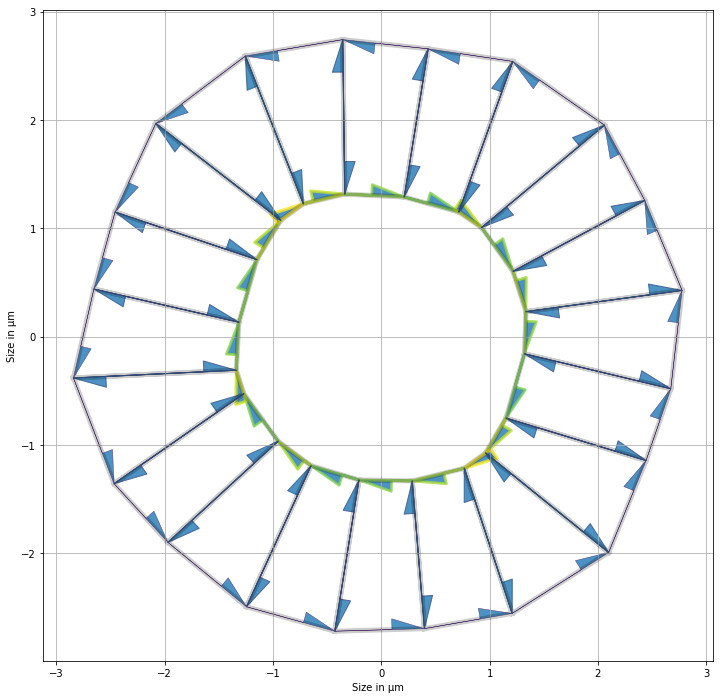

In [3]:
nf, r_in, r_out = (20, 1, 2)
seed = 1
organo3 = create_organo(nf, r_in, r_out)

organo3.edge_df.loc[organo3.apical_edges, 'line_tension'] = [
    0.101, 0.115, 0.126, 0.110, 0.105,
    0.102, 0.112, 0.102, 0.118, 0.105,
    0.104, 0.115, 0.127, 0.116, 0.106,
    0.103, 0.117, 0.105, 0.111, 0.107
]

organo3.edge_df.loc[organo3.basal_edges, 'line_tension'] = [
    0.01, 0.011, 0.012, 0.011, 0.01,
    0.01, 0.011, 0.01, 0.011, 0.01,
    0.01, 0.011, 0.012, 0.011, 0.01,
    0.01, 0.011, 0.01, 0.011, 0.01
]

organo3.edge_df.loc[organo3.lateral_edges, 'line_tension'] = np.array([
    0.03, 0.035, 0.04, 0.035, 0.03,
    0.03, 0.035, 0.03, 0.035, 0.03,
    0.03, 0.035, 0.04, 0.035, 0.03,
    0.03, 0.035, 0.03, 0.035, 0.03,
    0.03, 0.035, 0.04, 0.035, 0.03,
    0.03, 0.035, 0.03, 0.035, 0.03,
    0.03, 0.035, 0.04, 0.035, 0.03,
    0.03, 0.035, 0.03, 0.035, 0.03
])

organo3.face_df.loc[:, 'prefered_area'] = np.array([
    0.08, 0.07, 0.08, 0.09, 0.09,
    0.10, 0.09, 0.08, 0.09, 0.09,
    0.10, 0.11, 0.10, 0.11, 0.12,
    0.11, 0.10, 0.09, 0.08, 0.09
]) + organo3.face_df.area

geom.update_all(organo3)
Solver.find_energy_min(organo3, geom, model)
print_tensions(organo3, organo3)

In [4]:
energy_opt = {'options': {'gtol': 1e-5, 'ftol': 1e-5}}


bfgs_opt = {'method': 'bfgs','options': {'gtol':1e-1,'ftol': 1e-5}}
trf_opt = {'bounds': ([-1e-8]*(3*organo3.Nf),[1000]*(3*organo3.Nf)), 
           'method': 'trf','xtol':1e-5,'ftol': 1e-3, 'verbose': 2}
lm_opt = {'method': 'lm','xtol':1e-5,'ftol': 1e-3, 'verbose': 1}
psqp_opt = {'lb': 0, 'ub': 1e6, 'method': 'dist_PSQP', #'callback': printx,
            'output_path': './PSQP_quad_prog.out'}
nm_opt = {'method':'Nelder-Mead', 'options': {'disp': True}}
slsqp_opt = {'method': 'slsqp'}
reg_weight = 1e-3
theta = 0.02

In [5]:
real_data = np.concatenate((organo3.edge_df.line_tension[:3*organo3.Nf],
                            organo3.face_df.prefered_area - organo3.face_df.area,
                            [organo3.settings['lumen_prefered_vol']-
                             organo3.settings['lumen_volume']]))
print(organo3.edge_df.line_tension, '\n',
      organo3.face_df.prefered_area - organo3.face_df.area)

edge
0     0.101
1     0.115
2     0.126
3     0.110
4     0.105
5     0.102
6     0.112
7     0.102
8     0.118
9     0.105
10    0.104
11    0.115
12    0.127
13    0.116
14    0.106
15    0.103
16    0.117
17    0.105
18    0.111
19    0.107
20    0.010
21    0.011
22    0.012
23    0.011
24    0.010
25    0.010
26    0.011
27    0.010
28    0.011
29    0.010
      ...  
50    0.030
51    0.035
52    0.040
53    0.035
54    0.030
55    0.030
56    0.035
57    0.030
58    0.035
59    0.030
60    0.030
61    0.035
62    0.040
63    0.035
64    0.030
65    0.030
66    0.035
67    0.030
68    0.035
69    0.030
70    0.030
71    0.035
72    0.040
73    0.035
74    0.030
75    0.030
76    0.035
77    0.030
78    0.035
79    0.030
Name: line_tension, Length: 80, dtype: float64 
 face
0     0.037466
1     0.042980
2     0.047452
3     0.041083
4     0.039120
5     0.037130
6     0.042399
7     0.037119
8     0.043188
9     0.038093
10    0.038654
11    0.042510
12    0.047137
13    0.042130

Computing the rank of $A$, we can see that the linear equations system has infinitely many solutions

In [6]:
print('Rank of A: ',
      np.linalg.matrix_rank(_coef_matrix(organo3, sup_param='areas')),
      '\nDimension of A: ',
      _coef_matrix(organo3, sup_param='areas').shape[0])

Rank of A:  78 
Dimension of A:  81


## Programme quadratique avec régularisation des tensions apicales

On introduit le problème de minimisation suivant :
$$ \min ||A\mathbf{x} - \mathbf{b}||^2 $$
$$ \frac{1}{c} T_{j, k}\le T_{i, j} \le c T_{j, k} \quad \forall i,j,k \quad s.t. <i,j>, <j,k> \in \mathcal{E^a}$$

Où $c$ est une constance choisi arbitrairement et $\mathcal{E^a}$ désigne l'ensemble des edges apicaux du maillage

In [7]:
MULT = 1.5
matrix = _coef_matrix(organo3, sup_param='areas')
constant = _right_side(organo3, matrix)
def obj(var, matrix, constant):
    return np.linalg.norm(np.dot(matrix, var) - constant)**2
def make_cst_ub(edges, mult):
    return lambda x: -(x[edges[0]] - x[edges[1]]*mult)
def make_cst_lb(edges, mult):
    return lambda x: -(x[edges[1]]/mult - x[edges[0]])
cst = {}
organo3.get_extra_indices()
start_point = infer_forces(organo3, "NNLS", sup_param="areas")
for edge in organo3.apical_edges:
    couple = (edge, (edge+1)%(organo3.apical_edges.shape[0]))
    cst[(couple, 'ub')] = {'type': 'ineq',
                           'fun': make_cst_ub(couple, MULT)}
    cst[(couple, 'lb')] = {'type': 'ineq',
                           'fun': make_cst_lb(couple, MULT)}
bounds = np.concatenate((np.tile((0, 1e6), organo3.sgle_edges.shape[0]),
                         np.tile((-1e6, 1e6), organo3.Nf+1)))
bounds = np.reshape(bounds, (int(bounds.shape[0]/2), 2))
res = optimize.minimize(obj, np.ones(organo3.sgle_edges.shape[0]+organo3.Nf+1),
                        args=(matrix, constant),
                        method='SLSQP',
                        bounds=[[0, 1e6]]*60+[[-1e6,1e6]]*21,
                        constraints=cst.values())

Apical tensions:  [0.02474261 0.02205992 0.02747877 0.03114343 0.03601331 0.03013553
 0.02242803 0.01761657 0.02195539 0.02096879 0.02633055 0.02368278
 0.01929098 0.02208464 0.02489476 0.02358662 0.0211624  0.01814768
 0.02534755 0.02482579] 
Basal tensions:  [0.00925119 0.0039162  0.00644785 0.01270201 0.01820804 0.01426789
 0.00647401 0.00396321 0.00568016 0.00680342 0.01279492 0.00875979
 0.0039441  0.00740456 0.01095014 0.01002984 0.00561904 0.00432926
 0.0091125  0.00826384] 
Lateral tensions:  [0.01810308 0.01701983 0.01709463 0.02165566 0.02665268 0.02537469
 0.01979726 0.01470801 0.01342604 0.01413141 0.01800785 0.01941242
 0.01506637 0.01434131 0.01695008 0.0186325  0.01535779 0.01331287
 0.01621836 0.01765775] 
Area elasticity:  [0.02502883 0.01872069 0.02443595 0.03169482 0.03964601 0.03227586
 0.02161001 0.01554382 0.01955333 0.01946298 0.02841731 0.02303619
 0.01618021 0.0204518  0.02540099 0.02350652 0.0189525  0.01597447
 0.02502957 0.02414035] 
Lumen area elasticity:  

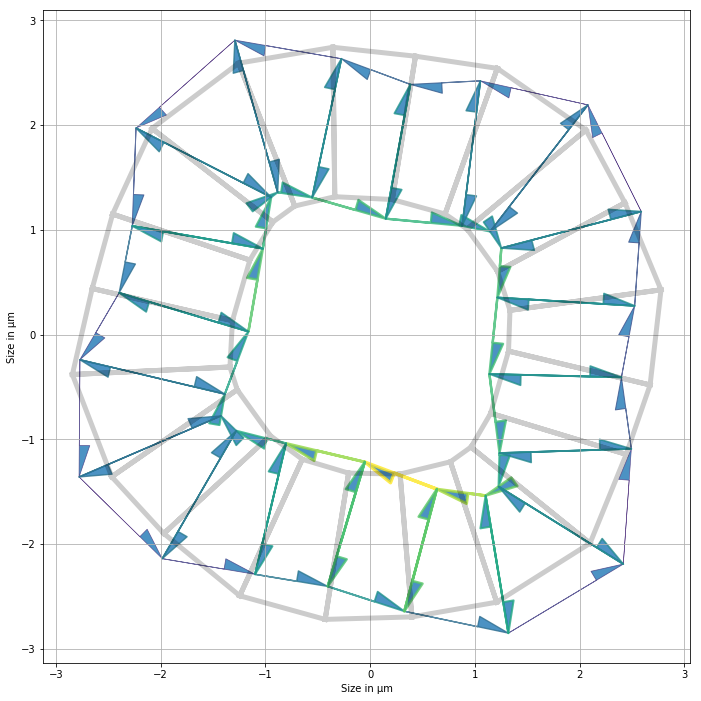

In [8]:
organo3_eq_cst = organo3.copy()
organo3_eq_cst.edge_df.loc[:, 'line_tension'] = prepare_tensions(organo3_eq_cst,
                                                                 res.x[:3*organo3.Nf])
organo3_eq_cst.face_df.loc[:, 'prefered_area'] = organo3_eq_cst.face_df.area + res.x[3*organo3.Nf:4*organo3.Nf]
organo3_eq_cst.settings['lumen_prefered_vol'] = organo3_eq_cst.settings['lumen_volume'] + res.x[-1]
Solver.find_energy_min(organo3_eq_cst, geom, model)
print_tensions(organo3_eq_cst, organo3)
print('Apical tensions: ', res.x[organo3.apical_edges],
      '\nBasal tensions: ', res.x[organo3.basal_edges],
      '\nLateral tensions: ', res.x[organo3.lateral_edges[:organo3.Nf]],
      '\nArea elasticity: ', res.x[organo3.Nf*3:-1],
      '\nLumen area elasticity: ', organo3_eq_cst.settings['lumen_volume'] + res.x[-1],
      '\nDistance to solution: ', np.linalg.norm(real_data-res.x))

In [9]:
organo3_eq_cst.settings['lumen_prefered_vol'], organo3_eq_cst.settings['lumen_volume']

(11.431852091040332, 11.47580851843102)

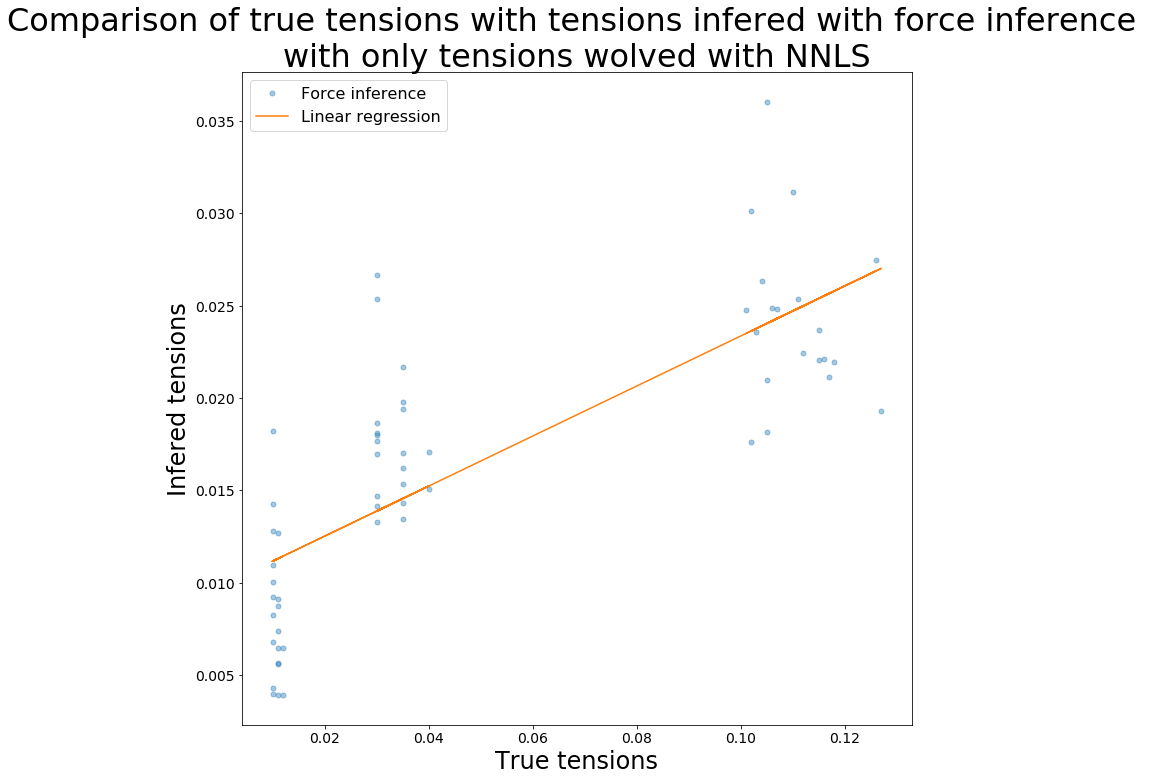

R value : 0.7718613749093656 
Standard error : 0.004155185817886767


In [10]:
rendering_results(organo3, organo3.edge_df.line_tension[:3*organo3.Nf],
                  res.x[:3*organo3.Nf],
                  'Comparison of true tensions with tensions infered with force inference \n' +
                  'with only tensions wolved with NNLS',
                  'True tensions', 'Infered tensions', ('Force inference', 'Linear regression'))

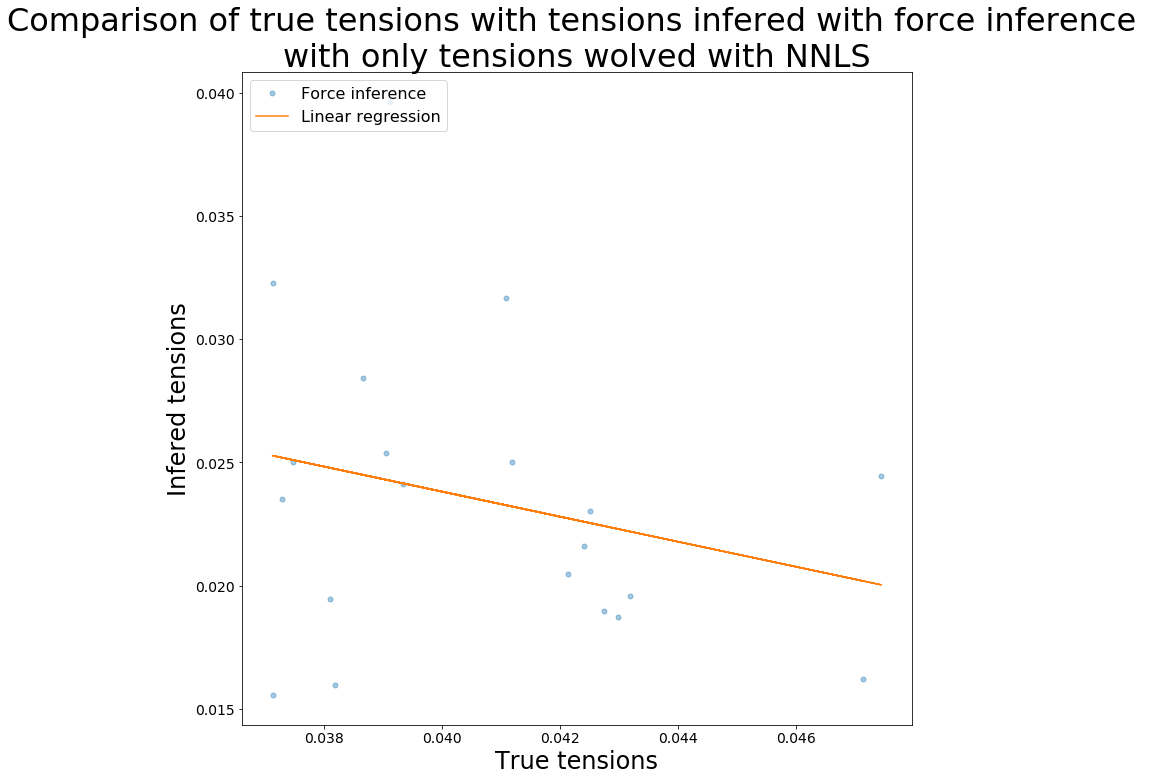

R value : -0.259954353409214 
Standard error : 0.002857497049859423


In [11]:
rendering_results(organo3, organo3.face_df.eval('prefered_area-area'),
                  res.x[3*organo3.Nf:-1],
                  'Comparison of true tensions with tensions infered with force inference \n' +
                  'with only tensions wolved with NNLS',
                  'True tensions', 'Infered tensions', ('Force inference', 'Linear regression'))

In [12]:
iprint_file = "../../assets/dist_at_each_f_ev/4_03_quad_prog_areas_opt.txt"
to_opt_organo = organo3.copy()
init_point_area_and_tensions_opt = np.concatenate((prepare_tensions(to_opt_organo, res.x[:3*to_opt_organo.Nf]),
                                                   to_opt_organo.face_df.area + res.x[3*to_opt_organo.Nf:-1],
                                                   [to_opt_organo.settings['lumen_volume'] + res.x[-1]]))
res_2_cst_areas = adjust_parameters(to_opt_organo,
                                    init_point_area_and_tensions_opt,
                                    {'dic':{'apical' : False, 'basal': False}, 'weight':0},
                                    energy_min_opt=energy_opt,
                                    **lm_opt)

9.816597290338764 [0.2825426  0.38864329 0.45842086 0.46989651 0.37089503 0.18888871
 0.21508779 0.32367188 0.29929695 0.26225617 0.17988024 0.16627494
 0.23782086 0.21671758 0.2168198  0.18294108 0.19419627 0.22008444
 0.22660562 0.16582025 0.27738487 0.07143834 0.3758502  0.31093838
 0.09117416 0.3120803  0.25644191 0.23792951 0.3158401  0.14672261
 0.25932463 0.21499684 0.15323974 0.22252093 0.13640844 0.26598654
 0.19270201 0.2360858  0.18091825 0.29185288 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.  

9.81659471849726 [0.28254258 0.38864313 0.45842079 0.46989645 0.37089494 0.18888863
 0.21508777 0.32367181 0.29929685 0.26225605 0.17988022 0.16627491
 0.23782077 0.21671752 0.21681972 0.18294107 0.19419616 0.22008436
 0.22660557 0.16582022 0.27738477 0.0714384  0.37585005 0.31093831
 0.09117411 0.31208022 0.25644185 0.23792941 0.31584008 0.14672257
 0.25932453 0.21499678 0.15323968 0.22252086 0.13640843 0.26598644
 0.19270195 0.23608576 0.1809182  0.29185278 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.   

9.816597187914049 [0.2825426  0.38864329 0.45842086 0.46989651 0.37089504 0.18888871
 0.21508777 0.32367188 0.29929694 0.26225616 0.17988023 0.16627493
 0.23782086 0.21671756 0.2168198  0.18294108 0.19419627 0.22008443
 0.22660562 0.16582025 0.27738487 0.07143834 0.3758502  0.31093838
 0.09117416 0.31208029 0.2564419  0.2379295  0.31584009 0.14672259
 0.25932462 0.21499684 0.15323973 0.22252093 0.13640844 0.26598654
 0.19270201 0.23608581 0.18091825 0.29185288 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.  

9.816596133812514 [0.2825426  0.38864323 0.45842084 0.46989649 0.37089499 0.18888868
 0.21508778 0.32367185 0.29929691 0.26225612 0.17988023 0.16627493
 0.23782081 0.21671755 0.21681976 0.18294107 0.19419621 0.22008439
 0.2266056  0.16582023 0.27738483 0.07143838 0.37585014 0.31093834
 0.09117415 0.31208026 0.25644189 0.23792946 0.31584009 0.1467226
 0.25932459 0.21499681 0.15323971 0.22252089 0.13640844 0.26598648
 0.19270197 0.23608577 0.18091822 0.29185284 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.   

9.816597352963843 [0.2825426  0.38864329 0.45842087 0.46989651 0.37089504 0.18888871
 0.21508779 0.32367189 0.29929696 0.26225617 0.17988023 0.16627494
 0.23782086 0.21671758 0.2168198  0.18294108 0.19419627 0.22008444
 0.22660562 0.16582025 0.27738487 0.07143834 0.3758502  0.31093838
 0.09117416 0.3120803  0.25644191 0.23792951 0.3158401  0.14672261
 0.25932463 0.21499684 0.15323974 0.22252093 0.13640844 0.26598654
 0.19270201 0.2360858  0.18091825 0.29185288 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.  

9.816598398575799 [0.28254261 0.38864336 0.4584209  0.46989653 0.37089508 0.18888875
 0.21508779 0.32367191 0.299297   0.26225622 0.17988024 0.16627495
 0.2378209  0.2167176  0.21681984 0.18294109 0.19419631 0.22008447
 0.22660564 0.16582026 0.27738491 0.07143832 0.37585026 0.31093841
 0.09117418 0.31208034 0.25644194 0.23792955 0.3158401  0.14672262
 0.25932467 0.21499686 0.15323976 0.22252096 0.13640845 0.26598658
 0.19270203 0.23608582 0.18091827 0.29185292 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.  

9.816597697257755 [0.28254261 0.38864332 0.45842088 0.46989651 0.37089505 0.18888873
 0.21508779 0.3236719  0.29929697 0.26225619 0.17988024 0.16627494
 0.23782087 0.21671759 0.21681981 0.18294108 0.19419629 0.22008445
 0.22660563 0.16582026 0.27738489 0.07143833 0.37585022 0.31093839
 0.09117417 0.31208031 0.25644192 0.23792952 0.3158401  0.14672261
 0.25932464 0.21499684 0.15323975 0.22252093 0.13640844 0.26598655
 0.19270202 0.23608581 0.18091826 0.2918529  0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.  

9.816599077765291 [0.28254262 0.38864339 0.45842091 0.46989654 0.37089511 0.18888877
 0.2150878  0.32367194 0.29929703 0.26225625 0.17988025 0.16627496
 0.23782092 0.21671761 0.21681986 0.18294109 0.19419634 0.22008449
 0.22660566 0.16582028 0.27738494 0.0714383  0.3758503  0.31093843
 0.09117419 0.31208036 0.25644195 0.23792958 0.31584011 0.14672263
 0.2593247  0.21499687 0.15323978 0.22252098 0.13640845 0.2659866
 0.19270205 0.23608583 0.18091828 0.29185295 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.   

9.816599916304277 [0.28254262 0.38864344 0.45842094 0.46989656 0.37089514 0.1888888
 0.21508782 0.32367196 0.29929706 0.26225629 0.17988025 0.16627497
 0.23782094 0.21671765 0.21681988 0.18294109 0.19419637 0.22008452
 0.22660567 0.16582028 0.27738497 0.07143828 0.37585033 0.31093846
 0.09117421 0.31208039 0.25644198 0.2379296  0.31584011 0.14672265
 0.25932473 0.21499689 0.1532398  0.22252099 0.13640845 0.26598663
 0.19270206 0.23608584 0.1809183  0.29185298 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.   

9.816601457694926 [0.28254263 0.38864353 0.45842098 0.46989659 0.3708952  0.18888885
 0.21508782 0.32367201 0.29929712 0.26225637 0.17988026 0.16627499
 0.23782101 0.21671768 0.21681994 0.1829411  0.19419644 0.22008457
 0.2266057  0.1658203  0.27738503 0.07143824 0.37585042 0.3109385
 0.09117423 0.31208044 0.25644201 0.23792966 0.31584012 0.14672266
 0.25932479 0.21499693 0.15323984 0.22252104 0.13640846 0.26598669
 0.1927021  0.23608587 0.18091833 0.29185304 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.   

9.81660141938486 [0.28254263 0.38864353 0.45842098 0.46989659 0.3708952  0.18888886
 0.21508782 0.32367201 0.29929712 0.26225637 0.17988026 0.16627499
 0.237821   0.21671767 0.21681993 0.18294109 0.19419644 0.22008457
 0.2266057  0.1658203  0.27738503 0.07143824 0.37585042 0.3109385
 0.09117423 0.31208044 0.25644201 0.23792966 0.31584012 0.14672266
 0.25932479 0.21499692 0.15323983 0.22252104 0.13640846 0.26598668
 0.1927021  0.23608587 0.18091834 0.29185304 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.    

9.816597290338764 [0.2825426  0.38864329 0.45842086 0.46989651 0.37089503 0.18888871
 0.21508779 0.32367188 0.29929695 0.26225617 0.17988024 0.16627494
 0.23782086 0.21671758 0.2168198  0.18294108 0.19419627 0.22008444
 0.22660562 0.16582025 0.27738487 0.07143834 0.3758502  0.31093838
 0.09117416 0.3120803  0.25644191 0.23792951 0.3158401  0.14672261
 0.25932463 0.21499684 0.15323974 0.22252093 0.13640844 0.26598654
 0.19270201 0.2360858  0.18091825 0.29185288 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.  

9.816597290338764 [0.2825426  0.38864329 0.45842086 0.46989651 0.37089503 0.18888871
 0.21508779 0.32367188 0.29929695 0.26225617 0.17988024 0.16627494
 0.23782086 0.21671758 0.2168198  0.18294108 0.19419627 0.22008444
 0.22660562 0.16582025 0.27738487 0.07143834 0.3758502  0.31093838
 0.09117416 0.3120803  0.25644191 0.23792951 0.3158401  0.14672261
 0.25932463 0.21499684 0.15323974 0.22252093 0.13640844 0.26598654
 0.19270201 0.2360858  0.18091825 0.29185288 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.  

9.816597290338764 [0.2825426  0.38864329 0.45842086 0.46989651 0.37089503 0.18888871
 0.21508779 0.32367188 0.29929695 0.26225617 0.17988024 0.16627494
 0.23782086 0.21671758 0.2168198  0.18294108 0.19419627 0.22008444
 0.22660562 0.16582025 0.27738487 0.07143834 0.3758502  0.31093838
 0.09117416 0.3120803  0.25644191 0.23792951 0.3158401  0.14672261
 0.25932463 0.21499684 0.15323974 0.22252093 0.13640844 0.26598654
 0.19270201 0.2360858  0.18091825 0.29185288 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.  

9.816346423142363 [0.28254101 0.38862863 0.45841379 0.46989119 0.37088509 0.18887974
 0.21508621 0.32366448 0.29928714 0.26224433 0.17987885 0.16627169
 0.23781207 0.21671229 0.21681141 0.1829406  0.19418607 0.22007667
 0.22660086 0.16581733 0.27737559 0.07144394 0.37583713 0.3109313
 0.09116952 0.31207207 0.25643517 0.23792039 0.31583845 0.14671931
 0.25931489 0.21499169 0.15323388 0.22251417 0.13640717 0.26597781
 0.19269665 0.23608156 0.18091304 0.29184324 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.   

9.815894163924037 [0.28253772 0.38860242 0.45840078 0.46988126 0.37086726 0.18886388
 0.21508221 0.32365149 0.29926921 0.26222306 0.1798762  0.1662659
 0.23779651 0.21670126 0.21679655 0.18293977 0.19416816 0.2200626
 0.22659228 0.16581218 0.2773588  0.07145427 0.37581366 0.31091847
 0.09116117 0.31205681 0.25642285 0.23790404 0.31583526 0.14671367
 0.2592973  0.21498276 0.15322336 0.22250223 0.1364051  0.26596232
 0.19268736 0.23607438 0.18090367 0.291826   0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.    

9.816326934018953 [0.28254074 0.38862742 0.45841341 0.4698908  0.37088451 0.18887903
 0.21508529 0.32366424 0.29928627 0.2622433  0.17987875 0.16627156
 0.23781179 0.21671042 0.21681089 0.18294055 0.19418538 0.22007592
 0.2266006  0.16581726 0.27737457 0.07144484 0.37583621 0.31093071
 0.09116915 0.31207103 0.25643447 0.23791961 0.31583876 0.146719
 0.25931401 0.21499159 0.15323336 0.22251395 0.1364073  0.26597716
 0.19269631 0.23608175 0.1809126  0.29184243 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.    

9.816003451874924 [0.28253877 0.38860888 0.45840448 0.46988377 0.37087146 0.18886795
 0.21508332 0.32365456 0.29927335 0.26222808 0.17987667 0.16626763
 0.2378001  0.21670383 0.21680037 0.18293977 0.19417223 0.22006588
 0.2265944  0.16581314 0.27736261 0.07145252 0.37581871 0.31092124
 0.09116348 0.31206036 0.25642635 0.23790752 0.31583648 0.14671509
 0.25930137 0.21498482 0.15322592 0.22250496 0.13640587 0.26596558
 0.1926896  0.23607596 0.1809061  0.29183026 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.  

3.665625150100814 [1.22556206e-01 3.40339677e-02 8.07173915e-02 3.38895073e-02
 1.03840771e-01 7.00056964e-02 1.14014917e-01 1.07155556e-01
 1.43908968e-01 4.55128442e-02 1.12639139e-01 4.66781406e-02
 7.46675623e-02 3.79277668e-02 3.42971683e-02 9.51431628e-02
 7.94141543e-02 2.20547307e-02 5.96331281e-02 7.36105354e-02
 1.27800694e-01 2.42383251e-01 1.74350316e-01 1.63765743e-02
 4.04166689e-02 1.24125994e-01 1.21550837e-01 1.22639331e-01
 1.30916496e-01 2.28220789e-01 1.12378230e-01 6.11875742e-02
 1.12199514e-01 8.81204091e-02 7.40634752e-02 6.16300217e-02
 8.40565366e-02 1.21189868e-01 8.06516466e-02 4.95729528e-02
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.000

3.6656251184813975 [1.22556205e-01 3.40339666e-02 8.07173869e-02 3.38895061e-02
 1.03840769e-01 7.00056983e-02 1.14014913e-01 1.07155551e-01
 1.43908970e-01 4.55128448e-02 1.12639139e-01 4.66781406e-02
 7.46675620e-02 3.79277664e-02 3.42971681e-02 9.51431626e-02
 7.94141530e-02 2.20547305e-02 5.96331283e-02 7.36105337e-02
 1.27800693e-01 2.42383247e-01 1.74350315e-01 1.63765739e-02
 4.04166671e-02 1.24125993e-01 1.21550833e-01 1.22639327e-01
 1.30916495e-01 2.28220789e-01 1.12378231e-01 6.11875745e-02
 1.12199514e-01 8.81204093e-02 7.40634754e-02 6.16300224e-02
 8.40565370e-02 1.21189868e-01 8.06516474e-02 4.95729531e-02
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

3.6656251149229226 [1.22556204e-01 3.40339666e-02 8.07173866e-02 3.38895056e-02
 1.03840768e-01 7.00056964e-02 1.14014918e-01 1.07155556e-01
 1.43908969e-01 4.55128456e-02 1.12639136e-01 4.66781403e-02
 7.46675615e-02 3.79277650e-02 3.42971678e-02 9.51431624e-02
 7.94141527e-02 2.20547304e-02 5.96331283e-02 7.36105334e-02
 1.27800693e-01 2.42383247e-01 1.74350314e-01 1.63765735e-02
 4.04166677e-02 1.24125992e-01 1.21550838e-01 1.22639331e-01
 1.30916497e-01 2.28220787e-01 1.12378228e-01 6.11875711e-02
 1.12199513e-01 8.81204090e-02 7.40634755e-02 6.16300223e-02
 8.40565368e-02 1.21189868e-01 8.06516474e-02 4.95729531e-02
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

3.6656251188789746 [1.22556204e-01 3.40339665e-02 8.07173864e-02 3.38895059e-02
 1.03840768e-01 7.00056965e-02 1.14014918e-01 1.07155556e-01
 1.43908969e-01 4.55128435e-02 1.12639139e-01 4.66781403e-02
 7.46675613e-02 3.79277649e-02 3.42971680e-02 9.51431623e-02
 7.94141509e-02 2.20547304e-02 5.96331284e-02 7.36105330e-02
 1.27800693e-01 2.42383247e-01 1.74350314e-01 1.63765734e-02
 4.04166676e-02 1.24125992e-01 1.21550837e-01 1.22639331e-01
 1.30916496e-01 2.28220788e-01 1.12378230e-01 6.11875744e-02
 1.12199515e-01 8.81204075e-02 7.40634788e-02 6.16300195e-02
 8.40565368e-02 1.21189867e-01 8.06516476e-02 4.95729531e-02
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

3.6656251402466475 [1.22556207e-01 3.40339667e-02 8.07173866e-02 3.38895058e-02
 1.03840768e-01 7.00056962e-02 1.14014918e-01 1.07155556e-01
 1.43908969e-01 4.55128436e-02 1.12639139e-01 4.66781407e-02
 7.46675622e-02 3.79277666e-02 3.42971684e-02 9.51431626e-02
 7.94141520e-02 2.20547300e-02 5.96331333e-02 7.36105347e-02
 1.27800691e-01 2.42383248e-01 1.74350314e-01 1.63765736e-02
 4.04166679e-02 1.24125992e-01 1.21550837e-01 1.22639331e-01
 1.30916496e-01 2.28220789e-01 1.12378230e-01 6.11875744e-02
 1.12199514e-01 8.81204092e-02 7.40634752e-02 6.16300220e-02
 8.40565381e-02 1.21189867e-01 8.06516516e-02 4.95729524e-02
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

3.6656251195772254 [1.22556204e-01 3.40339660e-02 8.07173857e-02 3.38895054e-02
 1.03840768e-01 7.00056962e-02 1.14014918e-01 1.07155556e-01
 1.43908968e-01 4.55128437e-02 1.12639139e-01 4.66781404e-02
 7.46675617e-02 3.79277661e-02 3.42971679e-02 9.51431622e-02
 7.94141524e-02 2.20547304e-02 5.96331282e-02 7.36105331e-02
 1.27800693e-01 2.42383246e-01 1.74350314e-01 1.63765728e-02
 4.04166676e-02 1.24125992e-01 1.21550838e-01 1.22639331e-01
 1.30916496e-01 2.28220788e-01 1.12378231e-01 6.11875745e-02
 1.12199514e-01 8.81204091e-02 7.40634753e-02 6.16300225e-02
 8.40565369e-02 1.21189868e-01 8.06516474e-02 4.95729531e-02
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

3.665625130087024 [1.22556204e-01 3.40339665e-02 8.07173865e-02 3.38895059e-02
 1.03840768e-01 7.00056962e-02 1.14014919e-01 1.07155558e-01
 1.43908969e-01 4.55128435e-02 1.12639139e-01 4.66781404e-02
 7.46675618e-02 3.79277662e-02 3.42971680e-02 9.51431623e-02
 7.94141524e-02 2.20547304e-02 5.96331283e-02 7.36105330e-02
 1.27800693e-01 2.42383247e-01 1.74350314e-01 1.63765735e-02
 4.04166676e-02 1.24125992e-01 1.21550839e-01 1.22639332e-01
 1.30916496e-01 2.28220789e-01 1.12378231e-01 6.11875745e-02
 1.12199514e-01 8.81204092e-02 7.40634753e-02 6.16300225e-02
 8.40565369e-02 1.21189868e-01 8.06516475e-02 4.95729532e-02
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.000

3.66562512743241 [1.22556204e-01 3.40339665e-02 8.07173865e-02 3.38895060e-02
 1.03840768e-01 7.00056965e-02 1.14014918e-01 1.07155556e-01
 1.43908968e-01 4.55128433e-02 1.12639140e-01 4.66781396e-02
 7.46675618e-02 3.79277665e-02 3.42971681e-02 9.51431623e-02
 7.94141525e-02 2.20547304e-02 5.96331283e-02 7.36105331e-02
 1.27800693e-01 2.42383247e-01 1.74350314e-01 1.63765734e-02
 4.04166676e-02 1.24125992e-01 1.21550838e-01 1.22639331e-01
 1.30916496e-01 2.28220789e-01 1.12378230e-01 6.11875761e-02
 1.12199514e-01 8.81204092e-02 7.40634754e-02 6.16300225e-02
 8.40565369e-02 1.21189868e-01 8.06516475e-02 4.95729532e-02
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0000

3.665625124079627 [1.22556204e-01 3.40339664e-02 8.07173865e-02 3.38895060e-02
 1.03840768e-01 7.00056965e-02 1.14014918e-01 1.07155556e-01
 1.43908969e-01 4.55128436e-02 1.12639139e-01 4.66781405e-02
 7.46675619e-02 3.79277666e-02 3.42971673e-02 9.51431616e-02
 7.94141530e-02 2.20547306e-02 5.96331282e-02 7.36105330e-02
 1.27800693e-01 2.42383247e-01 1.74350314e-01 1.63765734e-02
 4.04166676e-02 1.24125992e-01 1.21550838e-01 1.22639331e-01
 1.30916496e-01 2.28220789e-01 1.12378231e-01 6.11875746e-02
 1.12199514e-01 8.81204094e-02 7.40634730e-02 6.16300234e-02
 8.40565365e-02 1.21189868e-01 8.06516475e-02 4.95729532e-02
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.000

3.665625119364636 [1.22556204e-01 3.40339663e-02 8.07173864e-02 3.38895059e-02
 1.03840768e-01 7.00056965e-02 1.14014918e-01 1.07155556e-01
 1.43908969e-01 4.55128436e-02 1.12639139e-01 4.66781404e-02
 7.46675617e-02 3.79277661e-02 3.42971679e-02 9.51431622e-02
 7.94141526e-02 2.20547305e-02 5.96331263e-02 7.36105319e-02
 1.27800693e-01 2.42383247e-01 1.74350314e-01 1.63765734e-02
 4.04166676e-02 1.24125992e-01 1.21550838e-01 1.22639331e-01
 1.30916496e-01 2.28220788e-01 1.12378231e-01 6.11875745e-02
 1.12199514e-01 8.81204092e-02 7.40634753e-02 6.16300226e-02
 8.40565368e-02 1.21189868e-01 8.06516456e-02 4.95729529e-02
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.000

3.665625113155171 [1.22556204e-01 3.40339657e-02 8.07173848e-02 3.38895051e-02
 1.03840767e-01 7.00056967e-02 1.14014918e-01 1.07155557e-01
 1.43908969e-01 4.55128436e-02 1.12639139e-01 4.66781402e-02
 7.46675615e-02 3.79277658e-02 3.42971677e-02 9.51431620e-02
 7.94141517e-02 2.20547305e-02 5.96331282e-02 7.36105321e-02
 1.27800692e-01 2.42383245e-01 1.74350311e-01 1.63765727e-02
 4.04166664e-02 1.24125992e-01 1.21550838e-01 1.22639331e-01
 1.30916497e-01 2.28220789e-01 1.12378231e-01 6.11875748e-02
 1.12199515e-01 8.81204092e-02 7.40634753e-02 6.16300229e-02
 8.40565370e-02 1.21189868e-01 8.06516480e-02 4.95729531e-02
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.000

3.6656251213237843 [1.22556204e-01 3.40339661e-02 8.07173859e-02 3.38895067e-02
 1.03840766e-01 7.00056942e-02 1.14014916e-01 1.07155558e-01
 1.43908969e-01 4.55128437e-02 1.12639139e-01 4.66781401e-02
 7.46675613e-02 3.79277656e-02 3.42971676e-02 9.51431618e-02
 7.94141515e-02 2.20547305e-02 5.96331283e-02 7.36105318e-02
 1.27800693e-01 2.42383247e-01 1.74350315e-01 1.63765722e-02
 4.04166691e-02 1.24125992e-01 1.21550838e-01 1.22639330e-01
 1.30916498e-01 2.28220789e-01 1.12378231e-01 6.11875748e-02
 1.12199515e-01 8.81204091e-02 7.40634752e-02 6.16300229e-02
 8.40565370e-02 1.21189868e-01 8.06516476e-02 4.95729536e-02
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

3.665625129340878 [1.22556204e-01 3.40339662e-02 8.07173865e-02 3.38895068e-02
 1.03840768e-01 7.00056966e-02 1.14014918e-01 1.07155556e-01
 1.43908968e-01 4.55128409e-02 1.12639138e-01 4.66781415e-02
 7.46675620e-02 3.79277662e-02 3.42971677e-02 9.51431616e-02
 7.94141517e-02 2.20547305e-02 5.96331282e-02 7.36105321e-02
 1.27800693e-01 2.42383247e-01 1.74350314e-01 1.63765735e-02
 4.04166677e-02 1.24125992e-01 1.21550837e-01 1.22639332e-01
 1.30916495e-01 2.28220791e-01 1.12378238e-01 6.11875717e-02
 1.12199517e-01 8.81204091e-02 7.40634746e-02 6.16300225e-02
 8.40565370e-02 1.21189868e-01 8.06516473e-02 4.95729534e-02
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.000

3.6656251366274644 [1.22556205e-01 3.40339664e-02 8.07173869e-02 3.38895062e-02
 1.03840769e-01 7.00056966e-02 1.14014918e-01 1.07155557e-01
 1.43908969e-01 4.55128440e-02 1.12639139e-01 4.66781404e-02
 7.46675624e-02 3.79277672e-02 3.42971713e-02 9.51431628e-02
 7.94141529e-02 2.20547302e-02 5.96331284e-02 7.36105329e-02
 1.27800693e-01 2.42383247e-01 1.74350314e-01 1.63765738e-02
 4.04166678e-02 1.24125992e-01 1.21550838e-01 1.22639331e-01
 1.30916496e-01 2.28220789e-01 1.12378231e-01 6.11875746e-02
 1.12199514e-01 8.81204115e-02 7.40634741e-02 6.16300204e-02
 8.40565383e-02 1.21189869e-01 8.06516472e-02 4.95729533e-02
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

3.665625124387827 [1.22556204e-01 3.40339665e-02 8.07173869e-02 3.38895062e-02
 1.03840768e-01 7.00056967e-02 1.14014918e-01 1.07155557e-01
 1.43908969e-01 4.55128440e-02 1.12639139e-01 4.66781399e-02
 7.46675615e-02 3.79277657e-02 3.42971675e-02 9.51431620e-02
 7.94141528e-02 2.20547314e-02 5.96331280e-02 7.36105340e-02
 1.27800694e-01 2.42383247e-01 1.74350315e-01 1.63765736e-02
 4.04166676e-02 1.24125992e-01 1.21550838e-01 1.22639331e-01
 1.30916496e-01 2.28220789e-01 1.12378231e-01 6.11875748e-02
 1.12199514e-01 8.81204093e-02 7.40634757e-02 6.16300227e-02
 8.40565353e-02 1.21189867e-01 8.06516437e-02 4.95729524e-02
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.000

3.665625126000296 [1.22556204e-01 3.40339664e-02 8.07173865e-02 3.38895061e-02
 1.03840768e-01 7.00056966e-02 1.14014918e-01 1.07155556e-01
 1.43908969e-01 4.55128436e-02 1.12639139e-01 4.66781404e-02
 7.46675618e-02 3.79277661e-02 3.42971680e-02 9.51431622e-02
 7.94141524e-02 2.20547304e-02 5.96331283e-02 7.36105329e-02
 1.27800693e-01 2.42383247e-01 1.74350314e-01 1.63765735e-02
 4.04166676e-02 1.24125992e-01 1.21550838e-01 1.22639331e-01
 1.30916496e-01 2.28220789e-01 1.12378231e-01 6.11875745e-02
 1.12199514e-01 8.81204092e-02 7.40634753e-02 6.16300225e-02
 8.40565369e-02 1.21189868e-01 8.06516475e-02 4.95729532e-02
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.000

3.665625126000296 [1.22556204e-01 3.40339664e-02 8.07173865e-02 3.38895061e-02
 1.03840768e-01 7.00056966e-02 1.14014918e-01 1.07155556e-01
 1.43908969e-01 4.55128436e-02 1.12639139e-01 4.66781404e-02
 7.46675618e-02 3.79277661e-02 3.42971680e-02 9.51431622e-02
 7.94141524e-02 2.20547304e-02 5.96331283e-02 7.36105329e-02
 1.27800693e-01 2.42383247e-01 1.74350314e-01 1.63765735e-02
 4.04166676e-02 1.24125992e-01 1.21550838e-01 1.22639331e-01
 1.30916496e-01 2.28220789e-01 1.12378231e-01 6.11875745e-02
 1.12199514e-01 8.81204092e-02 7.40634753e-02 6.16300225e-02
 8.40565369e-02 1.21189868e-01 8.06516475e-02 4.95729532e-02
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.000

3.665625126000296 [1.22556204e-01 3.40339664e-02 8.07173865e-02 3.38895061e-02
 1.03840768e-01 7.00056966e-02 1.14014918e-01 1.07155556e-01
 1.43908969e-01 4.55128436e-02 1.12639139e-01 4.66781404e-02
 7.46675618e-02 3.79277661e-02 3.42971680e-02 9.51431622e-02
 7.94141524e-02 2.20547304e-02 5.96331283e-02 7.36105329e-02
 1.27800693e-01 2.42383247e-01 1.74350314e-01 1.63765735e-02
 4.04166676e-02 1.24125992e-01 1.21550838e-01 1.22639331e-01
 1.30916496e-01 2.28220789e-01 1.12378231e-01 6.11875745e-02
 1.12199514e-01 8.81204092e-02 7.40634753e-02 6.16300225e-02
 8.40565369e-02 1.21189868e-01 8.06516475e-02 4.95729532e-02
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.000

3.665625126000296 [1.22556204e-01 3.40339664e-02 8.07173865e-02 3.38895061e-02
 1.03840768e-01 7.00056966e-02 1.14014918e-01 1.07155556e-01
 1.43908969e-01 4.55128436e-02 1.12639139e-01 4.66781404e-02
 7.46675618e-02 3.79277661e-02 3.42971680e-02 9.51431622e-02
 7.94141524e-02 2.20547304e-02 5.96331283e-02 7.36105329e-02
 1.27800693e-01 2.42383247e-01 1.74350314e-01 1.63765735e-02
 4.04166676e-02 1.24125992e-01 1.21550838e-01 1.22639331e-01
 1.30916496e-01 2.28220789e-01 1.12378231e-01 6.11875745e-02
 1.12199514e-01 8.81204092e-02 7.40634753e-02 6.16300225e-02
 8.40565369e-02 1.21189868e-01 8.06516475e-02 4.95729532e-02
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.000

3.665625126000296 [1.22556204e-01 3.40339664e-02 8.07173865e-02 3.38895061e-02
 1.03840768e-01 7.00056966e-02 1.14014918e-01 1.07155556e-01
 1.43908969e-01 4.55128436e-02 1.12639139e-01 4.66781404e-02
 7.46675618e-02 3.79277661e-02 3.42971680e-02 9.51431622e-02
 7.94141524e-02 2.20547304e-02 5.96331283e-02 7.36105329e-02
 1.27800693e-01 2.42383247e-01 1.74350314e-01 1.63765735e-02
 4.04166676e-02 1.24125992e-01 1.21550838e-01 1.22639331e-01
 1.30916496e-01 2.28220789e-01 1.12378231e-01 6.11875745e-02
 1.12199514e-01 8.81204092e-02 7.40634753e-02 6.16300225e-02
 8.40565369e-02 1.21189868e-01 8.06516475e-02 4.95729532e-02
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.000

3.6656252324297873 [1.22556139e-01 3.40339442e-02 8.07173335e-02 3.38895902e-02
 1.03840688e-01 7.00057393e-02 1.14014943e-01 1.07155562e-01
 1.43909012e-01 4.55128083e-02 1.12639139e-01 4.66781531e-02
 7.46675527e-02 3.79277490e-02 3.42971796e-02 9.51431567e-02
 7.94140819e-02 2.20547081e-02 5.96331482e-02 7.36104198e-02
 1.27800689e-01 2.42383259e-01 1.74350352e-01 1.63765423e-02
 4.04166475e-02 1.24126006e-01 1.21550862e-01 1.22639338e-01
 1.30916538e-01 2.28220826e-01 1.12378251e-01 6.11875923e-02
 1.12199542e-01 8.81204246e-02 7.40634842e-02 6.16300538e-02
 8.40565639e-02 1.21189874e-01 8.06516878e-02 4.95729937e-02
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

3.6656249372375456 [1.22556179e-01 3.40339598e-02 8.07173685e-02 3.38895253e-02
 1.03840740e-01 7.00057015e-02 1.14014923e-01 1.07155557e-01
 1.43908969e-01 4.55128311e-02 1.12639132e-01 4.66781422e-02
 7.46675554e-02 3.79277599e-02 3.42971701e-02 9.51431558e-02
 7.94141294e-02 2.20547227e-02 5.96331305e-02 7.36104990e-02
 1.27800684e-01 2.42383235e-01 1.74350314e-01 1.63765627e-02
 4.04166619e-02 1.24125989e-01 1.21550833e-01 1.22639325e-01
 1.30916502e-01 2.28220785e-01 1.12378227e-01 6.11875746e-02
 1.12199515e-01 8.81204082e-02 7.40634731e-02 6.16300253e-02
 8.40565384e-02 1.21189862e-01 8.06516532e-02 4.95729594e-02
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

3.6656252298587804 [1.22556195e-01 3.40339632e-02 8.07173788e-02 3.38895217e-02
 1.03840756e-01 7.00057058e-02 1.14014925e-01 1.07155560e-01
 1.43908981e-01 4.55128363e-02 1.12639145e-01 4.66781411e-02
 7.46675609e-02 3.79277644e-02 3.42971713e-02 9.51431635e-02
 7.94141414e-02 2.20547267e-02 5.96331334e-02 7.36105134e-02
 1.27800695e-01 2.42383256e-01 1.74350325e-01 1.63765686e-02
 4.04166657e-02 1.24125998e-01 1.21550844e-01 1.22639336e-01
 1.30916506e-01 2.28220803e-01 1.12378235e-01 6.11875766e-02
 1.12199523e-01 8.81204146e-02 7.40634779e-02 6.16300296e-02
 8.40565445e-02 1.21189872e-01 8.06516565e-02 4.95729626e-02
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

3.665625191815768 [1.22556204e-01 3.40339658e-02 8.07173856e-02 3.38895099e-02
 1.03840766e-01 7.00056991e-02 1.14014920e-01 1.07155558e-01
 1.43908972e-01 4.55128429e-02 1.12639141e-01 4.66781424e-02
 7.46675640e-02 3.79277669e-02 3.42971667e-02 9.51431611e-02
 7.94141524e-02 2.20547292e-02 5.96331300e-02 7.36105305e-02
 1.27800695e-01 2.42383251e-01 1.74350319e-01 1.63765719e-02
 4.04166673e-02 1.24125995e-01 1.21550840e-01 1.22639333e-01
 1.30916500e-01 2.28220794e-01 1.12378233e-01 6.11875755e-02
 1.12199517e-01 8.81204130e-02 7.40634797e-02 6.16300225e-02
 8.40565407e-02 1.21189872e-01 8.06516504e-02 4.95729560e-02
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.000

3.665625129239147 [1.22556169e-01 3.40339574e-02 8.07173628e-02 3.38895432e-02
 1.03840730e-01 7.00057153e-02 1.14014929e-01 1.07155557e-01
 1.43908988e-01 4.55128261e-02 1.12639137e-01 4.66781461e-02
 7.46675570e-02 3.79277577e-02 3.42971736e-02 9.51431587e-02
 7.94141191e-02 2.20547227e-02 5.96331312e-02 7.36104750e-02
 1.27800693e-01 2.42383250e-01 1.74350328e-01 1.63765603e-02
 4.04166593e-02 1.24125997e-01 1.21550846e-01 1.22639334e-01
 1.30916514e-01 2.28220804e-01 1.12378239e-01 6.11875819e-02
 1.12199526e-01 8.81204155e-02 7.40634790e-02 6.16300350e-02
 8.40565469e-02 1.21189870e-01 8.06516672e-02 4.95729701e-02
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.000

2.4520594452613036 [7.19546164e-02 3.82282363e-02 1.34558301e-02 4.46397092e-02
 5.19065237e-02 5.81056544e-02 7.09864095e-02 3.96941487e-02
 8.41651331e-02 1.87157159e-02 7.08424922e-02 3.32750041e-02
 4.70826111e-02 2.53945418e-02 3.47373860e-03 4.61530610e-02
 3.46460459e-02 2.58657259e-02 2.48700260e-02 4.92310768e-02
 9.56453858e-02 1.01881710e-01 9.34830127e-02 5.92449287e-02
 7.18204131e-02 1.09862400e-01 8.80193677e-02 4.61310146e-02
 8.36262403e-02 1.29569870e-01 7.10977049e-02 5.80127427e-02
 9.73855833e-02 7.02675377e-02 6.28266555e-02 5.98805318e-02
 6.23903212e-02 8.92202352e-02 6.45583495e-02 8.44111698e-02
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

2.4520594467318313 [7.19546165e-02 3.82282363e-02 1.34558315e-02 4.46397121e-02
 5.19065226e-02 5.81056537e-02 7.09864094e-02 3.96941485e-02
 8.41651329e-02 1.87157159e-02 7.08424921e-02 3.32750041e-02
 4.70826112e-02 2.53945419e-02 3.47373860e-03 4.61530610e-02
 3.46460461e-02 2.58657259e-02 2.48700260e-02 4.92310771e-02
 9.56453856e-02 1.01881710e-01 9.34830115e-02 5.92449304e-02
 7.18204130e-02 1.09862400e-01 8.80193672e-02 4.61310146e-02
 8.36262401e-02 1.29569870e-01 7.10977047e-02 5.80127427e-02
 9.73855832e-02 7.02675376e-02 6.28266554e-02 5.98805316e-02
 6.23903211e-02 8.92202350e-02 6.45583494e-02 8.44111697e-02
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

2.4520594526628905 [7.19546164e-02 3.82282363e-02 1.34558300e-02 4.46397092e-02
 5.19065237e-02 5.81056545e-02 7.09864092e-02 3.96941502e-02
 8.41651349e-02 1.87157161e-02 7.08424923e-02 3.32750042e-02
 4.70826112e-02 2.53945419e-02 3.47373855e-03 4.61530610e-02
 3.46460460e-02 2.58657258e-02 2.48700260e-02 4.92310768e-02
 9.56453858e-02 1.01881710e-01 9.34830127e-02 5.92449287e-02
 7.18204130e-02 1.09862400e-01 8.80193681e-02 4.61310166e-02
 8.36262419e-02 1.29569870e-01 7.10977050e-02 5.80127427e-02
 9.73855833e-02 7.02675377e-02 6.28266555e-02 5.98805318e-02
 6.23903212e-02 8.92202352e-02 6.45583496e-02 8.44111698e-02
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

2.4520594454277633 [7.19546164e-02 3.82282364e-02 1.34558300e-02 4.46397092e-02
 5.19065237e-02 5.81056545e-02 7.09864095e-02 3.96941486e-02
 8.41651331e-02 1.87157160e-02 7.08424916e-02 3.32750025e-02
 4.70826126e-02 2.53945411e-02 3.47373853e-03 4.61530611e-02
 3.46460460e-02 2.58657258e-02 2.48700260e-02 4.92310769e-02
 9.56453858e-02 1.01881710e-01 9.34830128e-02 5.92449287e-02
 7.18204131e-02 1.09862400e-01 8.80193678e-02 4.61310146e-02
 8.36262405e-02 1.29569870e-01 7.10977058e-02 5.80127405e-02
 9.73855858e-02 7.02675371e-02 6.28266557e-02 5.98805319e-02
 6.23903212e-02 8.92202352e-02 6.45583496e-02 8.44111698e-02
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

2.452059445244544 [7.19546163e-02 3.82282364e-02 1.34558300e-02 4.46397092e-02
 5.19065236e-02 5.81056544e-02 7.09864094e-02 3.96941486e-02
 8.41651331e-02 1.87157159e-02 7.08424922e-02 3.32750042e-02
 4.70826111e-02 2.53945419e-02 3.47373925e-03 4.61530615e-02
 3.46460452e-02 2.58657267e-02 2.48700259e-02 4.92310769e-02
 9.56453857e-02 1.01881710e-01 9.34830127e-02 5.92449286e-02
 7.18204131e-02 1.09862400e-01 8.80193677e-02 4.61310146e-02
 8.36262403e-02 1.29569870e-01 7.10977048e-02 5.80127427e-02
 9.73855834e-02 7.02675374e-02 6.28266548e-02 5.98805316e-02
 6.23903227e-02 8.92202341e-02 6.45583497e-02 8.44111698e-02
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.000

2.4520594453169116 [7.19546161e-02 3.82282362e-02 1.34558300e-02 4.46397092e-02
 5.19065237e-02 5.81056544e-02 7.09864095e-02 3.96941486e-02
 8.41651331e-02 1.87157159e-02 7.08424923e-02 3.32750042e-02
 4.70826112e-02 2.53945419e-02 3.47373857e-03 4.61530611e-02
 3.46460461e-02 2.58657259e-02 2.48700260e-02 4.92310756e-02
 9.56453876e-02 1.01881711e-01 9.34830124e-02 5.92449289e-02
 7.18204131e-02 1.09862400e-01 8.80193677e-02 4.61310147e-02
 8.36262404e-02 1.29569871e-01 7.10977048e-02 5.80127427e-02
 9.73855834e-02 7.02675377e-02 6.28266555e-02 5.98805318e-02
 6.23903214e-02 8.92202351e-02 6.45583487e-02 8.44111686e-02
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

2.452059444454699 [7.19546164e-02 3.82282364e-02 1.34558298e-02 4.46397080e-02
 5.19065244e-02 5.81056544e-02 7.09864096e-02 3.96941486e-02
 8.41651331e-02 1.87157159e-02 7.08424922e-02 3.32750041e-02
 4.70826112e-02 2.53945418e-02 3.47373858e-03 4.61530610e-02
 3.46460460e-02 2.58657258e-02 2.48700260e-02 4.92310768e-02
 9.56453858e-02 1.01881710e-01 9.34830128e-02 5.92449273e-02
 7.18204136e-02 1.09862400e-01 8.80193677e-02 4.61310147e-02
 8.36262403e-02 1.29569870e-01 7.10977049e-02 5.80127427e-02
 9.73855833e-02 7.02675377e-02 6.28266555e-02 5.98805318e-02
 6.23903213e-02 8.92202352e-02 6.45583496e-02 8.44111699e-02
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.000

2.4520594434631495 [7.19546164e-02 3.82282363e-02 1.34558300e-02 4.46397092e-02
 5.19065237e-02 5.81056544e-02 7.09864094e-02 3.96941484e-02
 8.41651327e-02 1.87157159e-02 7.08424922e-02 3.32750041e-02
 4.70826111e-02 2.53945418e-02 3.47373859e-03 4.61530610e-02
 3.46460460e-02 2.58657259e-02 2.48700260e-02 4.92310768e-02
 9.56453858e-02 1.01881710e-01 9.34830127e-02 5.92449287e-02
 7.18204131e-02 1.09862400e-01 8.80193677e-02 4.61310142e-02
 8.36262398e-02 1.29569870e-01 7.10977049e-02 5.80127427e-02
 9.73855833e-02 7.02675377e-02 6.28266555e-02 5.98805318e-02
 6.23903212e-02 8.92202352e-02 6.45583495e-02 8.44111698e-02
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

2.4520594438429777 [7.19546164e-02 3.82282363e-02 1.34558300e-02 4.46397092e-02
 5.19065237e-02 5.81056544e-02 7.09864095e-02 3.96941487e-02
 8.41651330e-02 1.87157159e-02 7.08424923e-02 3.32750044e-02
 4.70826101e-02 2.53945420e-02 3.47373853e-03 4.61530610e-02
 3.46460460e-02 2.58657258e-02 2.48700260e-02 4.92310768e-02
 9.56453858e-02 1.01881710e-01 9.34830127e-02 5.92449287e-02
 7.18204131e-02 1.09862400e-01 8.80193677e-02 4.61310146e-02
 8.36262404e-02 1.29569870e-01 7.10977047e-02 5.80127436e-02
 9.73855819e-02 7.02675378e-02 6.28266555e-02 5.98805318e-02
 6.23903212e-02 8.92202352e-02 6.45583495e-02 8.44111698e-02
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

2.4520594420164343 [7.19546164e-02 3.82282363e-02 1.34558300e-02 4.46397092e-02
 5.19065237e-02 5.81056544e-02 7.09864095e-02 3.96941487e-02
 8.41651331e-02 1.87157159e-02 7.08424922e-02 3.32750041e-02
 4.70826111e-02 2.53945420e-02 3.47373848e-03 4.61530601e-02
 3.46460458e-02 2.58657255e-02 2.48700260e-02 4.92310768e-02
 9.56453858e-02 1.01881710e-01 9.34830127e-02 5.92449287e-02
 7.18204131e-02 1.09862400e-01 8.80193677e-02 4.61310146e-02
 8.36262403e-02 1.29569870e-01 7.10977049e-02 5.80127428e-02
 9.73855834e-02 7.02675376e-02 6.28266554e-02 5.98805311e-02
 6.23903198e-02 8.92202353e-02 6.45583496e-02 8.44111699e-02
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

2.4520594443334103 [7.19546167e-02 3.82282364e-02 1.34558300e-02 4.46397092e-02
 5.19065237e-02 5.81056544e-02 7.09864095e-02 3.96941486e-02
 8.41651331e-02 1.87157159e-02 7.08424922e-02 3.32750041e-02
 4.70826111e-02 2.53945418e-02 3.47373858e-03 4.61530610e-02
 3.46460460e-02 2.58657258e-02 2.48700261e-02 4.92310764e-02
 9.56453852e-02 1.01881710e-01 9.34830126e-02 5.92449287e-02
 7.18204131e-02 1.09862400e-01 8.80193677e-02 4.61310146e-02
 8.36262403e-02 1.29569870e-01 7.10977048e-02 5.80127427e-02
 9.73855833e-02 7.02675377e-02 6.28266555e-02 5.98805317e-02
 6.23903212e-02 8.92202351e-02 6.45583495e-02 8.44111700e-02
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

2.4520594436787606 [7.19546169e-02 3.82282362e-02 1.34558284e-02 4.46397094e-02
 5.19065235e-02 5.81056550e-02 7.09864090e-02 3.96941489e-02
 8.41651328e-02 1.87157161e-02 7.08424919e-02 3.32750039e-02
 4.70826110e-02 2.53945417e-02 3.47373881e-03 4.61530607e-02
 3.46460458e-02 2.58657262e-02 2.48700258e-02 4.92310767e-02
 9.56453857e-02 1.01881709e-01 9.34830138e-02 5.92449312e-02
 7.18204139e-02 1.09862398e-01 8.80193680e-02 4.61310144e-02
 8.36262402e-02 1.29569870e-01 7.10977048e-02 5.80127427e-02
 9.73855831e-02 7.02675375e-02 6.28266553e-02 5.98805318e-02
 6.23903211e-02 8.92202350e-02 6.45583495e-02 8.44111697e-02
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

2.452059442444259 [7.19546166e-02 3.82282361e-02 1.34558302e-02 4.46397091e-02
 5.19065240e-02 5.81056542e-02 7.09864105e-02 3.96941471e-02
 8.41651319e-02 1.87157162e-02 7.08424920e-02 3.32750039e-02
 4.70826110e-02 2.53945417e-02 3.47373873e-03 4.61530608e-02
 3.46460458e-02 2.58657260e-02 2.48700259e-02 4.92310766e-02
 9.56453857e-02 1.01881710e-01 9.34830127e-02 5.92449287e-02
 7.18204134e-02 1.09862400e-01 8.80193664e-02 4.61310133e-02
 8.36262414e-02 1.29569870e-01 7.10977048e-02 5.80127428e-02
 9.73855834e-02 7.02675376e-02 6.28266554e-02 5.98805319e-02
 6.23903213e-02 8.92202351e-02 6.45583495e-02 8.44111700e-02
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.000

2.4520594539396168 [7.19546167e-02 3.82282360e-02 1.34558303e-02 4.46397092e-02
 5.19065240e-02 5.81056544e-02 7.09864096e-02 3.96941488e-02
 8.41651334e-02 1.87157156e-02 7.08424935e-02 3.32750072e-02
 4.70826102e-02 2.53945421e-02 3.47373893e-03 4.61530607e-02
 3.46460457e-02 2.58657261e-02 2.48700259e-02 4.92310765e-02
 9.56453857e-02 1.01881710e-01 9.34830126e-02 5.92449287e-02
 7.18204130e-02 1.09862400e-01 8.80193677e-02 4.61310148e-02
 8.36262399e-02 1.29569872e-01 7.10977030e-02 5.80127458e-02
 9.73855857e-02 7.02675380e-02 6.28266552e-02 5.98805318e-02
 6.23903213e-02 8.92202351e-02 6.45583495e-02 8.44111700e-02
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

2.4520594576358477 [7.19546167e-02 3.82282359e-02 1.34558303e-02 4.46397092e-02
 5.19065240e-02 5.81056544e-02 7.09864095e-02 3.96941489e-02
 8.41651330e-02 1.87157161e-02 7.08424921e-02 3.32750039e-02
 4.70826112e-02 2.53945411e-02 3.47373746e-03 4.61530654e-02
 3.46460463e-02 2.58657258e-02 2.48700261e-02 4.92310765e-02
 9.56453857e-02 1.01881710e-01 9.34830126e-02 5.92449287e-02
 7.18204129e-02 1.09862400e-01 8.80193677e-02 4.61310146e-02
 8.36262403e-02 1.29569870e-01 7.10977050e-02 5.80127426e-02
 9.73855830e-02 7.02675388e-02 6.28266577e-02 5.98805368e-02
 6.23903221e-02 8.92202362e-02 6.45583493e-02 8.44111698e-02
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

2.452059454629744 [7.19546158e-02 3.82282358e-02 1.34558304e-02 4.46397093e-02
 5.19065239e-02 5.81056544e-02 7.09864094e-02 3.96941488e-02
 8.41651330e-02 1.87157161e-02 7.08424920e-02 3.32750039e-02
 4.70826110e-02 2.53945417e-02 3.47373870e-03 4.61530606e-02
 3.46460455e-02 2.58657261e-02 2.48700248e-02 4.92310810e-02
 9.56453879e-02 1.01881709e-01 9.34830130e-02 5.92449284e-02
 7.18204129e-02 1.09862400e-01 8.80193677e-02 4.61310146e-02
 8.36262403e-02 1.29569870e-01 7.10977049e-02 5.80127427e-02
 9.73855832e-02 7.02675376e-02 6.28266555e-02 5.98805317e-02
 6.23903207e-02 8.92202355e-02 6.45583520e-02 8.44111747e-02
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.000

2.4520594452613036 [7.19546164e-02 3.82282363e-02 1.34558301e-02 4.46397092e-02
 5.19065237e-02 5.81056544e-02 7.09864095e-02 3.96941487e-02
 8.41651331e-02 1.87157159e-02 7.08424922e-02 3.32750041e-02
 4.70826111e-02 2.53945418e-02 3.47373860e-03 4.61530610e-02
 3.46460459e-02 2.58657259e-02 2.48700260e-02 4.92310768e-02
 9.56453858e-02 1.01881710e-01 9.34830127e-02 5.92449287e-02
 7.18204131e-02 1.09862400e-01 8.80193677e-02 4.61310146e-02
 8.36262403e-02 1.29569870e-01 7.10977049e-02 5.80127427e-02
 9.73855833e-02 7.02675377e-02 6.28266555e-02 5.98805318e-02
 6.23903212e-02 8.92202352e-02 6.45583495e-02 8.44111698e-02
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

2.4520594452613036 [7.19546164e-02 3.82282363e-02 1.34558301e-02 4.46397092e-02
 5.19065237e-02 5.81056544e-02 7.09864095e-02 3.96941487e-02
 8.41651331e-02 1.87157159e-02 7.08424922e-02 3.32750041e-02
 4.70826111e-02 2.53945418e-02 3.47373860e-03 4.61530610e-02
 3.46460459e-02 2.58657259e-02 2.48700260e-02 4.92310768e-02
 9.56453858e-02 1.01881710e-01 9.34830127e-02 5.92449287e-02
 7.18204131e-02 1.09862400e-01 8.80193677e-02 4.61310146e-02
 8.36262403e-02 1.29569870e-01 7.10977049e-02 5.80127427e-02
 9.73855833e-02 7.02675377e-02 6.28266555e-02 5.98805318e-02
 6.23903212e-02 8.92202352e-02 6.45583495e-02 8.44111698e-02
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

2.4520594452613036 [7.19546164e-02 3.82282363e-02 1.34558301e-02 4.46397092e-02
 5.19065237e-02 5.81056544e-02 7.09864095e-02 3.96941487e-02
 8.41651331e-02 1.87157159e-02 7.08424922e-02 3.32750041e-02
 4.70826111e-02 2.53945418e-02 3.47373860e-03 4.61530610e-02
 3.46460459e-02 2.58657259e-02 2.48700260e-02 4.92310768e-02
 9.56453858e-02 1.01881710e-01 9.34830127e-02 5.92449287e-02
 7.18204131e-02 1.09862400e-01 8.80193677e-02 4.61310146e-02
 8.36262403e-02 1.29569870e-01 7.10977049e-02 5.80127427e-02
 9.73855833e-02 7.02675377e-02 6.28266555e-02 5.98805318e-02
 6.23903212e-02 8.92202352e-02 6.45583495e-02 8.44111698e-02
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

2.4520594452613036 [7.19546164e-02 3.82282363e-02 1.34558301e-02 4.46397092e-02
 5.19065237e-02 5.81056544e-02 7.09864095e-02 3.96941487e-02
 8.41651331e-02 1.87157159e-02 7.08424922e-02 3.32750041e-02
 4.70826111e-02 2.53945418e-02 3.47373860e-03 4.61530610e-02
 3.46460459e-02 2.58657259e-02 2.48700260e-02 4.92310768e-02
 9.56453858e-02 1.01881710e-01 9.34830127e-02 5.92449287e-02
 7.18204131e-02 1.09862400e-01 8.80193677e-02 4.61310146e-02
 8.36262403e-02 1.29569870e-01 7.10977049e-02 5.80127427e-02
 9.73855833e-02 7.02675377e-02 6.28266555e-02 5.98805318e-02
 6.23903212e-02 8.92202352e-02 6.45583495e-02 8.44111698e-02
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

2.4520594452613036 [7.19546164e-02 3.82282363e-02 1.34558301e-02 4.46397092e-02
 5.19065237e-02 5.81056544e-02 7.09864095e-02 3.96941487e-02
 8.41651331e-02 1.87157159e-02 7.08424922e-02 3.32750041e-02
 4.70826111e-02 2.53945418e-02 3.47373860e-03 4.61530610e-02
 3.46460459e-02 2.58657259e-02 2.48700260e-02 4.92310768e-02
 9.56453858e-02 1.01881710e-01 9.34830127e-02 5.92449287e-02
 7.18204131e-02 1.09862400e-01 8.80193677e-02 4.61310146e-02
 8.36262403e-02 1.29569870e-01 7.10977049e-02 5.80127427e-02
 9.73855833e-02 7.02675377e-02 6.28266555e-02 5.98805318e-02
 6.23903212e-02 8.92202352e-02 6.45583495e-02 8.44111698e-02
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

2.4520595428219787 [7.19546134e-02 3.82282341e-02 1.34558304e-02 4.46397047e-02
 5.19065272e-02 5.81056584e-02 7.09864135e-02 3.96941505e-02
 8.41651387e-02 1.87157153e-02 7.08424969e-02 3.32750066e-02
 4.70826124e-02 2.53945425e-02 3.47373599e-03 4.61530640e-02
 3.46460458e-02 2.58657226e-02 2.48700266e-02 4.92310738e-02
 9.56453912e-02 1.01881715e-01 9.34830210e-02 5.92449308e-02
 7.18204154e-02 1.09862400e-01 8.80193719e-02 4.61310191e-02
 8.36262461e-02 1.29569882e-01 7.10977078e-02 5.80127435e-02
 9.73855889e-02 7.02675427e-02 6.28266589e-02 5.98805332e-02
 6.23903244e-02 8.92202414e-02 6.45583537e-02 8.44111726e-02
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

2.4520594788472527 [7.19546164e-02 3.82282361e-02 1.34558300e-02 4.46397094e-02
 5.19065246e-02 5.81056546e-02 7.09864120e-02 3.96941481e-02
 8.41651298e-02 1.87157169e-02 7.08424930e-02 3.32750048e-02
 4.70826114e-02 2.53945422e-02 3.47373806e-03 4.61530618e-02
 3.46460467e-02 2.58657256e-02 2.48700263e-02 4.92310769e-02
 9.56453874e-02 1.01881712e-01 9.34830149e-02 5.92449290e-02
 7.18204142e-02 1.09862401e-01 8.80193671e-02 4.61310192e-02
 8.36262436e-02 1.29569874e-01 7.10977056e-02 5.80127433e-02
 9.73855851e-02 7.02675391e-02 6.28266564e-02 5.98805326e-02
 6.23903226e-02 8.92202366e-02 6.45583506e-02 8.44111710e-02
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

2.4520593992417843 [7.19546170e-02 3.82282373e-02 1.34558295e-02 4.46397089e-02
 5.19065236e-02 5.81056533e-02 7.09864078e-02 3.96941478e-02
 8.41651315e-02 1.87157154e-02 7.08424916e-02 3.32750037e-02
 4.70826054e-02 2.53945428e-02 3.47373942e-03 4.61530600e-02
 3.46460462e-02 2.58657268e-02 2.48700258e-02 4.92310780e-02
 9.56453838e-02 1.01881707e-01 9.34830098e-02 5.92449275e-02
 7.18204126e-02 1.09862398e-01 8.80193661e-02 4.61310129e-02
 8.36262372e-02 1.29569867e-01 7.10977029e-02 5.80127376e-02
 9.73855846e-02 7.02675366e-02 6.28266531e-02 5.98805304e-02
 6.23903198e-02 8.92202330e-02 6.45583478e-02 8.44111682e-02
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

2.452059444436933 [7.19546165e-02 3.82282366e-02 1.34558297e-02 4.46397093e-02
 5.19065234e-02 5.81056549e-02 7.09864100e-02 3.96941487e-02
 8.41651333e-02 1.87157158e-02 7.08424925e-02 3.32750044e-02
 4.70826116e-02 2.53945420e-02 3.47373710e-03 4.61530562e-02
 3.46460443e-02 2.58657251e-02 2.48700262e-02 4.92310773e-02
 9.56453863e-02 1.01881710e-01 9.34830132e-02 5.92449283e-02
 7.18204136e-02 1.09862400e-01 8.80193678e-02 4.61310145e-02
 8.36262404e-02 1.29569871e-01 7.10977046e-02 5.80127426e-02
 9.73855832e-02 7.02675393e-02 6.28266570e-02 5.98805301e-02
 6.23903210e-02 8.92202378e-02 6.45583496e-02 8.44111696e-02
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.000

2.4520594575993773 [7.19546225e-02 3.82282379e-02 1.34558287e-02 4.46397114e-02
 5.19065254e-02 5.81056539e-02 7.09864086e-02 3.96941496e-02
 8.41651337e-02 1.87157179e-02 7.08424917e-02 3.32750042e-02
 4.70826109e-02 2.53945417e-02 3.47374016e-03 4.61530603e-02
 3.46460472e-02 2.58657275e-02 2.48700264e-02 4.92310763e-02
 9.56453900e-02 1.01881709e-01 9.34830134e-02 5.92449271e-02
 7.18204144e-02 1.09862400e-01 8.80193687e-02 4.61310122e-02
 8.36262379e-02 1.29569867e-01 7.10977061e-02 5.80127434e-02
 9.73855831e-02 7.02675372e-02 6.28266544e-02 5.98805333e-02
 6.23903220e-02 8.92202340e-02 6.45583509e-02 8.44111673e-02
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

0.8960702016842986 [2.53838535e-02 1.44523637e-02 3.03096398e-02 3.20526539e-02
 2.23690789e-02 2.12426577e-02 6.66013050e-03 2.04219148e-02
 3.01705080e-02 2.05930071e-02 1.55051900e-02 4.32950190e-02
 3.90672458e-02 4.54272018e-02 1.79018694e-02 2.33413774e-02
 8.25757090e-03 3.38292300e-03 2.69182447e-02 2.66844143e-02
 1.27918610e-02 2.62900816e-02 2.00845969e-02 3.18624460e-02
 3.81625949e-02 3.26280365e-02 2.42704419e-02 1.69121845e-02
 1.57804439e-02 1.34079089e-02 1.46218840e-02 3.34364147e-02
 1.77701717e-02 1.73241610e-02 2.92605102e-02 1.24066301e-02
 1.72689167e-02 2.02930338e-02 1.21544049e-02 1.59050907e-02
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

0.8960702171839028 [2.53838536e-02 1.44523657e-02 3.03096411e-02 3.20526545e-02
 2.23690797e-02 2.12426606e-02 6.66013271e-03 2.04219153e-02
 3.01705083e-02 2.05930072e-02 1.55051901e-02 4.32950191e-02
 3.90672460e-02 4.54272020e-02 1.79018695e-02 2.33413775e-02
 8.25757094e-03 3.38292299e-03 2.69182447e-02 2.66844143e-02
 1.27918612e-02 2.62900833e-02 2.00845970e-02 3.18624457e-02
 3.81625939e-02 3.26280370e-02 2.42704449e-02 1.69121834e-02
 1.57804439e-02 1.34079088e-02 1.46218840e-02 3.34364148e-02
 1.77701717e-02 1.73241611e-02 2.92605103e-02 1.24066301e-02
 1.72689167e-02 2.02930339e-02 1.21544050e-02 1.59050907e-02
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

0.8960702102697377 [2.53838537e-02 1.44523656e-02 3.03096410e-02 3.20526543e-02
 2.23690791e-02 2.12426578e-02 6.66013050e-03 2.04219147e-02
 3.01705078e-02 2.05930068e-02 1.55051912e-02 4.32950193e-02
 3.90672459e-02 4.54272019e-02 1.79018694e-02 2.33413775e-02
 8.25757089e-03 3.38292301e-03 2.69182447e-02 2.66844143e-02
 1.27918612e-02 2.62900832e-02 2.00845971e-02 3.18624460e-02
 3.81625949e-02 3.26280365e-02 2.42704420e-02 1.69121845e-02
 1.57804444e-02 1.34079093e-02 1.46218843e-02 3.34364145e-02
 1.77701715e-02 1.73241610e-02 2.92605103e-02 1.24066301e-02
 1.72689167e-02 2.02930338e-02 1.21544050e-02 1.59050907e-02
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

0.8960702044564478 [2.53838536e-02 1.44523656e-02 3.03096410e-02 3.20526542e-02
 2.23690790e-02 2.12426577e-02 6.66013052e-03 2.04219148e-02
 3.01705080e-02 2.05930071e-02 1.55051900e-02 4.32950189e-02
 3.90672456e-02 4.54272011e-02 1.79018681e-02 2.33413772e-02
 8.25757094e-03 3.38292296e-03 2.69182446e-02 2.66844142e-02
 1.27918611e-02 2.62900831e-02 2.00845971e-02 3.18624460e-02
 3.81625948e-02 3.26280364e-02 2.42704419e-02 1.69121845e-02
 1.57804440e-02 1.34079088e-02 1.46218840e-02 3.34364148e-02
 1.77701716e-02 1.73241616e-02 2.92605092e-02 1.24066305e-02
 1.72689166e-02 2.02930338e-02 1.21544049e-02 1.59050907e-02
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

0.896070208999708 [2.53838536e-02 1.44523657e-02 3.03096410e-02 3.20526542e-02
 2.23690791e-02 2.12426578e-02 6.66013053e-03 2.04219148e-02
 3.01705081e-02 2.05930071e-02 1.55051901e-02 4.32950190e-02
 3.90672459e-02 4.54272019e-02 1.79018695e-02 2.33413775e-02
 8.25757075e-03 3.38292452e-03 2.69182441e-02 2.66844140e-02
 1.27918610e-02 2.62900832e-02 2.00845971e-02 3.18624460e-02
 3.81625949e-02 3.26280365e-02 2.42704420e-02 1.69121845e-02
 1.57804440e-02 1.34079089e-02 1.46218840e-02 3.34364148e-02
 1.77701717e-02 1.73241610e-02 2.92605103e-02 1.24066301e-02
 1.72689168e-02 2.02930346e-02 1.21544036e-02 1.59050912e-02
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.000

0.8960702101287432 [2.53838536e-02 1.44523662e-02 3.03096411e-02 3.20526543e-02
 2.23690791e-02 2.12426577e-02 6.66013056e-03 2.04219148e-02
 3.01705080e-02 2.05930071e-02 1.55051901e-02 4.32950191e-02
 3.90672458e-02 4.54272019e-02 1.79018694e-02 2.33413775e-02
 8.25757086e-03 3.38292302e-03 2.69182446e-02 2.66844143e-02
 1.27918612e-02 2.62900838e-02 2.00845973e-02 3.18624461e-02
 3.81625949e-02 3.26280365e-02 2.42704420e-02 1.69121845e-02
 1.57804440e-02 1.34079089e-02 1.46218840e-02 3.34364148e-02
 1.77701717e-02 1.73241610e-02 2.92605103e-02 1.24066301e-02
 1.72689167e-02 2.02930338e-02 1.21544049e-02 1.59050907e-02
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

0.896070202313635 [2.53838536e-02 1.44523656e-02 3.03096410e-02 3.20526542e-02
 2.23690790e-02 2.12426563e-02 6.66013029e-03 2.04219147e-02
 3.01705080e-02 2.05930071e-02 1.55051901e-02 4.32950190e-02
 3.90672458e-02 4.54272018e-02 1.79018694e-02 2.33413774e-02
 8.25757087e-03 3.38292300e-03 2.69182446e-02 2.66844142e-02
 1.27918611e-02 2.62900831e-02 2.00845970e-02 3.18624459e-02
 3.81625947e-02 3.26280355e-02 2.42704403e-02 1.69121844e-02
 1.57804439e-02 1.34079088e-02 1.46218840e-02 3.34364147e-02
 1.77701717e-02 1.73241610e-02 2.92605102e-02 1.24066301e-02
 1.72689167e-02 2.02930338e-02 1.21544049e-02 1.59050907e-02
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.000

0.8960702071650184 [2.53838537e-02 1.44523656e-02 3.03096410e-02 3.20526542e-02
 2.23690791e-02 2.12426577e-02 6.66013055e-03 2.04219148e-02
 3.01705080e-02 2.05930070e-02 1.55051900e-02 4.32950190e-02
 3.90672458e-02 4.54272018e-02 1.79018694e-02 2.33413775e-02
 8.25757086e-03 3.38292302e-03 2.69182446e-02 2.66844142e-02
 1.27918611e-02 2.62900832e-02 2.00845971e-02 3.18624460e-02
 3.81625948e-02 3.26280365e-02 2.42704420e-02 1.69121845e-02
 1.57804440e-02 1.34079088e-02 1.46218838e-02 3.34364147e-02
 1.77701717e-02 1.73241610e-02 2.92605103e-02 1.24066301e-02
 1.72689167e-02 2.02930338e-02 1.21544049e-02 1.59050907e-02
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

0.8960702088321979 [2.53838537e-02 1.44523656e-02 3.03096410e-02 3.20526542e-02
 2.23690791e-02 2.12426577e-02 6.66013055e-03 2.04219148e-02
 3.01705080e-02 2.05930071e-02 1.55051901e-02 4.32950190e-02
 3.90672459e-02 4.54272019e-02 1.79018698e-02 2.33413774e-02
 8.25757088e-03 3.38292301e-03 2.69182446e-02 2.66844142e-02
 1.27918611e-02 2.62900832e-02 2.00845971e-02 3.18624460e-02
 3.81625948e-02 3.26280365e-02 2.42704420e-02 1.69121845e-02
 1.57804440e-02 1.34079088e-02 1.46218840e-02 3.34364148e-02
 1.77701717e-02 1.73241607e-02 2.92605108e-02 1.24066302e-02
 1.72689167e-02 2.02930338e-02 1.21544050e-02 1.59050907e-02
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

0.8960702073133228 [2.53838536e-02 1.44523656e-02 3.03096410e-02 3.20526542e-02
 2.23690791e-02 2.12426577e-02 6.66013054e-03 2.04219148e-02
 3.01705080e-02 2.05930071e-02 1.55051901e-02 4.32950190e-02
 3.90672458e-02 4.54272018e-02 1.79018694e-02 2.33413775e-02
 8.25757092e-03 3.38292242e-03 2.69182444e-02 2.66844142e-02
 1.27918611e-02 2.62900832e-02 2.00845971e-02 3.18624460e-02
 3.81625948e-02 3.26280365e-02 2.42704419e-02 1.69121845e-02
 1.57804440e-02 1.34079088e-02 1.46218840e-02 3.34364148e-02
 1.77701717e-02 1.73241610e-02 2.92605103e-02 1.24066301e-02
 1.72689167e-02 2.02930333e-02 1.21544059e-02 1.59050908e-02
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

0.8960702126757047 [2.53838544e-02 1.44523672e-02 3.03096413e-02 3.20526543e-02
 2.23690793e-02 2.12426577e-02 6.66013069e-03 2.04219150e-02
 3.01705079e-02 2.05930069e-02 1.55051903e-02 4.32950192e-02
 3.90672457e-02 4.54272017e-02 1.79018693e-02 2.33413775e-02
 8.25757072e-03 3.38292305e-03 2.69182444e-02 2.66844137e-02
 1.27918614e-02 2.62900848e-02 2.00845979e-02 3.18624459e-02
 3.81625948e-02 3.26280365e-02 2.42704420e-02 1.69121845e-02
 1.57804440e-02 1.34079088e-02 1.46218841e-02 3.34364148e-02
 1.77701716e-02 1.73241610e-02 2.92605103e-02 1.24066302e-02
 1.72689166e-02 2.02930338e-02 1.21544051e-02 1.59050906e-02
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

0.8960702133385517 [2.53838538e-02 1.44523656e-02 3.03096406e-02 3.20526535e-02
 2.23690781e-02 2.12426590e-02 6.66012998e-03 2.04219148e-02
 3.01705076e-02 2.05930068e-02 1.55051902e-02 4.32950190e-02
 3.90672456e-02 4.54272016e-02 1.79018692e-02 2.33413774e-02
 8.25757068e-03 3.38292308e-03 2.69182444e-02 2.66844140e-02
 1.27918610e-02 2.62900830e-02 2.00845973e-02 3.18624467e-02
 3.81625968e-02 3.26280404e-02 2.42704440e-02 1.69121853e-02
 1.57804441e-02 1.34079088e-02 1.46218841e-02 3.34364147e-02
 1.77701715e-02 1.73241609e-02 2.92605103e-02 1.24066301e-02
 1.72689166e-02 2.02930337e-02 1.21544049e-02 1.59050907e-02
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

0.8960702044661949 [2.53838537e-02 1.44523655e-02 3.03096408e-02 3.20526541e-02
 2.23690791e-02 2.12426576e-02 6.66013070e-03 2.04219151e-02
 3.01705084e-02 2.05930098e-02 1.55051900e-02 4.32950188e-02
 3.90672455e-02 4.54272016e-02 1.79018693e-02 2.33413774e-02
 8.25757078e-03 3.38292304e-03 2.69182445e-02 2.66844141e-02
 1.27918611e-02 2.62900831e-02 2.00845970e-02 3.18624459e-02
 3.81625947e-02 3.26280364e-02 2.42704418e-02 1.69121845e-02
 1.57804428e-02 1.34079060e-02 1.46218836e-02 3.34364150e-02
 1.77701718e-02 1.73241610e-02 2.92605102e-02 1.24066301e-02
 1.72689166e-02 2.02930337e-02 1.21544049e-02 1.59050907e-02
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

0.8960702044147737 [2.53838537e-02 1.44523655e-02 3.03096408e-02 3.20526540e-02
 2.23690791e-02 2.12426576e-02 6.66013060e-03 2.04219148e-02
 3.01705078e-02 2.05930069e-02 1.55051902e-02 4.32950192e-02
 3.90672461e-02 4.54272047e-02 1.79018699e-02 2.33413778e-02
 8.25757067e-03 3.38292309e-03 2.69182444e-02 2.66844141e-02
 1.27918611e-02 2.62900831e-02 2.00845970e-02 3.18624459e-02
 3.81625947e-02 3.26280364e-02 2.42704418e-02 1.69121844e-02
 1.57804439e-02 1.34079088e-02 1.46218838e-02 3.34364143e-02
 1.77701717e-02 1.73241583e-02 2.92605087e-02 1.24066296e-02
 1.72689168e-02 2.02930337e-02 1.21544049e-02 1.59050907e-02
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

0.8960702017818014 [2.53838538e-02 1.44523655e-02 3.03096409e-02 3.20526541e-02
 2.23690791e-02 2.12426577e-02 6.66013063e-03 2.04219149e-02
 3.01705079e-02 2.05930070e-02 1.55051902e-02 4.32950191e-02
 3.90672457e-02 4.54272018e-02 1.79018692e-02 2.33413773e-02
 8.25757099e-03 3.38292192e-03 2.69182442e-02 2.66844142e-02
 1.27918613e-02 2.62900832e-02 2.00845971e-02 3.18624460e-02
 3.81625948e-02 3.26280365e-02 2.42704419e-02 1.69121845e-02
 1.57804440e-02 1.34079088e-02 1.46218841e-02 3.34364147e-02
 1.77701716e-02 1.73241610e-02 2.92605103e-02 1.24066303e-02
 1.72689162e-02 2.02930313e-02 1.21544040e-02 1.59050902e-02
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

0.8960702077402788 [2.53838537e-02 1.44523656e-02 3.03096410e-02 3.20526542e-02
 2.23690791e-02 2.12426577e-02 6.66013056e-03 2.04219148e-02
 3.01705080e-02 2.05930071e-02 1.55051901e-02 4.32950190e-02
 3.90672458e-02 4.54272018e-02 1.79018694e-02 2.33413775e-02
 8.25757086e-03 3.38292302e-03 2.69182446e-02 2.66844142e-02
 1.27918611e-02 2.62900832e-02 2.00845971e-02 3.18624460e-02
 3.81625948e-02 3.26280365e-02 2.42704420e-02 1.69121845e-02
 1.57804440e-02 1.34079088e-02 1.46218840e-02 3.34364148e-02
 1.77701717e-02 1.73241610e-02 2.92605103e-02 1.24066301e-02
 1.72689167e-02 2.02930338e-02 1.21544049e-02 1.59050907e-02
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

0.8960702077402788 [2.53838537e-02 1.44523656e-02 3.03096410e-02 3.20526542e-02
 2.23690791e-02 2.12426577e-02 6.66013056e-03 2.04219148e-02
 3.01705080e-02 2.05930071e-02 1.55051901e-02 4.32950190e-02
 3.90672458e-02 4.54272018e-02 1.79018694e-02 2.33413775e-02
 8.25757086e-03 3.38292302e-03 2.69182446e-02 2.66844142e-02
 1.27918611e-02 2.62900832e-02 2.00845971e-02 3.18624460e-02
 3.81625948e-02 3.26280365e-02 2.42704420e-02 1.69121845e-02
 1.57804440e-02 1.34079088e-02 1.46218840e-02 3.34364148e-02
 1.77701717e-02 1.73241610e-02 2.92605103e-02 1.24066301e-02
 1.72689167e-02 2.02930338e-02 1.21544049e-02 1.59050907e-02
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

0.8960702077402788 [2.53838537e-02 1.44523656e-02 3.03096410e-02 3.20526542e-02
 2.23690791e-02 2.12426577e-02 6.66013056e-03 2.04219148e-02
 3.01705080e-02 2.05930071e-02 1.55051901e-02 4.32950190e-02
 3.90672458e-02 4.54272018e-02 1.79018694e-02 2.33413775e-02
 8.25757086e-03 3.38292302e-03 2.69182446e-02 2.66844142e-02
 1.27918611e-02 2.62900832e-02 2.00845971e-02 3.18624460e-02
 3.81625948e-02 3.26280365e-02 2.42704420e-02 1.69121845e-02
 1.57804440e-02 1.34079088e-02 1.46218840e-02 3.34364148e-02
 1.77701717e-02 1.73241610e-02 2.92605103e-02 1.24066301e-02
 1.72689167e-02 2.02930338e-02 1.21544049e-02 1.59050907e-02
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

0.8960702077402788 [2.53838537e-02 1.44523656e-02 3.03096410e-02 3.20526542e-02
 2.23690791e-02 2.12426577e-02 6.66013056e-03 2.04219148e-02
 3.01705080e-02 2.05930071e-02 1.55051901e-02 4.32950190e-02
 3.90672458e-02 4.54272018e-02 1.79018694e-02 2.33413775e-02
 8.25757086e-03 3.38292302e-03 2.69182446e-02 2.66844142e-02
 1.27918611e-02 2.62900832e-02 2.00845971e-02 3.18624460e-02
 3.81625948e-02 3.26280365e-02 2.42704420e-02 1.69121845e-02
 1.57804440e-02 1.34079088e-02 1.46218840e-02 3.34364148e-02
 1.77701717e-02 1.73241610e-02 2.92605103e-02 1.24066301e-02
 1.72689167e-02 2.02930338e-02 1.21544049e-02 1.59050907e-02
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

0.8960702077402788 [2.53838537e-02 1.44523656e-02 3.03096410e-02 3.20526542e-02
 2.23690791e-02 2.12426577e-02 6.66013056e-03 2.04219148e-02
 3.01705080e-02 2.05930071e-02 1.55051901e-02 4.32950190e-02
 3.90672458e-02 4.54272018e-02 1.79018694e-02 2.33413775e-02
 8.25757086e-03 3.38292302e-03 2.69182446e-02 2.66844142e-02
 1.27918611e-02 2.62900832e-02 2.00845971e-02 3.18624460e-02
 3.81625948e-02 3.26280365e-02 2.42704420e-02 1.69121845e-02
 1.57804440e-02 1.34079088e-02 1.46218840e-02 3.34364148e-02
 1.77701717e-02 1.73241610e-02 2.92605103e-02 1.24066301e-02
 1.72689167e-02 2.02930338e-02 1.21544049e-02 1.59050907e-02
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

0.8960702034925662 [2.53838534e-02 1.44523677e-02 3.03096406e-02 3.20526551e-02
 2.23690789e-02 2.12426579e-02 6.66013016e-03 2.04219146e-02
 3.01705079e-02 2.05930072e-02 1.55051898e-02 4.32950186e-02
 3.90672458e-02 4.54272017e-02 1.79018694e-02 2.33413772e-02
 8.25757108e-03 3.38292275e-03 2.69182445e-02 2.66844139e-02
 1.27918612e-02 2.62900789e-02 2.00846001e-02 3.18624451e-02
 3.81625944e-02 3.26280357e-02 2.42704421e-02 1.69121844e-02
 1.57804439e-02 1.34079089e-02 1.46218837e-02 3.34364146e-02
 1.77701717e-02 1.73241610e-02 2.92605100e-02 1.24066298e-02
 1.72689166e-02 2.02930340e-02 1.21544051e-02 1.59050903e-02
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

0.8960702009609914 [2.53838530e-02 1.44523657e-02 3.03096409e-02 3.20526538e-02
 2.23690776e-02 2.12426531e-02 6.66013128e-03 2.04219138e-02
 3.01705075e-02 2.05930071e-02 1.55051896e-02 4.32950182e-02
 3.90672456e-02 4.54272016e-02 1.79018693e-02 2.33413772e-02
 8.25757110e-03 3.38292295e-03 2.69182445e-02 2.66844141e-02
 1.27918613e-02 2.62900826e-02 2.00845974e-02 3.18624467e-02
 3.81625964e-02 3.26280337e-02 2.42704461e-02 1.69121863e-02
 1.57804441e-02 1.34079092e-02 1.46218835e-02 3.34364146e-02
 1.77701717e-02 1.73241610e-02 2.92605099e-02 1.24066296e-02
 1.72689164e-02 2.02930339e-02 1.21544048e-02 1.59050903e-02
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

0.8960702171478331 [2.53838535e-02 1.44523656e-02 3.03096413e-02 3.20526543e-02
 2.23690792e-02 2.12426577e-02 6.66013047e-03 2.04219154e-02
 3.01705090e-02 2.05930046e-02 1.55051906e-02 4.32950184e-02
 3.90672458e-02 4.54272023e-02 1.79018698e-02 2.33413775e-02
 8.25757104e-03 3.38292287e-03 2.69182451e-02 2.66844145e-02
 1.27918612e-02 2.62900836e-02 2.00845973e-02 3.18624466e-02
 3.81625950e-02 3.26280367e-02 2.42704421e-02 1.69121848e-02
 1.57804422e-02 1.34079134e-02 1.46218827e-02 3.34364166e-02
 1.77701731e-02 1.73241614e-02 2.92605105e-02 1.24066303e-02
 1.72689170e-02 2.02930339e-02 1.21544051e-02 1.59050909e-02
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

0.8960702054764025 [2.53838536e-02 1.44523660e-02 3.03096412e-02 3.20526544e-02
 2.23690789e-02 2.12426576e-02 6.66013022e-03 2.04219145e-02
 3.01705078e-02 2.05930073e-02 1.55051899e-02 4.32950189e-02
 3.90672470e-02 4.54272008e-02 1.79018712e-02 2.33413785e-02
 8.25757101e-03 3.38292339e-03 2.69182448e-02 2.66844144e-02
 1.27918616e-02 2.62900826e-02 2.00845971e-02 3.18624456e-02
 3.81625948e-02 3.26280361e-02 2.42704421e-02 1.69121843e-02
 1.57804438e-02 1.34079090e-02 1.46218829e-02 3.34364140e-02
 1.77701715e-02 1.73241659e-02 2.92605052e-02 1.24066275e-02
 1.72689173e-02 2.02930341e-02 1.21544047e-02 1.59050903e-02
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

0.8960702170857805 [2.53838536e-02 1.44523655e-02 3.03096416e-02 3.20526545e-02
 2.23690794e-02 2.12426579e-02 6.66013042e-03 2.04219151e-02
 3.01705085e-02 2.05930075e-02 1.55051901e-02 4.32950198e-02
 3.90672463e-02 4.54272026e-02 1.79018694e-02 2.33413772e-02
 8.25757136e-03 3.38292064e-03 2.69182425e-02 2.66844154e-02
 1.27918622e-02 2.62900838e-02 2.00845974e-02 3.18624468e-02
 3.81625951e-02 3.26280371e-02 2.42704424e-02 1.69121848e-02
 1.57804444e-02 1.34079091e-02 1.46218845e-02 3.34364150e-02
 1.77701720e-02 1.73241614e-02 2.92605110e-02 1.24066308e-02
 1.72689161e-02 2.02930389e-02 1.21544024e-02 1.59050890e-02
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

3.8658549605985577 [6.32975489e-02 3.13217266e-01 2.76023861e-01 2.38116431e-01
 1.04458868e-01 9.27996917e-02 9.95887389e-02 4.74974700e-02
 3.73735124e-02 1.00791289e-01 1.05861343e-01 9.01135084e-02
 5.25811520e-02 5.53275620e-02 3.27082927e-02 7.79903169e-02
 1.19152651e-01 8.14633138e-02 6.38511405e-02 5.95222683e-02
 5.18867396e-02 4.82822110e-02 3.69110873e-01 1.21636620e-01
 1.01129038e-01 1.14146688e-01 5.16407621e-02 3.59211830e-02
 7.99868647e-02 1.15911061e-01 8.37224787e-02 5.07545257e-02
 1.96848612e-02 4.73502073e-02 7.52997588e-02 4.81631372e-02
 5.60602828e-02 1.59838942e-01 8.65107611e-02 3.70816882e-02
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

0.6782567691899081 [1.79239203e-02 6.61836345e-03 3.31103768e-02 3.27326532e-02
 2.10197072e-02 1.40031575e-02 3.49955201e-03 6.96429179e-03
 1.43956008e-02 2.23505558e-02 1.31735691e-02 3.13108044e-02
 3.82554644e-02 3.95107182e-02 1.21171107e-02 9.04400186e-03
 1.12249098e-02 1.01594069e-02 2.07393729e-02 1.87494499e-02
 4.88268093e-03 1.39881803e-02 1.20830444e-02 2.91134218e-02
 3.26307663e-02 1.88558218e-02 1.44046174e-02 1.17706761e-02
 1.95104053e-02 6.85539253e-03 1.07184054e-02 2.48205134e-02
 2.51623463e-02 1.47545233e-02 1.93359614e-02 8.27509737e-03
 4.94324850e-03 8.95120503e-03 9.49260082e-03 1.08035253e-02
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

0.678256771978389 [1.79239203e-02 6.61836379e-03 3.31103774e-02 3.27326548e-02
 2.10197075e-02 1.40031579e-02 3.49955136e-03 6.96429372e-03
 1.43956010e-02 2.23505558e-02 1.31735690e-02 3.13108042e-02
 3.82554643e-02 3.95107181e-02 1.21171107e-02 9.04400181e-03
 1.12249098e-02 1.01594069e-02 2.07393728e-02 1.87494498e-02
 4.88268085e-03 1.39881798e-02 1.20830437e-02 2.91134226e-02
 3.26307660e-02 1.88558217e-02 1.44046168e-02 1.17706777e-02
 1.95104047e-02 6.85539234e-03 1.07184054e-02 2.48205133e-02
 2.51623462e-02 1.47545232e-02 1.93359613e-02 8.27509733e-03
 4.94324849e-03 8.95120500e-03 9.49260082e-03 1.08035253e-02
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.000

0.6782567682799479 [1.79239202e-02 6.61836375e-03 3.31103773e-02 3.27326546e-02
 2.10197074e-02 1.40031576e-02 3.49955193e-03 6.96429167e-03
 1.43956007e-02 2.23505556e-02 1.31735686e-02 3.13108061e-02
 3.82554643e-02 3.95107180e-02 1.21171106e-02 9.04400174e-03
 1.12249097e-02 1.01594069e-02 2.07393728e-02 1.87494497e-02
 4.88268083e-03 1.39881798e-02 1.20830436e-02 2.91134226e-02
 3.26307660e-02 1.88558214e-02 1.44046174e-02 1.17706761e-02
 1.95104052e-02 6.85539214e-03 1.07184041e-02 2.48205149e-02
 2.51623456e-02 1.47545231e-02 1.93359613e-02 8.27509730e-03
 4.94324847e-03 8.95120497e-03 9.49260079e-03 1.08035252e-02
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

0.6782567675378979 [1.79239203e-02 6.61836377e-03 3.31103773e-02 3.27326547e-02
 2.10197074e-02 1.40031576e-02 3.49955197e-03 6.96429172e-03
 1.43956007e-02 2.23505557e-02 1.31735690e-02 3.13108041e-02
 3.82554641e-02 3.95107180e-02 1.21171124e-02 9.04400087e-03
 1.12249097e-02 1.01594069e-02 2.07393728e-02 1.87494497e-02
 4.88268083e-03 1.39881798e-02 1.20830437e-02 2.91134226e-02
 3.26307661e-02 1.88558214e-02 1.44046175e-02 1.17706761e-02
 1.95104052e-02 6.85539250e-03 1.07184053e-02 2.48205132e-02
 2.51623462e-02 1.47545227e-02 1.93359626e-02 8.27509599e-03
 4.94324805e-03 8.95120489e-03 9.49260080e-03 1.08035253e-02
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

0.6782567678677283 [1.79239203e-02 6.61836393e-03 3.31103774e-02 3.27326548e-02
 2.10197075e-02 1.40031576e-02 3.49955199e-03 6.96429175e-03
 1.43956008e-02 2.23505558e-02 1.31735690e-02 3.13108043e-02
 3.82554643e-02 3.95107182e-02 1.21171107e-02 9.04400184e-03
 1.12249098e-02 1.01594071e-02 2.07393726e-02 1.87494483e-02
 4.88268035e-03 1.39881797e-02 1.20830436e-02 2.91134227e-02
 3.26307662e-02 1.88558215e-02 1.44046175e-02 1.17706761e-02
 1.95104053e-02 6.85539252e-03 1.07184054e-02 2.48205133e-02
 2.51623463e-02 1.47545232e-02 1.93359614e-02 8.27509734e-03
 4.94324849e-03 8.95120451e-03 9.49260230e-03 1.08035238e-02
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

0.678256769225293 [1.79239204e-02 6.61836378e-03 3.31103772e-02 3.27326549e-02
 2.10197074e-02 1.40031576e-02 3.49955201e-03 6.96429173e-03
 1.43956007e-02 2.23505557e-02 1.31735690e-02 3.13108042e-02
 3.82554642e-02 3.95107180e-02 1.21171107e-02 9.04400184e-03
 1.12249097e-02 1.01594069e-02 2.07393727e-02 1.87494497e-02
 4.88268084e-03 1.39881798e-02 1.20830435e-02 2.91134232e-02
 3.26307661e-02 1.88558215e-02 1.44046175e-02 1.17706761e-02
 1.95104052e-02 6.85539250e-03 1.07184054e-02 2.48205132e-02
 2.51623462e-02 1.47545232e-02 1.93359613e-02 8.27509734e-03
 4.94324847e-03 8.95120498e-03 9.49260080e-03 1.08035253e-02
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.000

0.6782567687977916 [1.79239204e-02 6.61836379e-03 3.31103773e-02 3.27326547e-02
 2.10197075e-02 1.40031576e-02 3.49955221e-03 6.96429147e-03
 1.43956007e-02 2.23505557e-02 1.31735690e-02 3.13108043e-02
 3.82554642e-02 3.95107181e-02 1.21171107e-02 9.04400184e-03
 1.12249097e-02 1.01594069e-02 2.07393728e-02 1.87494497e-02
 4.88268084e-03 1.39881798e-02 1.20830437e-02 2.91134227e-02
 3.26307661e-02 1.88558215e-02 1.44046177e-02 1.17706758e-02
 1.95104052e-02 6.85539248e-03 1.07184054e-02 2.48205133e-02
 2.51623462e-02 1.47545232e-02 1.93359613e-02 8.27509734e-03
 4.94324847e-03 8.95120498e-03 9.49260080e-03 1.08035253e-02
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

0.6782567687053644 [1.79239204e-02 6.61836379e-03 3.31103774e-02 3.27326547e-02
 2.10197075e-02 1.40031576e-02 3.49955200e-03 6.96429172e-03
 1.43956007e-02 2.23505558e-02 1.31735696e-02 3.13108037e-02
 3.82554644e-02 3.95107181e-02 1.21171107e-02 9.04400183e-03
 1.12249097e-02 1.01594069e-02 2.07393728e-02 1.87494497e-02
 4.88268084e-03 1.39881798e-02 1.20830437e-02 2.91134227e-02
 3.26307662e-02 1.88558215e-02 1.44046175e-02 1.17706761e-02
 1.95104052e-02 6.85539242e-03 1.07184057e-02 2.48205121e-02
 2.51623461e-02 1.47545232e-02 1.93359614e-02 8.27509735e-03
 4.94324847e-03 8.95120499e-03 9.49260081e-03 1.08035253e-02
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

0.6782567692809219 [1.79239204e-02 6.61836380e-03 3.31103774e-02 3.27326547e-02
 2.10197075e-02 1.40031576e-02 3.49955201e-03 6.96429174e-03
 1.43956007e-02 2.23505557e-02 1.31735691e-02 3.13108043e-02
 3.82554643e-02 3.95107182e-02 1.21171100e-02 9.04400260e-03
 1.12249098e-02 1.01594069e-02 2.07393728e-02 1.87494497e-02
 4.88268084e-03 1.39881798e-02 1.20830437e-02 2.91134227e-02
 3.26307662e-02 1.88558215e-02 1.44046175e-02 1.17706761e-02
 1.95104052e-02 6.85539251e-03 1.07184054e-02 2.48205133e-02
 2.51623462e-02 1.47545231e-02 1.93359603e-02 8.27509804e-03
 4.94324833e-03 8.95120494e-03 9.49260082e-03 1.08035253e-02
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

0.6782567690295459 [1.79239203e-02 6.61836380e-03 3.31103773e-02 3.27326547e-02
 2.10197075e-02 1.40031576e-02 3.49955201e-03 6.96429173e-03
 1.43956007e-02 2.23505557e-02 1.31735690e-02 3.13108042e-02
 3.82554642e-02 3.95107180e-02 1.21171107e-02 9.04400184e-03
 1.12249097e-02 1.01594070e-02 2.07393724e-02 1.87494500e-02
 4.88268080e-03 1.39881798e-02 1.20830437e-02 2.91134227e-02
 3.26307661e-02 1.88558215e-02 1.44046175e-02 1.17706761e-02
 1.95104052e-02 6.85539250e-03 1.07184054e-02 2.48205132e-02
 2.51623462e-02 1.47545232e-02 1.93359613e-02 8.27509733e-03
 4.94324847e-03 8.95120489e-03 9.49260012e-03 1.08035263e-02
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

0.6782567653596558 [1.79239205e-02 6.61836457e-03 3.31103802e-02 3.27326550e-02
 2.10197077e-02 1.40031576e-02 3.49955202e-03 6.96429167e-03
 1.43956006e-02 2.23505555e-02 1.31735690e-02 3.13108041e-02
 3.82554639e-02 3.95107178e-02 1.21171106e-02 9.04400182e-03
 1.12249096e-02 1.01594068e-02 2.07393725e-02 1.87494494e-02
 4.88268064e-03 1.39881788e-02 1.20830408e-02 2.91134225e-02
 3.26307658e-02 1.88558212e-02 1.44046174e-02 1.17706760e-02
 1.95104051e-02 6.85539244e-03 1.07184053e-02 2.48205131e-02
 2.51623460e-02 1.47545231e-02 1.93359612e-02 8.27509729e-03
 4.94324842e-03 8.95120491e-03 9.49260079e-03 1.08035253e-02
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

0.6782567635259009 [1.79239205e-02 6.61836383e-03 3.31103773e-02 3.27326545e-02
 2.10197073e-02 1.40031566e-02 3.49954931e-03 6.96429068e-03
 1.43956002e-02 2.23505555e-02 1.31735692e-02 3.13108044e-02
 3.82554642e-02 3.95107180e-02 1.21171108e-02 9.04400196e-03
 1.12249096e-02 1.01594068e-02 2.07393727e-02 1.87494497e-02
 4.88268082e-03 1.39881798e-02 1.20830437e-02 2.91134229e-02
 3.26307668e-02 1.88558211e-02 1.44046151e-02 1.17706770e-02
 1.95104058e-02 6.85539268e-03 1.07184054e-02 2.48205133e-02
 2.51623462e-02 1.47545232e-02 1.93359614e-02 8.27509740e-03
 4.94324843e-03 8.95120494e-03 9.49260079e-03 1.08035253e-02
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

0.678256771140113 [1.79239206e-02 6.61836382e-03 3.31103773e-02 3.27326547e-02
 2.10197076e-02 1.40031576e-02 3.49955218e-03 6.96429187e-03
 1.43956007e-02 2.23505555e-02 1.31735661e-02 3.13108039e-02
 3.82554638e-02 3.95107180e-02 1.21171108e-02 9.04400200e-03
 1.12249096e-02 1.01594068e-02 2.07393727e-02 1.87494496e-02
 4.88268082e-03 1.39881798e-02 1.20830436e-02 2.91134227e-02
 3.26307662e-02 1.88558216e-02 1.44046174e-02 1.17706760e-02
 1.95104053e-02 6.85539342e-03 1.07184083e-02 2.48205143e-02
 2.51623467e-02 1.47545232e-02 1.93359613e-02 8.27509739e-03
 4.94324843e-03 8.95120493e-03 9.49260078e-03 1.08035253e-02
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.000

0.6782567707692571 [1.79239205e-02 6.61836381e-03 3.31103773e-02 3.27326547e-02
 2.10197076e-02 1.40031576e-02 3.49955212e-03 6.96429174e-03
 1.43956006e-02 2.23505556e-02 1.31735692e-02 3.13108045e-02
 3.82554643e-02 3.95107178e-02 1.21171101e-02 9.04400297e-03
 1.12249095e-02 1.01594068e-02 2.07393726e-02 1.87494497e-02
 4.88268083e-03 1.39881798e-02 1.20830436e-02 2.91134227e-02
 3.26307661e-02 1.88558216e-02 1.44046174e-02 1.17706761e-02
 1.95104052e-02 6.85539247e-03 1.07184054e-02 2.48205132e-02
 2.51623461e-02 1.47545246e-02 1.93359620e-02 8.27509602e-03
 4.94324894e-03 8.95120507e-03 9.49260078e-03 1.08035253e-02
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

0.6782567694017229 [1.79239207e-02 6.61836366e-03 3.31103772e-02 3.27326546e-02
 2.10197075e-02 1.40031576e-02 3.49955211e-03 6.96429172e-03
 1.43956006e-02 2.23505556e-02 1.31735692e-02 3.13108043e-02
 3.82554641e-02 3.95107179e-02 1.21171107e-02 9.04400190e-03
 1.12249094e-02 1.01594060e-02 2.07393761e-02 1.87494500e-02
 4.88268133e-03 1.39881799e-02 1.20830436e-02 2.91134226e-02
 3.26307661e-02 1.88558215e-02 1.44046174e-02 1.17706761e-02
 1.95104052e-02 6.85539243e-03 1.07184054e-02 2.48205132e-02
 2.51623461e-02 1.47545231e-02 1.93359613e-02 8.27509738e-03
 4.94324841e-03 8.95120633e-03 9.49259874e-03 1.08035239e-02
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

0.6782567691192718 [1.79239204e-02 6.61836379e-03 3.31103773e-02 3.27326547e-02
 2.10197075e-02 1.40031576e-02 3.49955202e-03 6.96429173e-03
 1.43956007e-02 2.23505557e-02 1.31735691e-02 3.13108043e-02
 3.82554642e-02 3.95107181e-02 1.21171107e-02 9.04400185e-03
 1.12249097e-02 1.01594069e-02 2.07393728e-02 1.87494497e-02
 4.88268084e-03 1.39881798e-02 1.20830437e-02 2.91134227e-02
 3.26307661e-02 1.88558215e-02 1.44046175e-02 1.17706761e-02
 1.95104052e-02 6.85539250e-03 1.07184054e-02 2.48205133e-02
 2.51623462e-02 1.47545232e-02 1.93359613e-02 8.27509734e-03
 4.94324847e-03 8.95120498e-03 9.49260080e-03 1.08035253e-02
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

0.6782567691192718 [1.79239204e-02 6.61836379e-03 3.31103773e-02 3.27326547e-02
 2.10197075e-02 1.40031576e-02 3.49955202e-03 6.96429173e-03
 1.43956007e-02 2.23505557e-02 1.31735691e-02 3.13108043e-02
 3.82554642e-02 3.95107181e-02 1.21171107e-02 9.04400185e-03
 1.12249097e-02 1.01594069e-02 2.07393728e-02 1.87494497e-02
 4.88268084e-03 1.39881798e-02 1.20830437e-02 2.91134227e-02
 3.26307661e-02 1.88558215e-02 1.44046175e-02 1.17706761e-02
 1.95104052e-02 6.85539250e-03 1.07184054e-02 2.48205133e-02
 2.51623462e-02 1.47545232e-02 1.93359613e-02 8.27509734e-03
 4.94324847e-03 8.95120498e-03 9.49260080e-03 1.08035253e-02
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

0.6782567691192718 [1.79239204e-02 6.61836379e-03 3.31103773e-02 3.27326547e-02
 2.10197075e-02 1.40031576e-02 3.49955202e-03 6.96429173e-03
 1.43956007e-02 2.23505557e-02 1.31735691e-02 3.13108043e-02
 3.82554642e-02 3.95107181e-02 1.21171107e-02 9.04400185e-03
 1.12249097e-02 1.01594069e-02 2.07393728e-02 1.87494497e-02
 4.88268084e-03 1.39881798e-02 1.20830437e-02 2.91134227e-02
 3.26307661e-02 1.88558215e-02 1.44046175e-02 1.17706761e-02
 1.95104052e-02 6.85539250e-03 1.07184054e-02 2.48205133e-02
 2.51623462e-02 1.47545232e-02 1.93359613e-02 8.27509734e-03
 4.94324847e-03 8.95120498e-03 9.49260080e-03 1.08035253e-02
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

0.6782567691192718 [1.79239204e-02 6.61836379e-03 3.31103773e-02 3.27326547e-02
 2.10197075e-02 1.40031576e-02 3.49955202e-03 6.96429173e-03
 1.43956007e-02 2.23505557e-02 1.31735691e-02 3.13108043e-02
 3.82554642e-02 3.95107181e-02 1.21171107e-02 9.04400185e-03
 1.12249097e-02 1.01594069e-02 2.07393728e-02 1.87494497e-02
 4.88268084e-03 1.39881798e-02 1.20830437e-02 2.91134227e-02
 3.26307661e-02 1.88558215e-02 1.44046175e-02 1.17706761e-02
 1.95104052e-02 6.85539250e-03 1.07184054e-02 2.48205133e-02
 2.51623462e-02 1.47545232e-02 1.93359613e-02 8.27509734e-03
 4.94324847e-03 8.95120498e-03 9.49260080e-03 1.08035253e-02
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

0.6782567691192718 [1.79239204e-02 6.61836379e-03 3.31103773e-02 3.27326547e-02
 2.10197075e-02 1.40031576e-02 3.49955202e-03 6.96429173e-03
 1.43956007e-02 2.23505557e-02 1.31735691e-02 3.13108043e-02
 3.82554642e-02 3.95107181e-02 1.21171107e-02 9.04400185e-03
 1.12249097e-02 1.01594069e-02 2.07393728e-02 1.87494497e-02
 4.88268084e-03 1.39881798e-02 1.20830437e-02 2.91134227e-02
 3.26307661e-02 1.88558215e-02 1.44046175e-02 1.17706761e-02
 1.95104052e-02 6.85539250e-03 1.07184054e-02 2.48205133e-02
 2.51623462e-02 1.47545232e-02 1.93359613e-02 8.27509734e-03
 4.94324847e-03 8.95120498e-03 9.49260080e-03 1.08035253e-02
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

0.6782567923218852 [1.79239210e-02 6.61836487e-03 3.31103752e-02 3.27326560e-02
 2.10197088e-02 1.40031588e-02 3.49955213e-03 6.96429162e-03
 1.43956012e-02 2.23505563e-02 1.31735696e-02 3.13108053e-02
 3.82554653e-02 3.95107192e-02 1.21171111e-02 9.04400229e-03
 1.12249100e-02 1.01594073e-02 2.07393734e-02 1.87494501e-02
 4.88268046e-03 1.39881785e-02 1.20830491e-02 2.91134239e-02
 3.26307666e-02 1.88558212e-02 1.44046184e-02 1.17706768e-02
 1.95104059e-02 6.85539270e-03 1.07184061e-02 2.48205139e-02
 2.51623470e-02 1.47545236e-02 1.93359620e-02 8.27509787e-03
 4.94324850e-03 8.95120503e-03 9.49260124e-03 1.08035258e-02
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

0.6782567677736897 [1.79239200e-02 6.61836356e-03 3.31103775e-02 3.27326546e-02
 2.10197065e-02 1.40031564e-02 3.49955575e-03 6.96428730e-03
 1.43956000e-02 2.23505559e-02 1.31735685e-02 3.13108035e-02
 3.82554641e-02 3.95107180e-02 1.21171103e-02 9.04400153e-03
 1.12249099e-02 1.01594069e-02 2.07393727e-02 1.87494499e-02
 4.88268097e-03 1.39881799e-02 1.20830436e-02 2.91134227e-02
 3.26307668e-02 1.88558209e-02 1.44046179e-02 1.17706783e-02
 1.95104067e-02 6.85539367e-03 1.07184048e-02 2.48205131e-02
 2.51623460e-02 1.47545232e-02 1.93359611e-02 8.27509678e-03
 4.94324874e-03 8.95120539e-03 9.49260111e-03 1.08035248e-02
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

0.678256780033314 [1.79239201e-02 6.61836374e-03 3.31103778e-02 3.27326552e-02
 2.10197075e-02 1.40031578e-02 3.49955185e-03 6.96429193e-03
 1.43956014e-02 2.23505563e-02 1.31735734e-02 3.13108027e-02
 3.82554639e-02 3.95107188e-02 1.21171108e-02 9.04400174e-03
 1.12249102e-02 1.01594073e-02 2.07393732e-02 1.87494502e-02
 4.88268086e-03 1.39881800e-02 1.20830441e-02 2.91134232e-02
 3.26307666e-02 1.88558213e-02 1.44046177e-02 1.17706759e-02
 1.95104055e-02 6.85539344e-03 1.07184005e-02 2.48205163e-02
 2.51623483e-02 1.47545236e-02 1.93359611e-02 8.27509721e-03
 4.94324867e-03 8.95120527e-03 9.49260104e-03 1.08035252e-02
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.000

0.678256772306751 [1.79239200e-02 6.61836373e-03 3.31103777e-02 3.27326550e-02
 2.10197072e-02 1.40031575e-02 3.49955172e-03 6.96429179e-03
 1.43956009e-02 2.23505560e-02 1.31735687e-02 3.13108039e-02
 3.82554647e-02 3.95107184e-02 1.21171071e-02 9.04400640e-03
 1.12249101e-02 1.01594073e-02 2.07393730e-02 1.87494500e-02
 4.88268102e-03 1.39881798e-02 1.20830436e-02 2.91134225e-02
 3.26307660e-02 1.88558213e-02 1.44046174e-02 1.17706760e-02
 1.95104053e-02 6.85539267e-03 1.07184050e-02 2.48205129e-02
 2.51623457e-02 1.47545252e-02 1.93359634e-02 8.27509266e-03
 4.94325058e-03 8.95120571e-03 9.49260089e-03 1.08035250e-02
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.000

0.6782567720271561 [1.79239202e-02 6.61836306e-03 3.31103778e-02 3.27326551e-02
 2.10197074e-02 1.40031575e-02 3.49955193e-03 6.96429162e-03
 1.43956009e-02 2.23505560e-02 1.31735689e-02 3.13108041e-02
 3.82554645e-02 3.95107184e-02 1.21171105e-02 9.04400155e-03
 1.12249100e-02 1.01594066e-02 2.07393694e-02 1.87494504e-02
 4.88268279e-03 1.39881807e-02 1.20830439e-02 2.91134226e-02
 3.26307661e-02 1.88558213e-02 1.44046176e-02 1.17706761e-02
 1.95104052e-02 6.85539284e-03 1.07184049e-02 2.48205133e-02
 2.51623463e-02 1.47545233e-02 1.93359614e-02 8.27509721e-03
 4.94324845e-03 8.95120695e-03 9.49260561e-03 1.08035210e-02
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

0.5777954394773743 [1.46822838e-02 9.25611245e-03 3.46365347e-02 2.60411162e-02
 1.50495987e-02 1.48343762e-02 4.93200081e-03 6.11831629e-03
 1.58965846e-02 2.56295259e-02 1.33287044e-02 1.84988491e-02
 3.31165049e-02 3.21180170e-02 9.50869290e-03 7.47724718e-03
 8.45715741e-03 1.23639679e-02 2.04306332e-02 1.24544065e-02
 9.74860077e-03 1.29009579e-02 1.06729090e-02 2.46354121e-02
 2.29539203e-02 6.56549351e-03 2.50338938e-03 7.34302928e-03
 1.66579715e-02 1.03088694e-02 1.06275112e-02 1.93585826e-02
 1.95491616e-02 1.99956253e-02 1.10105268e-02 7.70137869e-03
 7.62854485e-03 3.90398956e-03 8.83903527e-03 1.00598939e-02
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

0.5777954353533177 [1.46822821e-02 9.25611260e-03 3.46365347e-02 2.60411162e-02
 1.50496017e-02 1.48343752e-02 4.93200113e-03 6.11831646e-03
 1.58965846e-02 2.56295258e-02 1.33287043e-02 1.84988489e-02
 3.31165047e-02 3.21180169e-02 9.50869278e-03 7.47724707e-03
 8.45715740e-03 1.23639679e-02 2.04306331e-02 1.24544063e-02
 9.74860057e-03 1.29009567e-02 1.06729091e-02 2.46354112e-02
 2.29539227e-02 6.56549106e-03 2.50338864e-03 7.34302907e-03
 1.66579713e-02 1.03088694e-02 1.06275111e-02 1.93585825e-02
 1.95491615e-02 1.99956252e-02 1.10105268e-02 7.70137859e-03
 7.62854484e-03 3.90398961e-03 8.83903538e-03 1.00598941e-02
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

0.5777954439841589 [1.46822825e-02 9.25611285e-03 3.46365352e-02 2.60411165e-02
 1.50495990e-02 1.48343764e-02 4.93200075e-03 6.11831620e-03
 1.58965836e-02 2.56295258e-02 1.33287047e-02 1.84988494e-02
 3.31165053e-02 3.21180173e-02 9.50869305e-03 7.47724732e-03
 8.45715746e-03 1.23639680e-02 2.04306333e-02 1.24544065e-02
 9.74860081e-03 1.29009569e-02 1.06729094e-02 2.46354123e-02
 2.29539205e-02 6.56549357e-03 2.50338943e-03 7.34302979e-03
 1.66579714e-02 1.03088710e-02 1.06275115e-02 1.93585828e-02
 1.95491617e-02 1.99956255e-02 1.10105269e-02 7.70137882e-03
 7.62854495e-03 3.90398964e-03 8.83903550e-03 1.00598943e-02
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

0.5777954462030692 [1.46822826e-02 9.25611294e-03 3.46365354e-02 2.60411166e-02
 1.50495991e-02 1.48343765e-02 4.93200086e-03 6.11831635e-03
 1.58965848e-02 2.56295263e-02 1.33287046e-02 1.84988492e-02
 3.31165043e-02 3.21180170e-02 9.50869305e-03 7.47724742e-03
 8.45715747e-03 1.23639680e-02 2.04306334e-02 1.24544066e-02
 9.74860090e-03 1.29009569e-02 1.06729095e-02 2.46354125e-02
 2.29539206e-02 6.56549368e-03 2.50338938e-03 7.34302942e-03
 1.66579717e-02 1.03088696e-02 1.06275117e-02 1.93585835e-02
 1.95491609e-02 1.99956262e-02 1.10105274e-02 7.70137905e-03
 7.62854500e-03 3.90398965e-03 8.83903555e-03 1.00598943e-02
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

0.5777954422105985 [1.46822823e-02 9.25611279e-03 3.46365350e-02 2.60411163e-02
 1.50495989e-02 1.48343763e-02 4.93200083e-03 6.11831631e-03
 1.58965846e-02 2.56295260e-02 1.33287046e-02 1.84988492e-02
 3.31165051e-02 3.21180172e-02 9.50869296e-03 7.47724705e-03
 8.45715801e-03 1.23639671e-02 2.04306333e-02 1.24544064e-02
 9.74860080e-03 1.29009568e-02 1.06729094e-02 2.46354123e-02
 2.29539204e-02 6.56549357e-03 2.50338938e-03 7.34302933e-03
 1.66579716e-02 1.03088695e-02 1.06275113e-02 1.93585828e-02
 1.95491617e-02 1.99956254e-02 1.10105268e-02 7.70137917e-03
 7.62854623e-03 3.90398961e-03 8.83903531e-03 1.00598943e-02
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

0.5777954400134417 [1.46822820e-02 9.25611319e-03 3.46365350e-02 2.60411163e-02
 1.50495988e-02 1.48343764e-02 4.93200081e-03 6.11831629e-03
 1.58965846e-02 2.56295260e-02 1.33287046e-02 1.84988492e-02
 3.31165050e-02 3.21180171e-02 9.50869301e-03 7.47724728e-03
 8.45715741e-03 1.23639679e-02 2.04306332e-02 1.24544065e-02
 9.74860048e-03 1.29009564e-02 1.06729093e-02 2.46354122e-02
 2.29539204e-02 6.56549357e-03 2.50338938e-03 7.34302932e-03
 1.66579716e-02 1.03088695e-02 1.06275113e-02 1.93585827e-02
 1.95491617e-02 1.99956254e-02 1.10105269e-02 7.70137877e-03
 7.62854490e-03 3.90398960e-03 8.83903541e-03 1.00598942e-02
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

0.5777954407508805 [1.46822824e-02 9.25611281e-03 3.46365350e-02 2.60411165e-02
 1.50495977e-02 1.48343773e-02 4.93200096e-03 6.11831635e-03
 1.58965846e-02 2.56295260e-02 1.33287046e-02 1.84988492e-02
 3.31165050e-02 3.21180172e-02 9.50869301e-03 7.47724728e-03
 8.45715742e-03 1.23639679e-02 2.04306332e-02 1.24544064e-02
 9.74860075e-03 1.29009568e-02 1.06729093e-02 2.46354121e-02
 2.29539190e-02 6.56549508e-03 2.50338925e-03 7.34302928e-03
 1.66579716e-02 1.03088695e-02 1.06275113e-02 1.93585828e-02
 1.95491617e-02 1.99956254e-02 1.10105269e-02 7.70137877e-03
 7.62854491e-03 3.90398962e-03 8.83903545e-03 1.00598942e-02
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

0.5777954393735005 [1.46822823e-02 9.25611280e-03 3.46365349e-02 2.60411162e-02
 1.50495988e-02 1.48343763e-02 4.93200080e-03 6.11831628e-03
 1.58965846e-02 2.56295258e-02 1.33287045e-02 1.84988492e-02
 3.31165050e-02 3.21180171e-02 9.50869300e-03 7.47724727e-03
 8.45715739e-03 1.23639679e-02 2.04306332e-02 1.24544064e-02
 9.74860072e-03 1.29009568e-02 1.06729094e-02 2.46354122e-02
 2.29539204e-02 6.56549354e-03 2.50338938e-03 7.34302933e-03
 1.66579717e-02 1.03088692e-02 1.06275113e-02 1.93585827e-02
 1.95491617e-02 1.99956254e-02 1.10105269e-02 7.70137875e-03
 7.62854489e-03 3.90398961e-03 8.83903543e-03 1.00598942e-02
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

0.5777954389921077 [1.46822823e-02 9.25611278e-03 3.46365348e-02 2.60411162e-02
 1.50495988e-02 1.48343763e-02 4.93200080e-03 6.11831627e-03
 1.58965846e-02 2.56295259e-02 1.33287045e-02 1.84988491e-02
 3.31165049e-02 3.21180168e-02 9.50869294e-03 7.47724725e-03
 8.45715738e-03 1.23639679e-02 2.04306332e-02 1.24544064e-02
 9.74860070e-03 1.29009568e-02 1.06729094e-02 2.46354122e-02
 2.29539203e-02 6.56549353e-03 2.50338938e-03 7.34302930e-03
 1.66579715e-02 1.03088695e-02 1.06275113e-02 1.93585827e-02
 1.95491622e-02 1.99956253e-02 1.10105269e-02 7.70137874e-03
 7.62854488e-03 3.90398960e-03 8.83903542e-03 1.00598942e-02
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

0.5777954388401019 [1.46822823e-02 9.25611280e-03 3.46365349e-02 2.60411163e-02
 1.50495988e-02 1.48343763e-02 4.93200080e-03 6.11831628e-03
 1.58965846e-02 2.56295259e-02 1.33287045e-02 1.84988492e-02
 3.31165050e-02 3.21180171e-02 9.50869299e-03 7.47724722e-03
 8.45715699e-03 1.23639678e-02 2.04306332e-02 1.24544064e-02
 9.74860073e-03 1.29009568e-02 1.06729094e-02 2.46354122e-02
 2.29539204e-02 6.56549354e-03 2.50338938e-03 7.34302931e-03
 1.66579715e-02 1.03088695e-02 1.06275113e-02 1.93585827e-02
 1.95491617e-02 1.99956254e-02 1.10105268e-02 7.70137876e-03
 7.62854437e-03 3.90398980e-03 8.83903544e-03 1.00598942e-02
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

0.5777954470120339 [1.46822807e-02 9.25611393e-03 3.46365348e-02 2.60411163e-02
 1.50495990e-02 1.48343766e-02 4.93200075e-03 6.11831618e-03
 1.58965845e-02 2.56295260e-02 1.33287048e-02 1.84988495e-02
 3.31165050e-02 3.21180172e-02 9.50869323e-03 7.47724750e-03
 8.45715727e-03 1.23639677e-02 2.04306329e-02 1.24544055e-02
 9.74860391e-03 1.29009584e-02 1.06729098e-02 2.46354123e-02
 2.29539204e-02 6.56549360e-03 2.50338935e-03 7.34302937e-03
 1.66579716e-02 1.03088695e-02 1.06275114e-02 1.93585829e-02
 1.95491617e-02 1.99956254e-02 1.10105269e-02 7.70137888e-03
 7.62854498e-03 3.90398977e-03 8.83903602e-03 1.00598952e-02
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

0.5777954410579459 [1.46822825e-02 9.25611304e-03 3.46365348e-02 2.60411156e-02
 1.50495984e-02 1.48343775e-02 4.93200017e-03 6.11831595e-03
 1.58965844e-02 2.56295259e-02 1.33287048e-02 1.84988494e-02
 3.31165049e-02 3.21180170e-02 9.50869324e-03 7.47724749e-03
 8.45715728e-03 1.23639678e-02 2.04306331e-02 1.24544063e-02
 9.74860082e-03 1.29009568e-02 1.06729100e-02 2.46354143e-02
 2.29539194e-02 6.56549230e-03 2.50339007e-03 7.34302951e-03
 1.66579716e-02 1.03088695e-02 1.06275114e-02 1.93585828e-02
 1.95491617e-02 1.99956254e-02 1.10105269e-02 7.70137889e-03
 7.62854488e-03 3.90398954e-03 8.83903540e-03 1.00598942e-02
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

0.5777954417763514 [1.46822825e-02 9.25611292e-03 3.46365349e-02 2.60411162e-02
 1.50495988e-02 1.48343764e-02 4.93200096e-03 6.11831636e-03
 1.58965874e-02 2.56295259e-02 1.33287046e-02 1.84988493e-02
 3.31165049e-02 3.21180171e-02 9.50869313e-03 7.47724739e-03
 8.45715734e-03 1.23639678e-02 2.04306331e-02 1.24544063e-02
 9.74860079e-03 1.29009568e-02 1.06729094e-02 2.46354122e-02
 2.29539204e-02 6.56549368e-03 2.50338926e-03 7.34302841e-03
 1.66579694e-02 1.03088708e-02 1.06275113e-02 1.93585828e-02
 1.95491617e-02 1.99956254e-02 1.10105269e-02 7.70137882e-03
 7.62854489e-03 3.90398958e-03 8.83903541e-03 1.00598942e-02
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

0.5777954371662231 [1.46822822e-02 9.25611279e-03 3.46365346e-02 2.60411160e-02
 1.50495987e-02 1.48343763e-02 4.93200074e-03 6.11831618e-03
 1.58965844e-02 2.56295257e-02 1.33287049e-02 1.84988500e-02
 3.31165081e-02 3.21180168e-02 9.50869317e-03 7.47724725e-03
 8.45715731e-03 1.23639677e-02 2.04306330e-02 1.24544062e-02
 9.74860065e-03 1.29009567e-02 1.06729093e-02 2.46354120e-02
 2.29539202e-02 6.56549347e-03 2.50338935e-03 7.34302923e-03
 1.66579714e-02 1.03088694e-02 1.06275106e-02 1.93585812e-02
 1.95491602e-02 1.99956266e-02 1.10105264e-02 7.70137856e-03
 7.62854481e-03 3.90398956e-03 8.83903533e-03 1.00598941e-02
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

0.5777954409260379 [1.46822825e-02 9.25611291e-03 3.46365348e-02 2.60411162e-02
 1.50495988e-02 1.48343764e-02 4.93200075e-03 6.11831620e-03
 1.58965845e-02 2.56295259e-02 1.33287046e-02 1.84988493e-02
 3.31165049e-02 3.21180170e-02 9.50869323e-03 7.47724822e-03
 8.45715954e-03 1.23639679e-02 2.04306330e-02 1.24544064e-02
 9.74860070e-03 1.29009568e-02 1.06729093e-02 2.46354122e-02
 2.29539203e-02 6.56549355e-03 2.50338936e-03 7.34302931e-03
 1.66579715e-02 1.03088694e-02 1.06275113e-02 1.93585827e-02
 1.95491616e-02 1.99956255e-02 1.10105272e-02 7.70137776e-03
 7.62854306e-03 3.90399042e-03 8.83903552e-03 1.00598941e-02
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

0.5777954401458485 [1.46822824e-02 9.25611282e-03 3.46365349e-02 2.60411163e-02
 1.50495988e-02 1.48343764e-02 4.93200080e-03 6.11831627e-03
 1.58965846e-02 2.56295260e-02 1.33287046e-02 1.84988492e-02
 3.31165050e-02 3.21180171e-02 9.50869301e-03 7.47724729e-03
 8.45715739e-03 1.23639679e-02 2.04306332e-02 1.24544064e-02
 9.74860074e-03 1.29009568e-02 1.06729094e-02 2.46354122e-02
 2.29539204e-02 6.56549355e-03 2.50338938e-03 7.34302932e-03
 1.66579716e-02 1.03088695e-02 1.06275113e-02 1.93585827e-02
 1.95491617e-02 1.99956254e-02 1.10105269e-02 7.70137876e-03
 7.62854490e-03 3.90398961e-03 8.83903544e-03 1.00598942e-02
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

0.5777954401458485 [1.46822824e-02 9.25611282e-03 3.46365349e-02 2.60411163e-02
 1.50495988e-02 1.48343764e-02 4.93200080e-03 6.11831627e-03
 1.58965846e-02 2.56295260e-02 1.33287046e-02 1.84988492e-02
 3.31165050e-02 3.21180171e-02 9.50869301e-03 7.47724729e-03
 8.45715739e-03 1.23639679e-02 2.04306332e-02 1.24544064e-02
 9.74860074e-03 1.29009568e-02 1.06729094e-02 2.46354122e-02
 2.29539204e-02 6.56549355e-03 2.50338938e-03 7.34302932e-03
 1.66579716e-02 1.03088695e-02 1.06275113e-02 1.93585827e-02
 1.95491617e-02 1.99956254e-02 1.10105269e-02 7.70137876e-03
 7.62854490e-03 3.90398961e-03 8.83903544e-03 1.00598942e-02
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

0.5777954401458485 [1.46822824e-02 9.25611282e-03 3.46365349e-02 2.60411163e-02
 1.50495988e-02 1.48343764e-02 4.93200080e-03 6.11831627e-03
 1.58965846e-02 2.56295260e-02 1.33287046e-02 1.84988492e-02
 3.31165050e-02 3.21180171e-02 9.50869301e-03 7.47724729e-03
 8.45715739e-03 1.23639679e-02 2.04306332e-02 1.24544064e-02
 9.74860074e-03 1.29009568e-02 1.06729094e-02 2.46354122e-02
 2.29539204e-02 6.56549355e-03 2.50338938e-03 7.34302932e-03
 1.66579716e-02 1.03088695e-02 1.06275113e-02 1.93585827e-02
 1.95491617e-02 1.99956254e-02 1.10105269e-02 7.70137876e-03
 7.62854490e-03 3.90398961e-03 8.83903544e-03 1.00598942e-02
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

0.5777954401458485 [1.46822824e-02 9.25611282e-03 3.46365349e-02 2.60411163e-02
 1.50495988e-02 1.48343764e-02 4.93200080e-03 6.11831627e-03
 1.58965846e-02 2.56295260e-02 1.33287046e-02 1.84988492e-02
 3.31165050e-02 3.21180171e-02 9.50869301e-03 7.47724729e-03
 8.45715739e-03 1.23639679e-02 2.04306332e-02 1.24544064e-02
 9.74860074e-03 1.29009568e-02 1.06729094e-02 2.46354122e-02
 2.29539204e-02 6.56549355e-03 2.50338938e-03 7.34302932e-03
 1.66579716e-02 1.03088695e-02 1.06275113e-02 1.93585827e-02
 1.95491617e-02 1.99956254e-02 1.10105269e-02 7.70137876e-03
 7.62854490e-03 3.90398961e-03 8.83903544e-03 1.00598942e-02
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

0.5777954401458485 [1.46822824e-02 9.25611282e-03 3.46365349e-02 2.60411163e-02
 1.50495988e-02 1.48343764e-02 4.93200080e-03 6.11831627e-03
 1.58965846e-02 2.56295260e-02 1.33287046e-02 1.84988492e-02
 3.31165050e-02 3.21180171e-02 9.50869301e-03 7.47724729e-03
 8.45715739e-03 1.23639679e-02 2.04306332e-02 1.24544064e-02
 9.74860074e-03 1.29009568e-02 1.06729094e-02 2.46354122e-02
 2.29539204e-02 6.56549355e-03 2.50338938e-03 7.34302932e-03
 1.66579716e-02 1.03088695e-02 1.06275113e-02 1.93585827e-02
 1.95491617e-02 1.99956254e-02 1.10105269e-02 7.70137876e-03
 7.62854490e-03 3.90398961e-03 8.83903544e-03 1.00598942e-02
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

0.5777954582533105 [1.46822809e-02 9.25611687e-03 3.46365357e-02 2.60411174e-02
 1.50495991e-02 1.48343763e-02 4.93200121e-03 6.11831665e-03
 1.58965849e-02 2.56295266e-02 1.33287046e-02 1.84988495e-02
 3.31165058e-02 3.21180178e-02 9.50869300e-03 7.47724735e-03
 8.45715761e-03 1.23639682e-02 2.04306336e-02 1.24544058e-02
 9.74859844e-03 1.29009618e-02 1.06729104e-02 2.46354123e-02
 2.29539205e-02 6.56549357e-03 2.50338932e-03 7.34302926e-03
 1.66579719e-02 1.03088699e-02 1.06275112e-02 1.93585830e-02
 1.95491621e-02 1.99956258e-02 1.10105270e-02 7.70137865e-03
 7.62854525e-03 3.90399021e-03 8.83903688e-03 1.00598958e-02
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

0.5777955022553575 [1.46822841e-02 9.25611369e-03 3.46365383e-02 2.60411185e-02
 1.50495962e-02 1.48343819e-02 4.93200008e-03 6.11831635e-03
 1.58965861e-02 2.56295284e-02 1.33287060e-02 1.84988514e-02
 3.31165080e-02 3.21180202e-02 9.50869412e-03 7.47724839e-03
 8.45715798e-03 1.23639690e-02 2.04306349e-02 1.24544075e-02
 9.74860190e-03 1.29009577e-02 1.06729111e-02 2.46354162e-02
 2.29539266e-02 6.56549134e-03 2.50339158e-03 7.34303079e-03
 1.66579734e-02 1.03088708e-02 1.06275129e-02 1.93585845e-02
 1.95491637e-02 1.99956274e-02 1.10105278e-02 7.70137992e-03
 7.62854581e-03 3.90399006e-03 8.83903642e-03 1.00598951e-02
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

0.5777954642154125 [1.46822829e-02 9.25611319e-03 3.46365362e-02 2.60411173e-02
 1.50495993e-02 1.48343767e-02 4.93200148e-03 6.11831707e-03
 1.58965833e-02 2.56295235e-02 1.33287044e-02 1.84988495e-02
 3.31165061e-02 3.21180184e-02 9.50869337e-03 7.47724770e-03
 8.45715763e-03 1.23639684e-02 2.04306338e-02 1.24544070e-02
 9.74860121e-03 1.29009573e-02 1.06729099e-02 2.46354132e-02
 2.29539214e-02 6.56549419e-03 2.50338894e-03 7.34302834e-03
 1.66579749e-02 1.03088749e-02 1.06275121e-02 1.93585838e-02
 1.95491627e-02 1.99956263e-02 1.10105271e-02 7.70137913e-03
 7.62854530e-03 3.90398979e-03 8.83903589e-03 1.00598944e-02
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

0.5777954414601086 [1.46822825e-02 9.25611279e-03 3.46365352e-02 2.60411166e-02
 1.50495988e-02 1.48343763e-02 4.93200081e-03 6.11831642e-03
 1.58965849e-02 2.56295263e-02 1.33287050e-02 1.84988495e-02
 3.31165037e-02 3.21180142e-02 9.50869276e-03 7.47724703e-03
 8.45715779e-03 1.23639681e-02 2.04306334e-02 1.24544065e-02
 9.74860074e-03 1.29009570e-02 1.06729096e-02 2.46354125e-02
 2.29539207e-02 6.56549358e-03 2.50338951e-03 7.34302935e-03
 1.66579718e-02 1.03088697e-02 1.06275106e-02 1.93585809e-02
 1.95491618e-02 1.99956303e-02 1.10105254e-02 7.70137834e-03
 7.62854488e-03 3.90398974e-03 8.83903557e-03 1.00598943e-02
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

0.5777954869086145 [1.46822839e-02 9.25611375e-03 3.46365375e-02 2.60411184e-02
 1.50495999e-02 1.48343776e-02 4.93200129e-03 6.11831648e-03
 1.58965858e-02 2.56295278e-02 1.33287058e-02 1.84988510e-02
 3.31165074e-02 3.21180197e-02 9.50869396e-03 7.47724869e-03
 8.45715337e-03 1.23639667e-02 2.04306350e-02 1.24544078e-02
 9.74860137e-03 1.29009577e-02 1.06729101e-02 2.46354139e-02
 2.29539222e-02 6.56549412e-03 2.50338926e-03 7.34303002e-03
 1.66579729e-02 1.03088705e-02 1.06275124e-02 1.93585841e-02
 1.95491632e-02 1.99956272e-02 1.10105282e-02 7.70137824e-03
 7.62854998e-03 3.90399290e-03 8.83903644e-03 1.00598940e-02
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

0.5777954094098992 [1.46822722e-02 9.25610111e-03 3.46365394e-02 2.60411206e-02
 1.50495952e-02 1.48343647e-02 4.93200541e-03 6.11832440e-03
 1.58965915e-02 2.56295320e-02 1.33286920e-02 1.84988375e-02
 3.31165093e-02 3.21180211e-02 9.50867982e-03 7.47723575e-03
 8.45716439e-03 1.23639764e-02 2.04306402e-02 1.24544119e-02
 9.74859332e-03 1.29009602e-02 1.06729123e-02 2.46354134e-02
 2.29539183e-02 6.56549160e-03 2.50339226e-03 7.34302725e-03
 1.66579732e-02 1.03088705e-02 1.06275037e-02 1.93585783e-02
 1.95491615e-02 1.99956261e-02 1.10105262e-02 7.70137058e-03
 7.62854521e-03 3.90399360e-03 8.83903756e-03 1.00598933e-02
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

0.5155171129311008 [0.01328247 0.00372036 0.03352743 0.02651152 0.01418738 0.01489822
 0.00726895 0.00318349 0.01539571 0.022327   0.01042448 0.02228687
 0.03363374 0.03306142 0.00659755 0.00389595 0.0076285  0.01185229
 0.02006192 0.0118259  0.00470003 0.0093989  0.0075934  0.02274484
 0.01828043 0.00664578 0.0048691  0.00834047 0.01562922 0.00384185
 0.00618415 0.01541796 0.02045721 0.01672995 0.00830893 0.00577555
 0.0046438  0.00351843 0.00744461 0.00942135 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0. 

0.5155171143322674 [0.01328247 0.00372036 0.03352743 0.02651152 0.01418738 0.01489822
 0.00726895 0.00318349 0.01539571 0.022327   0.01042448 0.02228687
 0.03363374 0.03306142 0.00659755 0.00389595 0.0076285  0.01185229
 0.02006192 0.0118259  0.00470003 0.0093989  0.00759341 0.02274484
 0.01828043 0.00664578 0.0048691  0.00834047 0.01562922 0.00384185
 0.00618415 0.01541796 0.02045721 0.01672995 0.00830893 0.00577555
 0.0046438  0.00351843 0.00744461 0.00942135 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0. 

0.5155171126602605 [0.01328247 0.00372036 0.03352743 0.02651152 0.01418738 0.01489822
 0.00726895 0.00318349 0.01539571 0.022327   0.01042448 0.02228687
 0.03363374 0.03306142 0.00659755 0.00389595 0.0076285  0.01185229
 0.02006192 0.0118259  0.00470003 0.0093989  0.00759341 0.02274484
 0.01828043 0.00664578 0.0048691  0.00834047 0.01562922 0.00384185
 0.00618415 0.01541796 0.02045721 0.01672995 0.00830892 0.00577555
 0.0046438  0.00351843 0.00744461 0.00942135 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0. 

0.515517114360338 [0.01328247 0.00372036 0.03352743 0.02651152 0.01418738 0.01489822
 0.00726895 0.00318349 0.01539571 0.022327   0.01042448 0.02228687
 0.03363374 0.03306142 0.00659755 0.00389595 0.0076285  0.01185229
 0.02006192 0.0118259  0.00470003 0.0093989  0.0075934  0.02274484
 0.01828043 0.00664578 0.0048691  0.00834047 0.01562922 0.00384185
 0.00618415 0.01541796 0.02045721 0.01672995 0.00830893 0.00577555
 0.0046438  0.00351843 0.00744461 0.00942135 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.  

0.5155171144465943 [0.01328247 0.00372036 0.03352743 0.02651152 0.01418738 0.01489822
 0.00726895 0.00318349 0.01539571 0.022327   0.01042448 0.02228687
 0.03363374 0.03306142 0.00659755 0.00389595 0.0076285  0.01185229
 0.02006192 0.0118259  0.00470003 0.0093989  0.00759341 0.02274484
 0.01828043 0.00664578 0.0048691  0.00834047 0.01562922 0.00384185
 0.00618415 0.01541796 0.02045721 0.01672995 0.00830893 0.00577555
 0.0046438  0.00351843 0.00744461 0.00942135 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0. 

0.5155171143069142 [0.01328247 0.00372036 0.03352743 0.02651152 0.01418738 0.01489822
 0.00726895 0.00318349 0.01539571 0.022327   0.01042448 0.02228687
 0.03363374 0.03306142 0.00659755 0.00389595 0.0076285  0.01185229
 0.02006192 0.0118259  0.00470003 0.0093989  0.00759341 0.02274484
 0.01828043 0.00664578 0.0048691  0.00834047 0.01562922 0.00384185
 0.00618415 0.01541796 0.02045721 0.01672995 0.00830893 0.00577555
 0.0046438  0.00351843 0.00744461 0.00942135 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0. 

0.5155171142215402 [0.01328247 0.00372036 0.03352743 0.02651152 0.01418738 0.01489822
 0.00726895 0.00318349 0.01539571 0.022327   0.01042448 0.02228687
 0.03363374 0.03306142 0.00659755 0.00389595 0.0076285  0.01185229
 0.02006192 0.0118259  0.00470003 0.0093989  0.00759341 0.02274484
 0.01828043 0.00664578 0.0048691  0.00834047 0.01562922 0.00384185
 0.00618415 0.01541796 0.02045721 0.01672995 0.00830893 0.00577555
 0.0046438  0.00351843 0.00744461 0.00942135 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0. 

0.5155171113640106 [0.01328247 0.00372036 0.03352743 0.02651152 0.01418738 0.01489822
 0.00726895 0.00318349 0.01539571 0.022327   0.01042448 0.02228687
 0.03363374 0.03306142 0.00659755 0.00389595 0.0076285  0.01185229
 0.02006192 0.0118259  0.00470003 0.0093989  0.00759341 0.02274484
 0.01828043 0.00664578 0.0048691  0.00834047 0.01562922 0.00384185
 0.00618415 0.01541796 0.02045721 0.01672995 0.00830893 0.00577555
 0.0046438  0.00351843 0.00744461 0.00942135 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0. 

0.5155171131339091 [0.01328247 0.00372036 0.03352743 0.02651152 0.01418738 0.01489822
 0.00726895 0.00318349 0.01539571 0.022327   0.01042448 0.02228687
 0.03363374 0.03306142 0.00659755 0.00389595 0.0076285  0.01185229
 0.02006192 0.0118259  0.00470003 0.0093989  0.00759341 0.02274484
 0.01828043 0.00664578 0.0048691  0.00834047 0.01562922 0.00384185
 0.00618415 0.01541796 0.02045722 0.01672995 0.00830893 0.00577555
 0.0046438  0.00351843 0.00744461 0.00942135 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0. 

0.5155171156052905 [0.01328247 0.00372036 0.03352743 0.02651152 0.01418738 0.01489822
 0.00726895 0.00318349 0.01539571 0.022327   0.01042448 0.02228687
 0.03363374 0.03306142 0.00659755 0.00389595 0.0076285  0.01185229
 0.02006192 0.0118259  0.00470003 0.0093989  0.00759341 0.02274484
 0.01828043 0.00664578 0.0048691  0.00834047 0.01562922 0.00384185
 0.00618415 0.01541796 0.02045721 0.01672995 0.00830893 0.00577555
 0.0046438  0.00351843 0.00744461 0.00942135 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0. 

0.5155171144480288 [0.01328247 0.00372036 0.03352743 0.02651152 0.01418738 0.01489822
 0.00726895 0.00318349 0.01539571 0.022327   0.01042448 0.02228687
 0.03363374 0.03306142 0.00659755 0.00389595 0.0076285  0.01185229
 0.02006192 0.0118259  0.00470003 0.0093989  0.00759341 0.02274484
 0.01828043 0.00664578 0.0048691  0.00834047 0.01562922 0.00384185
 0.00618415 0.01541796 0.02045721 0.01672995 0.00830893 0.00577555
 0.0046438  0.00351843 0.00744461 0.00942135 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0. 

0.5155171144480288 [0.01328247 0.00372036 0.03352743 0.02651152 0.01418738 0.01489822
 0.00726895 0.00318349 0.01539571 0.022327   0.01042448 0.02228687
 0.03363374 0.03306142 0.00659755 0.00389595 0.0076285  0.01185229
 0.02006192 0.0118259  0.00470003 0.0093989  0.00759341 0.02274484
 0.01828043 0.00664578 0.0048691  0.00834047 0.01562922 0.00384185
 0.00618415 0.01541796 0.02045721 0.01672995 0.00830893 0.00577555
 0.0046438  0.00351843 0.00744461 0.00942135 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0. 

0.5155171144480288 [0.01328247 0.00372036 0.03352743 0.02651152 0.01418738 0.01489822
 0.00726895 0.00318349 0.01539571 0.022327   0.01042448 0.02228687
 0.03363374 0.03306142 0.00659755 0.00389595 0.0076285  0.01185229
 0.02006192 0.0118259  0.00470003 0.0093989  0.00759341 0.02274484
 0.01828043 0.00664578 0.0048691  0.00834047 0.01562922 0.00384185
 0.00618415 0.01541796 0.02045721 0.01672995 0.00830893 0.00577555
 0.0046438  0.00351843 0.00744461 0.00942135 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0. 

0.5155171248636348 [0.01328247 0.00372036 0.03352743 0.02651152 0.01418738 0.01489822
 0.00726895 0.00318349 0.01539571 0.022327   0.01042448 0.02228687
 0.03363374 0.03306142 0.00659755 0.00389595 0.0076285  0.01185229
 0.02006192 0.0118259  0.00470003 0.0093989  0.00759341 0.02274484
 0.01828043 0.00664578 0.0048691  0.00834047 0.01562922 0.00384185
 0.00618415 0.01541796 0.02045721 0.01672995 0.00830893 0.00577555
 0.0046438  0.00351843 0.00744461 0.00942135 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0. 

0.5155171273666387 [0.01328247 0.00372036 0.03352743 0.02651152 0.01418738 0.01489822
 0.00726895 0.0031835  0.01539571 0.022327   0.01042448 0.02228687
 0.03363374 0.03306142 0.00659755 0.00389595 0.0076285  0.01185229
 0.02006192 0.0118259  0.00470003 0.0093989  0.00759341 0.02274484
 0.01828043 0.00664578 0.0048691  0.00834047 0.01562923 0.00384185
 0.00618415 0.01541796 0.02045721 0.01672995 0.00830893 0.00577555
 0.0046438  0.00351843 0.00744461 0.00942135 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0. 

0.5155171262646562 [0.01328247 0.00372036 0.03352743 0.02651152 0.01418738 0.01489822
 0.00726895 0.00318349 0.01539571 0.022327   0.01042448 0.02228687
 0.03363374 0.03306142 0.00659756 0.00389595 0.0076285  0.01185229
 0.02006192 0.0118259  0.00470003 0.0093989  0.00759341 0.02274484
 0.01828043 0.00664578 0.0048691  0.00834047 0.01562922 0.00384185
 0.00618415 0.01541796 0.02045721 0.01672996 0.00830892 0.00577555
 0.0046438  0.00351843 0.00744461 0.00942135 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0. 

0.5155171347605948 [0.01328247 0.00372036 0.03352743 0.02651152 0.01418738 0.01489822
 0.00726895 0.00318349 0.01539571 0.022327   0.01042448 0.02228687
 0.03363374 0.03306142 0.00659755 0.00389595 0.0076285  0.01185229
 0.02006192 0.0118259  0.00470003 0.0093989  0.00759341 0.02274484
 0.01828043 0.00664578 0.0048691  0.00834047 0.01562922 0.00384185
 0.00618415 0.01541796 0.02045721 0.01672995 0.00830893 0.00577555
 0.0046438  0.00351843 0.00744461 0.00942135 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0. 

0.5280496303741721 [0.01322144 0.00233325 0.03061669 0.02301936 0.01245529 0.01647381
 0.00614424 0.00519408 0.01031497 0.01933872 0.01043246 0.01783986
 0.02917221 0.03273121 0.00492576 0.00568771 0.00694457 0.00941516
 0.02046485 0.01224143 0.00626028 0.01022295 0.01433622 0.02473589
 0.01883896 0.00615875 0.00468756 0.00994821 0.01726932 0.00932991
 0.00917351 0.01960709 0.01989227 0.01869887 0.01409712 0.0050895
 0.00427715 0.00502767 0.01031421 0.01111712 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.  

0.5280496332458977 [0.01322144 0.00233325 0.03061669 0.02301936 0.0124553  0.01647381
 0.00614424 0.00519408 0.01031496 0.01933872 0.01043246 0.01783986
 0.02917221 0.03273121 0.00492576 0.00568771 0.00694457 0.00941516
 0.02046485 0.01224143 0.00626028 0.01022295 0.01433622 0.02473589
 0.01883896 0.00615875 0.00468756 0.00994821 0.01726932 0.00932991
 0.00917351 0.01960709 0.01989227 0.01869887 0.01409712 0.0050895
 0.00427715 0.00502767 0.01031421 0.01111712 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.  

0.5280496314212171 [0.01322144 0.00233325 0.03061669 0.02301936 0.0124553  0.01647381
 0.00614424 0.00519408 0.01031496 0.01933872 0.01043246 0.01783986
 0.02917221 0.03273121 0.00492576 0.00568771 0.00694457 0.00941516
 0.02046485 0.01224143 0.00626028 0.01022295 0.01433622 0.02473589
 0.01883896 0.00615875 0.00468756 0.00994821 0.01726932 0.00932991
 0.00917351 0.01960709 0.01989227 0.01869887 0.01409712 0.0050895
 0.00427715 0.00502767 0.01031421 0.01111712 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.  

0.5280496331784834 [0.01322144 0.00233325 0.03061669 0.02301936 0.0124553  0.01647381
 0.00614424 0.00519408 0.01031496 0.01933872 0.01043246 0.01783986
 0.02917221 0.03273121 0.00492576 0.00568771 0.00694457 0.00941516
 0.02046485 0.01224143 0.00626028 0.01022295 0.01433622 0.02473589
 0.01883896 0.00615875 0.00468756 0.00994821 0.01726932 0.00932991
 0.00917351 0.01960709 0.01989227 0.01869887 0.01409712 0.0050895
 0.00427715 0.00502767 0.01031421 0.01111712 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.  

0.5280496327747275 [0.01322144 0.00233325 0.03061669 0.02301936 0.0124553  0.01647381
 0.00614424 0.00519408 0.01031496 0.01933872 0.01043246 0.01783986
 0.02917221 0.03273121 0.00492576 0.00568771 0.00694457 0.00941516
 0.02046485 0.01224143 0.00626028 0.01022295 0.01433622 0.02473589
 0.01883896 0.00615875 0.00468756 0.00994821 0.01726932 0.00932991
 0.00917351 0.01960709 0.01989227 0.01869887 0.01409712 0.0050895
 0.00427715 0.00502767 0.01031421 0.01111712 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.  

0.528049634035998 [0.01322144 0.00233325 0.03061669 0.02301936 0.0124553  0.01647381
 0.00614424 0.00519408 0.01031496 0.01933872 0.01043246 0.01783986
 0.02917221 0.03273121 0.00492576 0.00568771 0.00694457 0.00941516
 0.02046485 0.01224143 0.00626028 0.01022295 0.01433622 0.02473589
 0.01883896 0.00615875 0.00468756 0.00994821 0.01726932 0.00932991
 0.00917351 0.01960709 0.01989227 0.01869887 0.01409713 0.0050895
 0.00427715 0.00502767 0.01031421 0.01111712 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.   

0.5280496322675643 [0.01322144 0.00233325 0.03061669 0.02301936 0.0124553  0.01647381
 0.00614424 0.00519408 0.01031496 0.01933872 0.01043246 0.01783986
 0.02917221 0.03273121 0.00492576 0.00568771 0.00694457 0.00941516
 0.02046485 0.01224142 0.00626028 0.01022295 0.01433622 0.02473589
 0.01883896 0.00615875 0.00468756 0.00994821 0.01726932 0.00932991
 0.00917351 0.01960709 0.01989227 0.01869887 0.01409712 0.0050895
 0.00427715 0.00502767 0.01031421 0.01111712 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.  

0.5280496348937274 [0.01322144 0.00233325 0.03061669 0.02301936 0.01245529 0.01647381
 0.00614424 0.00519408 0.01031496 0.01933872 0.01043246 0.01783986
 0.02917221 0.03273121 0.00492576 0.00568771 0.00694457 0.00941516
 0.02046485 0.01224143 0.00626028 0.01022295 0.01433622 0.02473589
 0.01883896 0.00615875 0.00468756 0.00994821 0.01726932 0.00932991
 0.00917351 0.01960709 0.01989227 0.01869887 0.01409713 0.0050895
 0.00427715 0.00502767 0.01031421 0.01111712 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.  

0.5280496388545036 [0.01322144 0.00233325 0.03061669 0.02301936 0.0124553  0.01647381
 0.00614424 0.00519408 0.01031496 0.01933872 0.01043246 0.01783985
 0.02917221 0.03273121 0.00492576 0.00568771 0.00694457 0.00941516
 0.02046485 0.01224143 0.00626028 0.01022295 0.01433622 0.02473589
 0.01883896 0.00615875 0.00468756 0.00994821 0.01726932 0.00932991
 0.00917351 0.01960709 0.01989227 0.01869887 0.01409712 0.0050895
 0.00427715 0.00502767 0.01031421 0.01111712 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.  

0.5280496326246116 [0.01322144 0.00233325 0.03061669 0.02301936 0.0124553  0.01647381
 0.00614424 0.00519408 0.01031496 0.01933872 0.01043246 0.01783986
 0.02917221 0.03273121 0.00492576 0.00568771 0.00694457 0.00941516
 0.02046485 0.01224143 0.00626028 0.01022295 0.01433622 0.02473589
 0.01883896 0.00615875 0.00468756 0.00994821 0.01726932 0.00932991
 0.00917351 0.01960709 0.01989227 0.01869887 0.01409712 0.0050895
 0.00427715 0.00502767 0.01031421 0.01111712 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.  

0.5280496327575129 [0.01322144 0.00233325 0.03061669 0.02301936 0.0124553  0.01647381
 0.00614424 0.00519408 0.01031496 0.01933872 0.01043246 0.01783986
 0.02917221 0.03273121 0.00492576 0.00568771 0.00694457 0.00941516
 0.02046485 0.01224143 0.00626028 0.01022295 0.01433622 0.02473589
 0.01883896 0.00615875 0.00468756 0.00994821 0.01726932 0.00932991
 0.00917351 0.01960709 0.01989227 0.01869887 0.01409712 0.0050895
 0.00427715 0.00502767 0.01031421 0.01111712 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.  

0.5280496327575129 [0.01322144 0.00233325 0.03061669 0.02301936 0.0124553  0.01647381
 0.00614424 0.00519408 0.01031496 0.01933872 0.01043246 0.01783986
 0.02917221 0.03273121 0.00492576 0.00568771 0.00694457 0.00941516
 0.02046485 0.01224143 0.00626028 0.01022295 0.01433622 0.02473589
 0.01883896 0.00615875 0.00468756 0.00994821 0.01726932 0.00932991
 0.00917351 0.01960709 0.01989227 0.01869887 0.01409712 0.0050895
 0.00427715 0.00502767 0.01031421 0.01111712 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.  

0.5280496327575129 [0.01322144 0.00233325 0.03061669 0.02301936 0.0124553  0.01647381
 0.00614424 0.00519408 0.01031496 0.01933872 0.01043246 0.01783986
 0.02917221 0.03273121 0.00492576 0.00568771 0.00694457 0.00941516
 0.02046485 0.01224143 0.00626028 0.01022295 0.01433622 0.02473589
 0.01883896 0.00615875 0.00468756 0.00994821 0.01726932 0.00932991
 0.00917351 0.01960709 0.01989227 0.01869887 0.01409712 0.0050895
 0.00427715 0.00502767 0.01031421 0.01111712 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.  

0.5280496329332309 [0.01322144 0.00233325 0.03061669 0.02301937 0.0124553  0.01647381
 0.00614424 0.00519408 0.01031497 0.01933872 0.01043246 0.01783985
 0.02917221 0.03273121 0.00492576 0.00568771 0.00694457 0.00941516
 0.02046485 0.01224143 0.00626028 0.01022294 0.01433622 0.02473589
 0.01883896 0.00615875 0.00468756 0.00994821 0.01726932 0.00932991
 0.00917351 0.01960709 0.01989227 0.01869887 0.01409712 0.0050895
 0.00427715 0.00502767 0.01031421 0.01111712 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.  

0.5280496449000338 [0.01322144 0.00233325 0.03061669 0.02301937 0.0124553  0.01647381
 0.00614424 0.00519408 0.01031496 0.01933872 0.01043246 0.01783986
 0.02917221 0.03273121 0.00492576 0.00568771 0.00694457 0.00941516
 0.02046485 0.01224143 0.00626028 0.01022295 0.01433622 0.02473589
 0.01883896 0.00615875 0.00468756 0.0099482  0.01726933 0.00932991
 0.00917351 0.01960709 0.01989227 0.01869887 0.01409713 0.0050895
 0.00427715 0.00502767 0.01031421 0.01111712 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.  

0.5280496455129501 [0.01322144 0.00233325 0.03061669 0.02301937 0.0124553  0.01647381
 0.00614424 0.00519408 0.01031497 0.01933873 0.01043246 0.01783986
 0.02917221 0.03273121 0.00492577 0.00568771 0.00694457 0.00941516
 0.02046485 0.01224143 0.00626028 0.01022295 0.01433622 0.02473589
 0.01883896 0.00615875 0.00468756 0.00994821 0.01726932 0.00932991
 0.00917351 0.01960709 0.01989227 0.01869888 0.01409712 0.0050895
 0.00427715 0.00502767 0.01031421 0.01111712 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.  

0.5280496519475331 [0.01322145 0.00233325 0.03061669 0.02301937 0.0124553  0.01647381
 0.00614424 0.00519408 0.01031497 0.01933873 0.01043246 0.01783986
 0.02917221 0.03273121 0.00492576 0.00568771 0.00694457 0.00941516
 0.02046485 0.01224142 0.00626028 0.01022295 0.01433622 0.02473589
 0.01883896 0.00615875 0.00468756 0.00994821 0.01726932 0.00932991
 0.00917351 0.01960709 0.01989227 0.01869887 0.01409713 0.0050895
 0.00427715 0.00502767 0.01031422 0.01111712 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.  

0.4853026238029341 [0.01265549 0.00219266 0.03033227 0.0234928  0.01257437 0.0162089
 0.00686102 0.00441661 0.01266573 0.02006532 0.00882205 0.01884239
 0.02967022 0.0320848  0.00575792 0.00457935 0.00751193 0.00967955
 0.01998094 0.01210196 0.00387642 0.00867825 0.00953129 0.02274535
 0.016097   0.00745335 0.00467097 0.00810412 0.01494899 0.00541701
 0.00641089 0.01499787 0.01841952 0.01383659 0.00938725 0.00406398
 0.00380122 0.00461385 0.00808651 0.00966589 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.  

0.4853026261064406 [0.01265549 0.00219266 0.03033227 0.0234928  0.01257438 0.0162089
 0.00686102 0.00441661 0.01266573 0.02006532 0.00882205 0.01884239
 0.02967022 0.0320848  0.00575792 0.00457935 0.00751193 0.00967955
 0.01998094 0.01210196 0.00387642 0.00867825 0.00953129 0.02274535
 0.016097   0.00745335 0.00467097 0.00810412 0.01494899 0.00541701
 0.00641089 0.01499787 0.01841952 0.01383659 0.00938725 0.00406398
 0.00380122 0.00461385 0.00808651 0.00966589 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.  

0.4853026243212546 [0.01265549 0.00219266 0.03033227 0.0234928  0.01257438 0.0162089
 0.00686102 0.00441661 0.01266573 0.02006532 0.00882205 0.01884239
 0.02967022 0.0320848  0.00575792 0.00457935 0.00751193 0.00967955
 0.01998094 0.01210196 0.00387642 0.00867825 0.00953129 0.02274535
 0.016097   0.00745335 0.00467097 0.00810412 0.01494899 0.00541701
 0.00641089 0.01499787 0.01841952 0.01383659 0.00938725 0.00406398
 0.00380122 0.00461385 0.00808651 0.00966589 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.  

0.4853026260008315 [0.01265549 0.00219266 0.03033227 0.0234928  0.01257438 0.0162089
 0.00686102 0.00441661 0.01266573 0.02006532 0.00882205 0.01884239
 0.02967022 0.0320848  0.00575792 0.00457935 0.00751193 0.00967955
 0.01998094 0.01210196 0.00387642 0.00867825 0.00953129 0.02274535
 0.016097   0.00745335 0.00467097 0.00810412 0.01494899 0.00541701
 0.00641089 0.01499787 0.01841952 0.01383659 0.00938725 0.00406398
 0.00380122 0.00461385 0.00808651 0.00966589 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.  

0.48530262584564393 [0.01265549 0.00219266 0.03033227 0.0234928  0.01257438 0.0162089
 0.00686102 0.00441661 0.01266573 0.02006532 0.00882205 0.01884239
 0.02967022 0.0320848  0.00575792 0.00457935 0.00751193 0.00967955
 0.01998094 0.01210196 0.00387642 0.00867825 0.00953129 0.02274535
 0.016097   0.00745335 0.00467097 0.00810412 0.01494899 0.00541701
 0.00641089 0.01499787 0.01841952 0.01383659 0.00938725 0.00406398
 0.00380122 0.00461385 0.00808651 0.00966589 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0. 

0.4853026263247616 [0.01265549 0.00219266 0.03033227 0.0234928  0.01257438 0.0162089
 0.00686102 0.00441661 0.01266573 0.02006532 0.00882205 0.01884239
 0.02967022 0.0320848  0.00575792 0.00457935 0.00751193 0.00967955
 0.01998094 0.01210196 0.00387642 0.00867825 0.00953129 0.02274535
 0.016097   0.00745335 0.00467097 0.00810412 0.01494899 0.00541701
 0.00641089 0.01499787 0.01841952 0.01383659 0.00938725 0.00406398
 0.00380122 0.00461385 0.00808651 0.00966589 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.  

0.48530262553343 [0.0126555  0.00219266 0.03033227 0.0234928  0.01257438 0.0162089
 0.00686102 0.00441661 0.01266573 0.02006532 0.00882205 0.01884239
 0.02967022 0.0320848  0.00575792 0.00457935 0.00751193 0.00967955
 0.01998094 0.01210196 0.00387642 0.00867825 0.00953129 0.02274535
 0.016097   0.00745335 0.00467097 0.00810412 0.01494899 0.00541701
 0.00641089 0.01499787 0.01841952 0.01383659 0.00938725 0.00406398
 0.00380122 0.00461385 0.00808651 0.00966589 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.    

0.48530262360840537 [0.0126555  0.00219266 0.03033227 0.0234928  0.01257437 0.0162089
 0.00686102 0.00441661 0.01266573 0.02006532 0.00882205 0.01884239
 0.02967022 0.0320848  0.00575792 0.00457935 0.00751193 0.00967955
 0.01998094 0.01210196 0.00387642 0.00867825 0.00953129 0.02274535
 0.016097   0.00745335 0.00467097 0.00810412 0.01494899 0.00541701
 0.00641089 0.01499787 0.01841952 0.01383659 0.00938725 0.00406398
 0.00380122 0.00461385 0.00808651 0.00966589 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0. 

0.4853026269969718 [0.01265549 0.00219266 0.03033227 0.0234928  0.01257438 0.0162089
 0.00686102 0.00441661 0.01266573 0.02006532 0.00882206 0.01884239
 0.02967022 0.0320848  0.00575792 0.00457935 0.00751193 0.00967955
 0.01998094 0.01210196 0.00387642 0.00867825 0.00953129 0.02274535
 0.016097   0.00745335 0.00467097 0.00810412 0.01494899 0.00541701
 0.00641089 0.01499787 0.01841953 0.01383659 0.00938725 0.00406398
 0.00380122 0.00461385 0.00808651 0.00966589 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.  

0.4853026262526199 [0.01265549 0.00219266 0.03033227 0.0234928  0.01257438 0.0162089
 0.00686102 0.00441661 0.01266573 0.02006532 0.00882205 0.01884239
 0.02967022 0.0320848  0.00575792 0.00457935 0.00751193 0.00967955
 0.01998094 0.01210196 0.00387642 0.00867825 0.00953129 0.02274535
 0.016097   0.00745335 0.00467097 0.00810412 0.01494899 0.00541701
 0.00641089 0.01499787 0.01841952 0.01383659 0.00938725 0.00406398
 0.00380122 0.00461384 0.00808651 0.00966589 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.  

0.48530262584951855 [0.01265549 0.00219266 0.03033227 0.0234928  0.01257438 0.0162089
 0.00686102 0.00441661 0.01266573 0.02006532 0.00882205 0.01884239
 0.02967022 0.0320848  0.00575792 0.00457935 0.00751193 0.00967955
 0.01998094 0.01210196 0.00387642 0.00867825 0.00953129 0.02274535
 0.016097   0.00745335 0.00467097 0.00810412 0.01494899 0.00541701
 0.00641089 0.01499787 0.01841952 0.01383659 0.00938725 0.00406398
 0.00380122 0.00461385 0.00808651 0.00966589 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0. 

0.48530262584951855 [0.01265549 0.00219266 0.03033227 0.0234928  0.01257438 0.0162089
 0.00686102 0.00441661 0.01266573 0.02006532 0.00882205 0.01884239
 0.02967022 0.0320848  0.00575792 0.00457935 0.00751193 0.00967955
 0.01998094 0.01210196 0.00387642 0.00867825 0.00953129 0.02274535
 0.016097   0.00745335 0.00467097 0.00810412 0.01494899 0.00541701
 0.00641089 0.01499787 0.01841952 0.01383659 0.00938725 0.00406398
 0.00380122 0.00461385 0.00808651 0.00966589 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0. 

0.48530262584951855 [0.01265549 0.00219266 0.03033227 0.0234928  0.01257438 0.0162089
 0.00686102 0.00441661 0.01266573 0.02006532 0.00882205 0.01884239
 0.02967022 0.0320848  0.00575792 0.00457935 0.00751193 0.00967955
 0.01998094 0.01210196 0.00387642 0.00867825 0.00953129 0.02274535
 0.016097   0.00745335 0.00467097 0.00810412 0.01494899 0.00541701
 0.00641089 0.01499787 0.01841952 0.01383659 0.00938725 0.00406398
 0.00380122 0.00461385 0.00808651 0.00966589 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0. 

0.4853026313637796 [0.01265549 0.00219266 0.03033226 0.02349281 0.01257438 0.0162089
 0.00686102 0.00441661 0.01266573 0.02006532 0.00882205 0.01884239
 0.02967022 0.0320848  0.00575792 0.00457935 0.00751193 0.00967955
 0.01998094 0.01210196 0.00387642 0.00867825 0.00953129 0.02274535
 0.016097   0.00745335 0.00467097 0.00810412 0.01494899 0.00541701
 0.00641089 0.01499787 0.01841952 0.01383659 0.00938725 0.00406398
 0.00380122 0.00461385 0.00808651 0.00966589 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.  

0.48530263804006535 [0.01265549 0.00219266 0.03033227 0.02349281 0.01257438 0.0162089
 0.00686103 0.00441661 0.01266573 0.02006532 0.00882205 0.01884239
 0.02967022 0.0320848  0.00575792 0.00457935 0.00751193 0.00967955
 0.01998094 0.01210196 0.00387642 0.00867825 0.00953129 0.02274535
 0.016097   0.00745336 0.00467097 0.00810412 0.014949   0.00541702
 0.00641089 0.01499787 0.01841952 0.01383659 0.00938725 0.00406398
 0.00380122 0.00461385 0.00808651 0.00966589 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0. 

0.48530263899732407 [0.01265549 0.00219266 0.03033227 0.02349281 0.01257438 0.0162089
 0.00686103 0.00441661 0.01266573 0.02006532 0.00882205 0.01884239
 0.02967022 0.0320848  0.00575793 0.00457935 0.00751193 0.00967955
 0.01998094 0.01210196 0.00387642 0.00867825 0.00953129 0.02274535
 0.016097   0.00745335 0.00467097 0.00810412 0.01494899 0.00541701
 0.00641089 0.01499787 0.01841952 0.0138366  0.00938725 0.00406398
 0.00380122 0.00461385 0.00808651 0.00966589 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0. 

0.4853026439514979 [0.0126555  0.00219266 0.03033227 0.02349281 0.01257438 0.0162089
 0.00686102 0.00441661 0.01266573 0.02006532 0.00882205 0.01884239
 0.02967022 0.0320848  0.00575792 0.00457935 0.00751193 0.00967955
 0.01998094 0.01210195 0.00387642 0.00867825 0.00953129 0.02274535
 0.016097   0.00745335 0.00467097 0.00810412 0.01494899 0.00541701
 0.00641089 0.01499787 0.01841952 0.01383659 0.00938725 0.00406398
 0.00380122 0.00461385 0.00808651 0.0096659  0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.  

0.4733076497235011 [0.01195945 0.00245173 0.02893585 0.02227154 0.01132051 0.01587383
 0.0068909  0.00505578 0.01205586 0.01861256 0.00800764 0.01793472
 0.02833809 0.0315397  0.0055985  0.00407421 0.00745844 0.00961031
 0.01975044 0.011455   0.0040746  0.00779355 0.01058346 0.02313998
 0.0156066  0.00711259 0.00457562 0.0079184  0.01437579 0.00654592
 0.00678467 0.01423934 0.01818052 0.01385299 0.00860368 0.00427855
 0.00385645 0.00444402 0.00843909 0.0097068  0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0. 

0.47330765132035935 [0.01195945 0.00245173 0.02893585 0.02227154 0.01132051 0.01587383
 0.0068909  0.00505578 0.01205586 0.01861256 0.00800764 0.01793472
 0.02833809 0.0315397  0.0055985  0.00407421 0.00745844 0.00961031
 0.01975044 0.011455   0.0040746  0.00779355 0.01058346 0.02313998
 0.0156066  0.00711259 0.00457562 0.0079184  0.01437579 0.00654592
 0.00678467 0.01423933 0.01818052 0.01385299 0.00860368 0.00427855
 0.00385645 0.00444402 0.00843909 0.0097068  0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.

0.4733076499200701 [0.01195945 0.00245173 0.02893585 0.02227154 0.01132051 0.01587383
 0.0068909  0.00505578 0.01205586 0.01861256 0.00800764 0.01793472
 0.02833809 0.0315397  0.0055985  0.00407421 0.00745844 0.00961031
 0.01975044 0.011455   0.0040746  0.00779355 0.01058346 0.02313998
 0.0156066  0.00711259 0.00457562 0.0079184  0.01437579 0.00654592
 0.00678467 0.01423933 0.01818052 0.01385299 0.00860368 0.00427855
 0.00385645 0.00444402 0.00843909 0.0097068  0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0. 

0.47330765115346296 [0.01195945 0.00245173 0.02893585 0.02227154 0.01132051 0.01587383
 0.0068909  0.00505578 0.01205586 0.01861256 0.00800764 0.01793472
 0.02833809 0.0315397  0.0055985  0.00407421 0.00745844 0.00961031
 0.01975044 0.011455   0.0040746  0.00779355 0.01058346 0.02313998
 0.0156066  0.00711259 0.00457562 0.0079184  0.01437579 0.00654592
 0.00678467 0.01423933 0.01818052 0.01385299 0.00860368 0.00427855
 0.00385645 0.00444402 0.00843909 0.0097068  0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.

0.47330765142003095 [0.01195945 0.00245173 0.02893585 0.02227154 0.01132051 0.01587383
 0.0068909  0.00505578 0.01205586 0.01861256 0.00800764 0.01793472
 0.02833809 0.0315397  0.0055985  0.00407421 0.00745844 0.00961031
 0.01975044 0.011455   0.0040746  0.00779355 0.01058346 0.02313998
 0.0156066  0.00711259 0.00457562 0.0079184  0.01437579 0.00654592
 0.00678467 0.01423933 0.01818052 0.01385299 0.00860368 0.00427855
 0.00385645 0.00444402 0.00843909 0.0097068  0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.

0.4733076517880409 [0.01195945 0.00245173 0.02893585 0.02227154 0.01132051 0.01587383
 0.0068909  0.00505578 0.01205586 0.01861256 0.00800764 0.01793472
 0.02833809 0.0315397  0.0055985  0.00407421 0.00745844 0.00961031
 0.01975044 0.011455   0.0040746  0.00779355 0.01058346 0.02313998
 0.0156066  0.00711259 0.00457562 0.0079184  0.01437579 0.00654592
 0.00678467 0.01423934 0.01818052 0.01385299 0.00860368 0.00427855
 0.00385645 0.00444402 0.00843909 0.0097068  0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0. 

0.4733076510934124 [0.01195945 0.00245173 0.02893585 0.02227154 0.01132051 0.01587383
 0.0068909  0.00505578 0.01205586 0.01861256 0.00800764 0.01793472
 0.02833809 0.0315397  0.0055985  0.00407421 0.00745844 0.00961031
 0.01975044 0.011455   0.0040746  0.00779355 0.01058346 0.02313998
 0.0156066  0.00711259 0.00457562 0.0079184  0.01437579 0.00654592
 0.00678467 0.01423934 0.01818052 0.01385299 0.00860368 0.00427855
 0.00385645 0.00444402 0.00843909 0.0097068  0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0. 

0.4733076496823743 [0.01195945 0.00245173 0.02893585 0.02227154 0.01132051 0.01587382
 0.0068909  0.00505578 0.01205586 0.01861256 0.00800764 0.01793472
 0.02833809 0.0315397  0.0055985  0.00407421 0.00745844 0.00961031
 0.01975044 0.011455   0.0040746  0.00779355 0.01058346 0.02313998
 0.0156066  0.00711259 0.00457562 0.00791841 0.01437579 0.00654592
 0.00678467 0.01423934 0.01818052 0.01385299 0.00860368 0.00427855
 0.00385644 0.00444402 0.00843909 0.0097068  0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0. 

0.47330765276627035 [0.01195945 0.00245173 0.02893585 0.02227154 0.01132051 0.01587383
 0.0068909  0.00505578 0.01205586 0.01861256 0.00800764 0.01793472
 0.02833809 0.0315397  0.0055985  0.00407421 0.00745844 0.00961031
 0.01975044 0.011455   0.0040746  0.00779355 0.01058346 0.02313998
 0.0156066  0.00711259 0.00457562 0.0079184  0.01437579 0.00654592
 0.00678466 0.01423934 0.01818052 0.01385299 0.00860368 0.00427855
 0.00385644 0.00444402 0.00843909 0.0097068  0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.

0.47330765191049445 [0.01195945 0.00245173 0.02893585 0.02227154 0.01132051 0.01587383
 0.0068909  0.00505578 0.01205586 0.01861256 0.00800764 0.01793472
 0.02833809 0.0315397  0.0055985  0.00407421 0.00745844 0.00961031
 0.01975044 0.011455   0.0040746  0.00779355 0.01058346 0.02313998
 0.0156066  0.00711259 0.00457562 0.0079184  0.01437579 0.00654592
 0.00678467 0.01423933 0.01818052 0.01385299 0.00860368 0.00427855
 0.00385645 0.00444402 0.00843909 0.0097068  0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.

0.47330765142072356 [0.01195945 0.00245173 0.02893585 0.02227154 0.01132051 0.01587383
 0.0068909  0.00505578 0.01205586 0.01861256 0.00800764 0.01793472
 0.02833809 0.0315397  0.0055985  0.00407421 0.00745844 0.00961031
 0.01975044 0.011455   0.0040746  0.00779355 0.01058346 0.02313998
 0.0156066  0.00711259 0.00457562 0.0079184  0.01437579 0.00654592
 0.00678467 0.01423933 0.01818052 0.01385299 0.00860368 0.00427855
 0.00385645 0.00444402 0.00843909 0.0097068  0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.

0.47330765142072356 [0.01195945 0.00245173 0.02893585 0.02227154 0.01132051 0.01587383
 0.0068909  0.00505578 0.01205586 0.01861256 0.00800764 0.01793472
 0.02833809 0.0315397  0.0055985  0.00407421 0.00745844 0.00961031
 0.01975044 0.011455   0.0040746  0.00779355 0.01058346 0.02313998
 0.0156066  0.00711259 0.00457562 0.0079184  0.01437579 0.00654592
 0.00678467 0.01423933 0.01818052 0.01385299 0.00860368 0.00427855
 0.00385645 0.00444402 0.00843909 0.0097068  0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.

0.47330765142072356 [0.01195945 0.00245173 0.02893585 0.02227154 0.01132051 0.01587383
 0.0068909  0.00505578 0.01205586 0.01861256 0.00800764 0.01793472
 0.02833809 0.0315397  0.0055985  0.00407421 0.00745844 0.00961031
 0.01975044 0.011455   0.0040746  0.00779355 0.01058346 0.02313998
 0.0156066  0.00711259 0.00457562 0.0079184  0.01437579 0.00654592
 0.00678467 0.01423933 0.01818052 0.01385299 0.00860368 0.00427855
 0.00385645 0.00444402 0.00843909 0.0097068  0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.

0.4733076517206025 [0.01195945 0.00245173 0.02893585 0.02227154 0.01132051 0.01587383
 0.0068909  0.00505578 0.01205586 0.01861256 0.00800764 0.01793472
 0.02833809 0.0315397  0.0055985  0.00407421 0.00745844 0.00961031
 0.01975044 0.011455   0.0040746  0.00779355 0.01058347 0.02313998
 0.0156066  0.00711259 0.00457562 0.0079184  0.01437579 0.00654592
 0.00678467 0.01423933 0.01818052 0.01385299 0.00860368 0.00427855
 0.00385645 0.00444402 0.00843909 0.0097068  0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0. 

0.47330766417570985 [0.01195945 0.00245173 0.02893585 0.02227154 0.01132051 0.01587383
 0.0068909  0.00505578 0.01205586 0.01861256 0.00800764 0.01793472
 0.02833809 0.0315397  0.0055985  0.00407421 0.00745844 0.00961031
 0.01975044 0.011455   0.0040746  0.00779355 0.01058346 0.02313998
 0.0156066  0.00711259 0.00457562 0.0079184  0.0143758  0.00654592
 0.00678467 0.01423934 0.01818052 0.01385299 0.00860368 0.00427855
 0.00385645 0.00444402 0.00843909 0.0097068  0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.

0.47330766541055513 [0.01195945 0.00245173 0.02893585 0.02227154 0.01132051 0.01587383
 0.0068909  0.00505578 0.01205586 0.01861256 0.00800764 0.01793472
 0.02833809 0.0315397  0.0055985  0.00407421 0.00745844 0.00961031
 0.01975044 0.011455   0.0040746  0.00779355 0.01058346 0.02313998
 0.0156066  0.00711259 0.00457562 0.0079184  0.01437579 0.00654592
 0.00678467 0.01423933 0.01818052 0.01385299 0.00860368 0.00427854
 0.00385645 0.00444402 0.00843909 0.0097068  0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.

0.47330766754648035 [0.01195946 0.00245174 0.02893585 0.02227154 0.01132051 0.01587383
 0.0068909  0.00505578 0.01205586 0.01861256 0.00800764 0.01793472
 0.02833809 0.0315397  0.0055985  0.00407421 0.00745844 0.00961031
 0.01975044 0.011455   0.00407459 0.00779355 0.01058346 0.02313998
 0.0156066  0.00711259 0.00457562 0.0079184  0.01437579 0.00654592
 0.00678467 0.01423934 0.01818052 0.01385299 0.00860368 0.00427855
 0.00385645 0.00444402 0.00843909 0.0097068  0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.

0.4473764490923452 [0.0116671  0.00180844 0.02744069 0.02115208 0.010991   0.01534968
 0.00635869 0.0047461  0.01247594 0.01751404 0.0066494  0.01715604
 0.02750091 0.03061277 0.00567944 0.00430545 0.00655326 0.00870524
 0.01924944 0.01084663 0.0035611  0.00833519 0.00934791 0.02175102
 0.01436937 0.00747365 0.00456821 0.00765473 0.01338168 0.00603647
 0.00570485 0.0127092  0.01647686 0.01260028 0.00825566 0.00369449
 0.00375997 0.0041613  0.00784292 0.00892923 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0. 

0.4473764517010286 [0.0116671  0.00180844 0.02744069 0.02115208 0.010991   0.01534968
 0.00635869 0.0047461  0.01247594 0.01751404 0.0066494  0.01715604
 0.02750091 0.03061277 0.00567944 0.00430545 0.00655326 0.00870524
 0.01924944 0.01084663 0.0035611  0.00833519 0.00934791 0.02175102
 0.01436937 0.00747365 0.00456821 0.00765473 0.01338168 0.00603647
 0.00570485 0.0127092  0.01647686 0.01260028 0.00825566 0.00369449
 0.00375997 0.0041613  0.00784292 0.00892923 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0. 

0.4473764477591782 [0.0116671  0.00180844 0.02744069 0.02115208 0.010991   0.01534968
 0.00635869 0.0047461  0.01247594 0.01751404 0.0066494  0.01715604
 0.02750091 0.03061277 0.00567944 0.00430545 0.00655326 0.00870524
 0.01924944 0.01084663 0.0035611  0.00833519 0.00934791 0.02175102
 0.01436937 0.00747365 0.00456821 0.00765473 0.01338168 0.00603647
 0.00570485 0.0127092  0.01647686 0.01260028 0.00825566 0.00369449
 0.00375997 0.0041613  0.00784292 0.00892923 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0. 

0.44737645092586453 [0.0116671  0.00180844 0.02744069 0.02115208 0.010991   0.01534968
 0.00635869 0.0047461  0.01247594 0.01751404 0.0066494  0.01715604
 0.02750091 0.03061277 0.00567944 0.00430545 0.00655326 0.00870524
 0.01924944 0.01084663 0.0035611  0.0083352  0.00934791 0.02175102
 0.01436937 0.00747365 0.00456821 0.00765473 0.01338168 0.00603647
 0.00570485 0.0127092  0.01647686 0.01260028 0.00825566 0.00369449
 0.00375997 0.0041613  0.00784292 0.00892923 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.

0.44737645105335155 [0.0116671  0.00180844 0.02744069 0.02115208 0.010991   0.01534968
 0.00635869 0.0047461  0.01247594 0.01751404 0.0066494  0.01715604
 0.02750091 0.03061277 0.00567944 0.00430545 0.00655326 0.00870524
 0.01924944 0.01084663 0.0035611  0.00833519 0.00934791 0.02175102
 0.01436937 0.00747365 0.00456821 0.00765473 0.01338168 0.00603647
 0.00570485 0.0127092  0.01647686 0.01260028 0.00825566 0.00369449
 0.00375997 0.0041613  0.00784292 0.00892923 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.

0.4473764513865592 [0.0116671  0.00180844 0.02744069 0.02115208 0.010991   0.01534968
 0.00635869 0.0047461  0.01247594 0.01751404 0.0066494  0.01715604
 0.02750091 0.03061277 0.00567944 0.00430545 0.00655326 0.00870524
 0.01924944 0.01084663 0.0035611  0.00833519 0.00934791 0.02175102
 0.01436937 0.00747365 0.00456821 0.00765473 0.01338168 0.00603647
 0.00570485 0.0127092  0.01647686 0.01260028 0.00825566 0.00369449
 0.00375997 0.0041613  0.00784292 0.00892923 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0. 

0.4473764509256871 [0.01166711 0.00180844 0.02744069 0.02115208 0.010991   0.01534968
 0.00635869 0.0047461  0.01247594 0.01751404 0.0066494  0.01715604
 0.02750091 0.03061277 0.00567944 0.00430545 0.00655326 0.00870524
 0.01924944 0.01084663 0.0035611  0.00833519 0.00934791 0.02175102
 0.01436937 0.00747365 0.00456821 0.00765473 0.01338168 0.00603647
 0.00570485 0.0127092  0.01647686 0.01260028 0.00825566 0.00369449
 0.00375997 0.0041613  0.00784292 0.00892923 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0. 

0.44737644863536075 [0.01166711 0.00180844 0.02744069 0.02115208 0.010991   0.01534967
 0.00635869 0.0047461  0.01247594 0.01751404 0.0066494  0.01715604
 0.02750091 0.03061277 0.00567944 0.00430545 0.00655326 0.00870524
 0.01924944 0.01084663 0.0035611  0.00833519 0.00934791 0.02175102
 0.01436937 0.00747364 0.0045682  0.00765473 0.01338168 0.00603647
 0.00570485 0.0127092  0.01647686 0.01260028 0.00825566 0.00369449
 0.00375997 0.0041613  0.00784292 0.00892923 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.

0.4473764512267504 [0.0116671  0.00180844 0.02744069 0.02115208 0.010991   0.01534968
 0.00635869 0.0047461  0.01247594 0.01751404 0.0066494  0.01715604
 0.02750091 0.03061277 0.00567944 0.00430545 0.00655326 0.00870524
 0.01924944 0.01084663 0.0035611  0.00833519 0.00934791 0.02175102
 0.01436937 0.00747365 0.00456821 0.00765473 0.01338168 0.00603647
 0.00570485 0.0127092  0.01647686 0.01260028 0.00825566 0.00369449
 0.00375997 0.0041613  0.00784292 0.00892923 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0. 

0.44737645152122735 [0.0116671  0.00180844 0.02744069 0.02115208 0.010991   0.01534968
 0.00635869 0.0047461  0.01247594 0.01751404 0.0066494  0.01715604
 0.02750091 0.03061277 0.00567944 0.00430545 0.00655326 0.00870524
 0.01924944 0.01084663 0.0035611  0.00833519 0.00934791 0.02175102
 0.01436937 0.00747365 0.00456821 0.00765473 0.01338168 0.00603647
 0.00570485 0.0127092  0.01647686 0.01260028 0.00825566 0.00369449
 0.00375997 0.0041613  0.00784292 0.00892923 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.

0.44737645108406277 [0.0116671  0.00180844 0.02744069 0.02115208 0.010991   0.01534968
 0.00635869 0.0047461  0.01247594 0.01751404 0.0066494  0.01715604
 0.02750091 0.03061277 0.00567944 0.00430545 0.00655326 0.00870524
 0.01924944 0.01084663 0.0035611  0.00833519 0.00934791 0.02175102
 0.01436937 0.00747365 0.00456821 0.00765473 0.01338168 0.00603647
 0.00570485 0.0127092  0.01647686 0.01260028 0.00825566 0.00369449
 0.00375997 0.0041613  0.00784292 0.00892923 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.

0.44737645108406277 [0.0116671  0.00180844 0.02744069 0.02115208 0.010991   0.01534968
 0.00635869 0.0047461  0.01247594 0.01751404 0.0066494  0.01715604
 0.02750091 0.03061277 0.00567944 0.00430545 0.00655326 0.00870524
 0.01924944 0.01084663 0.0035611  0.00833519 0.00934791 0.02175102
 0.01436937 0.00747365 0.00456821 0.00765473 0.01338168 0.00603647
 0.00570485 0.0127092  0.01647686 0.01260028 0.00825566 0.00369449
 0.00375997 0.0041613  0.00784292 0.00892923 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.

0.44737645108406277 [0.0116671  0.00180844 0.02744069 0.02115208 0.010991   0.01534968
 0.00635869 0.0047461  0.01247594 0.01751404 0.0066494  0.01715604
 0.02750091 0.03061277 0.00567944 0.00430545 0.00655326 0.00870524
 0.01924944 0.01084663 0.0035611  0.00833519 0.00934791 0.02175102
 0.01436937 0.00747365 0.00456821 0.00765473 0.01338168 0.00603647
 0.00570485 0.0127092  0.01647686 0.01260028 0.00825566 0.00369449
 0.00375997 0.0041613  0.00784292 0.00892923 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.

0.4473764532291282 [0.0116671  0.00180844 0.02744069 0.02115208 0.010991   0.01534968
 0.00635869 0.0047461  0.01247594 0.01751404 0.0066494  0.01715604
 0.02750091 0.03061277 0.00567944 0.00430545 0.00655326 0.00870524
 0.01924944 0.01084663 0.0035611  0.0083352  0.00934791 0.02175102
 0.01436937 0.00747365 0.0045682  0.00765473 0.01338168 0.00603647
 0.00570485 0.0127092  0.01647686 0.01260028 0.00825566 0.00369449
 0.00375997 0.0041613  0.00784292 0.00892923 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0. 

0.44737646556668653 [0.0116671  0.00180844 0.02744069 0.02115208 0.010991   0.01534968
 0.00635869 0.0047461  0.01247594 0.01751404 0.0066494  0.01715604
 0.02750091 0.03061277 0.00567944 0.00430545 0.00655326 0.00870524
 0.01924944 0.01084663 0.0035611  0.00833519 0.00934791 0.02175102
 0.01436937 0.00747365 0.0045682  0.00765473 0.01338168 0.00603647
 0.00570485 0.0127092  0.01647686 0.01260028 0.00825566 0.00369449
 0.00375997 0.0041613  0.00784292 0.00892923 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.

0.44737646944103926 [0.0116671  0.00180844 0.02744069 0.02115208 0.010991   0.01534968
 0.00635869 0.0047461  0.01247594 0.01751404 0.0066494  0.01715604
 0.02750091 0.03061277 0.00567945 0.00430545 0.00655326 0.00870524
 0.01924944 0.01084663 0.0035611  0.00833519 0.00934791 0.02175102
 0.01436937 0.00747365 0.00456821 0.00765473 0.01338168 0.00603647
 0.00570485 0.0127092  0.01647686 0.01260029 0.00825566 0.00369449
 0.00375997 0.0041613  0.00784292 0.00892923 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.

0.4473764644361715 [0.01166711 0.00180845 0.02744069 0.02115208 0.010991   0.01534968
 0.00635869 0.0047461  0.01247594 0.01751404 0.0066494  0.01715604
 0.02750091 0.03061277 0.00567944 0.00430545 0.00655326 0.00870524
 0.01924944 0.01084663 0.0035611  0.0083352  0.00934791 0.02175102
 0.01436937 0.00747365 0.00456821 0.00765473 0.01338168 0.00603647
 0.00570485 0.0127092  0.01647686 0.01260028 0.00825566 0.00369449
 0.00375997 0.0041613  0.00784292 0.00892923 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0. 

0.4441228580651826 [0.01076936 0.00321104 0.02615187 0.0199298  0.00928366 0.01569011
 0.00698051 0.00660456 0.01089878 0.0162332  0.00656248 0.01513821
 0.02583533 0.02946232 0.00566107 0.00318766 0.0067389  0.00858079
 0.01955107 0.0100059  0.00405505 0.00783922 0.0114008  0.02236964
 0.01404481 0.00698825 0.00471721 0.00773374 0.01290423 0.00834758
 0.00618494 0.01294043 0.01608894 0.01402522 0.00779209 0.00350407
 0.00457364 0.00435933 0.00851656 0.00926049 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0. 

0.4441228601323114 [0.01076936 0.00321104 0.02615187 0.0199298  0.00928367 0.01569011
 0.00698051 0.00660456 0.01089878 0.0162332  0.00656248 0.01513821
 0.02583533 0.02946232 0.00566107 0.00318766 0.0067389  0.00858079
 0.01955107 0.0100059  0.00405505 0.00783922 0.0114008  0.02236965
 0.01404481 0.00698825 0.00471721 0.00773374 0.01290423 0.00834758
 0.00618494 0.01294043 0.01608894 0.01402522 0.00779209 0.00350407
 0.00457364 0.00435933 0.00851656 0.00926049 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0. 

0.4441228543752716 [0.01076936 0.00321104 0.02615187 0.0199298  0.00928367 0.01569011
 0.00698051 0.00660456 0.01089878 0.0162332  0.00656248 0.01513821
 0.02583533 0.02946232 0.00566107 0.00318766 0.0067389  0.00858079
 0.01955107 0.0100059  0.00405505 0.00783922 0.0114008  0.02236965
 0.01404481 0.00698825 0.00471721 0.00773374 0.01290423 0.00834758
 0.00618494 0.01294043 0.01608894 0.01402522 0.00779209 0.00350407
 0.00457364 0.00435933 0.00851655 0.00926049 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0. 

0.44412285501375337 [0.01076936 0.00321104 0.02615187 0.0199298  0.00928367 0.01569011
 0.00698051 0.00660456 0.01089878 0.0162332  0.00656248 0.01513821
 0.02583533 0.02946232 0.00566107 0.00318766 0.0067389  0.00858079
 0.01955107 0.0100059  0.00405505 0.00783922 0.0114008  0.02236965
 0.01404481 0.00698825 0.00471721 0.00773374 0.01290423 0.00834758
 0.00618494 0.01294043 0.01608894 0.01402522 0.00779209 0.00350407
 0.00457364 0.00435933 0.00851655 0.00926049 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.

0.4441228553196418 [0.01076936 0.00321104 0.02615187 0.0199298  0.00928367 0.01569011
 0.00698051 0.00660456 0.01089878 0.0162332  0.00656248 0.01513821
 0.02583533 0.02946232 0.00566107 0.00318766 0.0067389  0.00858079
 0.01955107 0.0100059  0.00405505 0.00783922 0.0114008  0.02236965
 0.01404481 0.00698825 0.00471721 0.00773374 0.01290423 0.00834758
 0.00618494 0.01294043 0.01608894 0.01402522 0.00779209 0.00350407
 0.00457364 0.00435933 0.00851655 0.00926049 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0. 

0.4441228551059403 [0.01076936 0.00321104 0.02615187 0.0199298  0.00928367 0.01569011
 0.00698051 0.00660456 0.01089878 0.0162332  0.00656248 0.01513821
 0.02583533 0.02946232 0.00566107 0.00318766 0.0067389  0.00858079
 0.01955107 0.0100059  0.00405505 0.00783922 0.0114008  0.02236965
 0.01404481 0.00698825 0.00471721 0.00773374 0.01290423 0.00834758
 0.00618494 0.01294043 0.01608894 0.01402522 0.00779209 0.00350407
 0.00457364 0.00435933 0.00851655 0.00926049 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0. 

0.4441228559716932 [0.01076936 0.00321104 0.02615187 0.0199298  0.00928367 0.01569011
 0.00698051 0.00660456 0.01089878 0.0162332  0.00656248 0.01513821
 0.02583533 0.02946232 0.00566107 0.00318766 0.0067389  0.00858079
 0.01955107 0.0100059  0.00405505 0.00783922 0.0114008  0.02236965
 0.01404481 0.00698825 0.00471721 0.00773374 0.01290423 0.00834758
 0.00618494 0.01294043 0.01608894 0.01402522 0.00779209 0.00350407
 0.00457364 0.00435933 0.00851655 0.00926049 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0. 

0.44412285567621823 [0.01076936 0.00321104 0.02615187 0.0199298  0.00928367 0.01569011
 0.00698051 0.00660456 0.01089878 0.0162332  0.00656248 0.01513821
 0.02583533 0.02946232 0.00566107 0.00318766 0.0067389  0.00858079
 0.01955107 0.0100059  0.00405505 0.00783922 0.0114008  0.02236965
 0.01404481 0.00698825 0.00471721 0.00773374 0.01290423 0.00834758
 0.00618494 0.01294043 0.01608894 0.01402522 0.00779209 0.00350407
 0.00457364 0.00435933 0.00851655 0.00926049 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.

0.44412285740153246 [0.01076936 0.00321104 0.02615187 0.0199298  0.00928367 0.01569011
 0.00698051 0.00660456 0.01089878 0.0162332  0.00656248 0.01513821
 0.02583533 0.02946232 0.00566107 0.00318766 0.0067389  0.00858079
 0.01955107 0.0100059  0.00405505 0.00783922 0.0114008  0.02236965
 0.01404481 0.00698825 0.00471721 0.00773374 0.01290423 0.00834758
 0.00618494 0.01294043 0.01608894 0.01402522 0.00779209 0.00350407
 0.00457364 0.00435933 0.00851655 0.00926049 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.

0.44412285800072415 [0.01076936 0.00321104 0.02615187 0.0199298  0.00928367 0.01569011
 0.00698051 0.00660456 0.01089878 0.0162332  0.00656248 0.01513821
 0.02583533 0.02946232 0.00566107 0.00318766 0.0067389  0.00858079
 0.01955107 0.0100059  0.00405505 0.00783922 0.0114008  0.02236965
 0.01404481 0.00698825 0.00471721 0.00773374 0.01290423 0.00834758
 0.00618494 0.01294043 0.01608894 0.01402522 0.00779209 0.00350407
 0.00457364 0.00435933 0.00851656 0.00926049 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.

0.4441228554865464 [0.01076936 0.00321104 0.02615187 0.0199298  0.00928367 0.01569011
 0.00698051 0.00660456 0.01089878 0.0162332  0.00656248 0.01513821
 0.02583533 0.02946232 0.00566107 0.00318766 0.0067389  0.00858079
 0.01955107 0.0100059  0.00405505 0.00783922 0.0114008  0.02236965
 0.01404481 0.00698825 0.00471721 0.00773374 0.01290423 0.00834758
 0.00618494 0.01294043 0.01608894 0.01402522 0.00779209 0.00350407
 0.00457364 0.00435933 0.00851655 0.00926049 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0. 

0.4441228554865464 [0.01076936 0.00321104 0.02615187 0.0199298  0.00928367 0.01569011
 0.00698051 0.00660456 0.01089878 0.0162332  0.00656248 0.01513821
 0.02583533 0.02946232 0.00566107 0.00318766 0.0067389  0.00858079
 0.01955107 0.0100059  0.00405505 0.00783922 0.0114008  0.02236965
 0.01404481 0.00698825 0.00471721 0.00773374 0.01290423 0.00834758
 0.00618494 0.01294043 0.01608894 0.01402522 0.00779209 0.00350407
 0.00457364 0.00435933 0.00851655 0.00926049 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0. 

0.4441228554865464 [0.01076936 0.00321104 0.02615187 0.0199298  0.00928367 0.01569011
 0.00698051 0.00660456 0.01089878 0.0162332  0.00656248 0.01513821
 0.02583533 0.02946232 0.00566107 0.00318766 0.0067389  0.00858079
 0.01955107 0.0100059  0.00405505 0.00783922 0.0114008  0.02236965
 0.01404481 0.00698825 0.00471721 0.00773374 0.01290423 0.00834758
 0.00618494 0.01294043 0.01608894 0.01402522 0.00779209 0.00350407
 0.00457364 0.00435933 0.00851655 0.00926049 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0. 

0.4441228786321262 [0.01076936 0.00321104 0.02615187 0.0199298  0.00928367 0.01569011
 0.00698051 0.00660456 0.01089878 0.0162332  0.00656248 0.01513821
 0.02583533 0.02946232 0.00566107 0.00318766 0.0067389  0.00858079
 0.01955107 0.0100059  0.00405505 0.00783923 0.0114008  0.02236965
 0.01404481 0.00698825 0.00471721 0.00773374 0.01290423 0.00834758
 0.00618494 0.01294043 0.01608894 0.01402522 0.00779209 0.00350407
 0.00457364 0.00435933 0.00851656 0.00926049 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0. 

0.4441228707039752 [0.01076936 0.00321104 0.02615187 0.0199298  0.00928366 0.01569011
 0.00698051 0.00660456 0.01089878 0.0162332  0.00656248 0.01513821
 0.02583533 0.02946232 0.00566107 0.00318766 0.0067389  0.00858079
 0.01955107 0.0100059  0.00405505 0.00783922 0.0114008  0.02236965
 0.01404481 0.00698825 0.0047172  0.00773375 0.01290423 0.00834758
 0.00618494 0.01294043 0.01608894 0.01402522 0.00779209 0.00350407
 0.00457364 0.00435933 0.00851656 0.00926049 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0. 

0.4441228615079337 [0.01076936 0.00321104 0.02615187 0.0199298  0.00928367 0.01569011
 0.00698051 0.00660456 0.01089878 0.0162332  0.00656248 0.01513821
 0.02583533 0.02946232 0.00566107 0.00318766 0.0067389  0.00858079
 0.01955107 0.0100059  0.00405505 0.00783922 0.0114008  0.02236965
 0.01404481 0.00698825 0.00471721 0.00773374 0.01290423 0.00834758
 0.00618494 0.01294043 0.01608894 0.01402522 0.00779209 0.00350407
 0.00457364 0.00435933 0.00851656 0.00926049 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0. 

0.44412286537548884 [0.01076936 0.00321104 0.02615187 0.0199298  0.00928367 0.01569011
 0.00698051 0.00660456 0.01089878 0.0162332  0.00656248 0.01513821
 0.02583533 0.02946232 0.00566107 0.00318766 0.0067389  0.00858079
 0.01955107 0.0100059  0.00405505 0.00783922 0.0114008  0.02236965
 0.01404481 0.00698825 0.00471721 0.00773374 0.01290423 0.00834758
 0.00618494 0.01294043 0.01608894 0.01402522 0.00779209 0.00350407
 0.00457364 0.00435933 0.00851656 0.00926049 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.

0.43377770432053964 [0.01069737 0.00205544 0.02546492 0.02000997 0.01044779 0.01564782
 0.00659078 0.00471877 0.01451553 0.01713279 0.00501383 0.01666437
 0.02650319 0.02972147 0.00626883 0.00448884 0.00593802 0.0075087
 0.01921696 0.00984812 0.0028521  0.00843524 0.0087179  0.02072964
 0.01329217 0.00892425 0.00501324 0.00713984 0.01316462 0.00699902
 0.00593008 0.01117289 0.01560442 0.01202731 0.00794194 0.00380509
 0.00371449 0.00441355 0.00741676 0.00802961 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0. 

0.43377770072967803 [0.01069737 0.00205544 0.02546492 0.02000997 0.01044779 0.01564782
 0.00659078 0.00471877 0.01451553 0.01713279 0.00501383 0.01666437
 0.02650319 0.02972147 0.00626883 0.00448884 0.00593802 0.0075087
 0.01921696 0.00984812 0.0028521  0.00843524 0.0087179  0.02072964
 0.01329217 0.00892425 0.00501324 0.00713984 0.01316462 0.00699902
 0.00593008 0.01117289 0.01560442 0.01202731 0.00794194 0.00380509
 0.00371449 0.00441355 0.00741676 0.00802961 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0. 

0.43377770721924347 [0.01069737 0.00205544 0.02546492 0.02000997 0.01044779 0.01564782
 0.00659078 0.00471877 0.01451553 0.01713279 0.00501383 0.01666437
 0.02650319 0.02972147 0.00626883 0.00448884 0.00593802 0.0075087
 0.01921696 0.00984812 0.0028521  0.00843524 0.0087179  0.02072964
 0.01329217 0.00892425 0.00501324 0.00713984 0.01316462 0.00699902
 0.00593008 0.01117289 0.01560442 0.01202731 0.00794194 0.00380509
 0.00371449 0.00441355 0.00741676 0.00802961 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0. 

0.4337777047125416 [0.01069737 0.00205544 0.02546492 0.02000997 0.01044779 0.01564782
 0.00659078 0.00471877 0.01451553 0.01713279 0.00501383 0.01666437
 0.02650319 0.02972147 0.00626883 0.00448884 0.00593802 0.0075087
 0.01921696 0.00984812 0.0028521  0.00843524 0.0087179  0.02072964
 0.01329217 0.00892425 0.00501324 0.00713984 0.01316462 0.00699902
 0.00593008 0.01117289 0.01560442 0.01202731 0.00794194 0.00380509
 0.00371449 0.00441355 0.00741676 0.00802961 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.  

0.4337777047672381 [0.01069737 0.00205544 0.02546492 0.02000997 0.01044779 0.01564782
 0.00659078 0.00471877 0.01451553 0.01713279 0.00501383 0.01666437
 0.02650319 0.02972147 0.00626883 0.00448884 0.00593802 0.0075087
 0.01921696 0.00984812 0.0028521  0.00843524 0.0087179  0.02072964
 0.01329217 0.00892425 0.00501324 0.00713984 0.01316462 0.00699902
 0.00593008 0.01117289 0.01560442 0.01202731 0.00794194 0.00380509
 0.00371449 0.00441355 0.00741676 0.00802961 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.  

0.4337777057786424 [0.01069737 0.00205544 0.02546492 0.02000997 0.01044779 0.01564782
 0.00659078 0.00471877 0.01451553 0.01713279 0.00501383 0.01666437
 0.02650319 0.02972147 0.00626883 0.00448884 0.00593802 0.0075087
 0.01921696 0.00984812 0.0028521  0.00843524 0.0087179  0.02072964
 0.01329217 0.00892425 0.00501324 0.00713984 0.01316462 0.00699902
 0.00593008 0.01117289 0.01560442 0.01202731 0.00794194 0.00380509
 0.00371449 0.00441355 0.00741676 0.00802961 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.  

0.4337777055172113 [0.01069737 0.00205544 0.02546492 0.02000997 0.01044779 0.01564782
 0.00659078 0.00471877 0.01451553 0.01713279 0.00501383 0.01666437
 0.02650319 0.02972147 0.00626883 0.00448884 0.00593802 0.0075087
 0.01921696 0.00984812 0.0028521  0.00843524 0.0087179  0.02072964
 0.01329217 0.00892425 0.00501324 0.00713984 0.01316462 0.00699902
 0.00593008 0.01117289 0.01560442 0.01202731 0.00794194 0.00380509
 0.00371449 0.00441355 0.00741676 0.00802961 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.  

0.4337777050361027 [0.01069737 0.00205544 0.02546492 0.02000997 0.01044779 0.01564782
 0.00659078 0.00471877 0.01451553 0.01713279 0.00501383 0.01666437
 0.02650319 0.02972147 0.00626883 0.00448884 0.00593802 0.0075087
 0.01921696 0.00984812 0.0028521  0.00843524 0.0087179  0.02072964
 0.01329217 0.00892426 0.00501324 0.00713984 0.01316462 0.00699902
 0.00593008 0.01117289 0.01560442 0.01202731 0.00794194 0.00380509
 0.00371449 0.00441355 0.00741676 0.00802961 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.  

0.4337777060003425 [0.01069737 0.00205544 0.02546492 0.02000997 0.01044779 0.01564782
 0.00659078 0.00471877 0.01451553 0.01713279 0.00501383 0.01666437
 0.02650319 0.02972147 0.00626883 0.00448884 0.00593802 0.0075087
 0.01921696 0.00984812 0.0028521  0.00843524 0.0087179  0.02072964
 0.01329217 0.00892425 0.00501324 0.00713984 0.01316462 0.00699902
 0.00593009 0.01117289 0.01560442 0.01202731 0.00794194 0.00380509
 0.00371449 0.00441355 0.00741676 0.00802961 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.  

0.43377770598972454 [0.01069737 0.00205544 0.02546492 0.02000997 0.01044779 0.01564782
 0.00659078 0.00471877 0.01451553 0.01713279 0.00501383 0.01666437
 0.02650319 0.02972147 0.00626883 0.00448884 0.00593803 0.0075087
 0.01921696 0.00984812 0.0028521  0.00843524 0.0087179  0.02072964
 0.01329217 0.00892425 0.00501324 0.00713984 0.01316462 0.00699902
 0.00593008 0.01117289 0.01560442 0.01202731 0.00794194 0.00380509
 0.00371449 0.00441355 0.00741676 0.00802961 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0. 

0.43377770502674506 [0.01069737 0.00205544 0.02546492 0.02000997 0.01044779 0.01564782
 0.00659078 0.00471877 0.01451553 0.01713279 0.00501383 0.01666437
 0.02650319 0.02972147 0.00626883 0.00448884 0.00593802 0.0075087
 0.01921696 0.00984812 0.0028521  0.00843524 0.0087179  0.02072964
 0.01329217 0.00892425 0.00501324 0.00713984 0.01316462 0.00699902
 0.00593008 0.01117289 0.01560442 0.01202731 0.00794194 0.00380509
 0.00371449 0.00441355 0.00741676 0.00802961 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0. 

0.43377770502674506 [0.01069737 0.00205544 0.02546492 0.02000997 0.01044779 0.01564782
 0.00659078 0.00471877 0.01451553 0.01713279 0.00501383 0.01666437
 0.02650319 0.02972147 0.00626883 0.00448884 0.00593802 0.0075087
 0.01921696 0.00984812 0.0028521  0.00843524 0.0087179  0.02072964
 0.01329217 0.00892425 0.00501324 0.00713984 0.01316462 0.00699902
 0.00593008 0.01117289 0.01560442 0.01202731 0.00794194 0.00380509
 0.00371449 0.00441355 0.00741676 0.00802961 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0. 

0.43377770502674506 [0.01069737 0.00205544 0.02546492 0.02000997 0.01044779 0.01564782
 0.00659078 0.00471877 0.01451553 0.01713279 0.00501383 0.01666437
 0.02650319 0.02972147 0.00626883 0.00448884 0.00593802 0.0075087
 0.01921696 0.00984812 0.0028521  0.00843524 0.0087179  0.02072964
 0.01329217 0.00892425 0.00501324 0.00713984 0.01316462 0.00699902
 0.00593008 0.01117289 0.01560442 0.01202731 0.00794194 0.00380509
 0.00371449 0.00441355 0.00741676 0.00802961 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0. 

0.43377773186183194 [0.01069737 0.00205544 0.02546492 0.02000997 0.01044779 0.01564782
 0.00659078 0.00471877 0.01451553 0.01713279 0.00501383 0.01666437
 0.02650319 0.02972147 0.00626883 0.00448884 0.00593802 0.0075087
 0.01921696 0.00984812 0.0028521  0.00843524 0.0087179  0.02072964
 0.01329217 0.00892425 0.00501324 0.00713984 0.01316462 0.00699902
 0.00593008 0.01117289 0.01560442 0.01202731 0.00794194 0.00380509
 0.00371449 0.00441355 0.00741676 0.00802961 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0. 

0.4337777178154695 [0.01069737 0.00205544 0.02546492 0.02000997 0.01044779 0.01564782
 0.00659078 0.00471877 0.01451553 0.01713279 0.00501383 0.01666437
 0.02650319 0.02972147 0.00626883 0.00448884 0.00593802 0.0075087
 0.01921696 0.00984812 0.0028521  0.00843524 0.0087179  0.02072964
 0.01329217 0.00892426 0.00501324 0.00713985 0.01316462 0.00699902
 0.00593008 0.01117289 0.01560442 0.01202731 0.00794194 0.00380509
 0.00371449 0.00441355 0.00741676 0.00802961 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.  

0.4337777062405512 [0.01069737 0.00205544 0.02546492 0.02000997 0.01044779 0.01564782
 0.00659078 0.00471877 0.01451553 0.01713279 0.00501383 0.01666437
 0.02650319 0.02972147 0.00626883 0.00448884 0.00593802 0.0075087
 0.01921696 0.00984812 0.0028521  0.00843524 0.0087179  0.02072964
 0.01329217 0.00892425 0.00501324 0.00713984 0.01316462 0.00699902
 0.00593008 0.01117289 0.01560442 0.01202732 0.00794194 0.00380509
 0.00371449 0.00441355 0.00741676 0.00802961 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.  

0.4337777154310829 [0.01069737 0.00205544 0.02546492 0.02000997 0.01044779 0.01564782
 0.00659078 0.00471877 0.01451553 0.01713279 0.00501383 0.01666437
 0.02650319 0.02972147 0.00626883 0.00448884 0.00593802 0.0075087
 0.01921695 0.00984813 0.0028521  0.00843524 0.0087179  0.02072964
 0.01329217 0.00892425 0.00501324 0.00713984 0.01316462 0.00699902
 0.00593008 0.01117289 0.01560442 0.01202731 0.00794194 0.00380509
 0.00371449 0.00441355 0.00741676 0.00802961 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.  

0.4199123997879873 [0.01026895 0.00227764 0.0243146  0.01914714 0.00978366 0.01535205
 0.00632979 0.00612984 0.01099024 0.01475777 0.00492893 0.01509149
 0.02518456 0.0282845  0.00538921 0.0035681  0.00584006 0.00771495
 0.01887238 0.00944822 0.00335567 0.00830411 0.01029104 0.02119135
 0.01325187 0.00789106 0.00443063 0.00757301 0.01258146 0.00706377
 0.00540319 0.01171559 0.01519992 0.01292055 0.00785278 0.00297111
 0.00395951 0.00403913 0.00780177 0.00844081 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0. 

0.4199123986887075 [0.01026895 0.00227764 0.0243146  0.01914714 0.00978366 0.01535205
 0.00632979 0.00612984 0.01099024 0.01475777 0.00492893 0.01509149
 0.02518456 0.0282845  0.00538921 0.0035681  0.00584006 0.00771495
 0.01887238 0.00944822 0.00335567 0.00830411 0.01029104 0.02119136
 0.01325187 0.00789106 0.00443063 0.00757301 0.01258146 0.00706377
 0.00540319 0.01171559 0.01519992 0.01292055 0.00785278 0.00297111
 0.00395951 0.00403913 0.00780177 0.00844081 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0. 

0.41991240017044884 [0.01026895 0.00227764 0.0243146  0.01914714 0.00978366 0.01535205
 0.00632979 0.00612984 0.01099024 0.01475777 0.00492893 0.01509149
 0.02518456 0.0282845  0.00538921 0.0035681  0.00584006 0.00771495
 0.01887238 0.00944822 0.00335567 0.00830411 0.01029104 0.02119136
 0.01325187 0.00789106 0.00443063 0.00757301 0.01258146 0.00706377
 0.00540319 0.01171559 0.01519992 0.01292055 0.00785278 0.00297111
 0.00395951 0.00403913 0.00780177 0.00844081 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.

0.4199123983158992 [0.01026895 0.00227764 0.0243146  0.01914714 0.00978366 0.01535205
 0.00632979 0.00612984 0.01099024 0.01475777 0.00492893 0.01509149
 0.02518456 0.0282845  0.00538921 0.0035681  0.00584006 0.00771495
 0.01887238 0.00944822 0.00335567 0.00830411 0.01029104 0.02119136
 0.01325187 0.00789106 0.00443063 0.00757301 0.01258146 0.00706377
 0.00540319 0.01171559 0.01519992 0.01292055 0.00785278 0.00297111
 0.00395951 0.00403913 0.00780177 0.00844081 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0. 

0.4199123984035562 [0.01026895 0.00227764 0.0243146  0.01914714 0.00978366 0.01535205
 0.00632979 0.00612984 0.01099024 0.01475777 0.00492893 0.01509149
 0.02518456 0.0282845  0.00538921 0.0035681  0.00584006 0.00771495
 0.01887238 0.00944822 0.00335567 0.00830411 0.01029104 0.02119136
 0.01325187 0.00789106 0.00443063 0.00757301 0.01258146 0.00706377
 0.00540319 0.01171559 0.01519992 0.01292055 0.00785278 0.00297111
 0.00395951 0.00403913 0.00780177 0.00844081 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0. 

0.4199123990187961 [0.01026895 0.00227764 0.0243146  0.01914714 0.00978366 0.01535205
 0.00632979 0.00612984 0.01099024 0.01475777 0.00492893 0.01509149
 0.02518456 0.0282845  0.00538921 0.0035681  0.00584006 0.00771495
 0.01887238 0.00944822 0.00335567 0.00830411 0.01029104 0.02119136
 0.01325187 0.00789106 0.00443063 0.00757301 0.01258146 0.00706377
 0.00540319 0.01171559 0.01519992 0.01292055 0.00785278 0.00297111
 0.00395951 0.00403913 0.00780177 0.00844081 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0. 

0.4199123994011526 [0.01026895 0.00227764 0.0243146  0.01914714 0.00978366 0.01535205
 0.00632979 0.00612984 0.01099024 0.01475777 0.00492893 0.01509149
 0.02518456 0.0282845  0.00538921 0.0035681  0.00584006 0.00771495
 0.01887238 0.00944822 0.00335567 0.00830411 0.01029104 0.02119136
 0.01325187 0.00789106 0.00443063 0.00757301 0.01258146 0.00706377
 0.00540319 0.01171559 0.01519992 0.01292055 0.00785278 0.00297111
 0.00395951 0.00403913 0.00780177 0.00844081 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0. 

0.4199123991343132 [0.01026895 0.00227764 0.0243146  0.01914714 0.00978366 0.01535205
 0.00632979 0.00612984 0.01099024 0.01475777 0.00492893 0.01509149
 0.02518456 0.0282845  0.00538921 0.0035681  0.00584006 0.00771495
 0.01887238 0.00944822 0.00335567 0.00830411 0.01029104 0.02119136
 0.01325187 0.00789106 0.00443063 0.00757301 0.01258146 0.00706377
 0.00540319 0.01171559 0.01519992 0.01292055 0.00785278 0.00297111
 0.00395951 0.00403913 0.00780177 0.00844081 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0. 

0.4199124006399362 [0.01026895 0.00227764 0.0243146  0.01914714 0.00978366 0.01535205
 0.00632979 0.00612984 0.01099024 0.01475777 0.00492893 0.01509149
 0.02518456 0.0282845  0.00538921 0.0035681  0.00584006 0.00771495
 0.01887238 0.00944822 0.00335567 0.00830411 0.01029104 0.02119136
 0.01325187 0.00789106 0.00443063 0.00757301 0.01258146 0.00706377
 0.00540319 0.01171559 0.01519992 0.01292055 0.00785278 0.00297111
 0.00395951 0.00403913 0.00780177 0.00844081 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0. 

0.4199124004613562 [0.01026895 0.00227764 0.0243146  0.01914714 0.00978366 0.01535205
 0.00632979 0.00612984 0.01099024 0.01475777 0.00492893 0.01509149
 0.02518456 0.0282845  0.00538921 0.0035681  0.00584006 0.00771495
 0.01887238 0.00944822 0.00335567 0.00830411 0.01029104 0.02119136
 0.01325187 0.00789106 0.00443063 0.00757301 0.01258146 0.00706377
 0.00540319 0.01171559 0.01519992 0.01292055 0.00785278 0.00297111
 0.00395951 0.00403913 0.00780177 0.00844081 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0. 

0.4199123987990816 [0.01026895 0.00227764 0.0243146  0.01914714 0.00978366 0.01535205
 0.00632979 0.00612984 0.01099024 0.01475777 0.00492893 0.01509149
 0.02518456 0.0282845  0.00538921 0.0035681  0.00584006 0.00771495
 0.01887238 0.00944822 0.00335567 0.00830411 0.01029104 0.02119136
 0.01325187 0.00789106 0.00443063 0.00757301 0.01258146 0.00706377
 0.00540319 0.01171559 0.01519992 0.01292055 0.00785278 0.00297111
 0.00395951 0.00403913 0.00780177 0.00844081 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0. 

0.4199123987990816 [0.01026895 0.00227764 0.0243146  0.01914714 0.00978366 0.01535205
 0.00632979 0.00612984 0.01099024 0.01475777 0.00492893 0.01509149
 0.02518456 0.0282845  0.00538921 0.0035681  0.00584006 0.00771495
 0.01887238 0.00944822 0.00335567 0.00830411 0.01029104 0.02119136
 0.01325187 0.00789106 0.00443063 0.00757301 0.01258146 0.00706377
 0.00540319 0.01171559 0.01519992 0.01292055 0.00785278 0.00297111
 0.00395951 0.00403913 0.00780177 0.00844081 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0. 

0.4199123987990816 [0.01026895 0.00227764 0.0243146  0.01914714 0.00978366 0.01535205
 0.00632979 0.00612984 0.01099024 0.01475777 0.00492893 0.01509149
 0.02518456 0.0282845  0.00538921 0.0035681  0.00584006 0.00771495
 0.01887238 0.00944822 0.00335567 0.00830411 0.01029104 0.02119136
 0.01325187 0.00789106 0.00443063 0.00757301 0.01258146 0.00706377
 0.00540319 0.01171559 0.01519992 0.01292055 0.00785278 0.00297111
 0.00395951 0.00403913 0.00780177 0.00844081 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0. 

0.41991242324065414 [0.01026895 0.00227765 0.0243146  0.01914714 0.00978366 0.01535205
 0.00632979 0.00612984 0.01099024 0.01475777 0.00492893 0.01509149
 0.02518456 0.0282845  0.00538921 0.0035681  0.00584006 0.00771495
 0.01887238 0.00944822 0.00335567 0.00830411 0.01029104 0.02119136
 0.01325187 0.00789106 0.00443063 0.00757301 0.01258146 0.00706377
 0.00540319 0.01171559 0.01519992 0.01292055 0.00785278 0.00297111
 0.00395951 0.00403913 0.00780177 0.00844081 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.

0.41991241192332196 [0.01026895 0.00227764 0.0243146  0.01914714 0.00978366 0.01535205
 0.00632979 0.00612984 0.01099024 0.01475777 0.00492893 0.01509149
 0.02518456 0.0282845  0.00538921 0.0035681  0.00584006 0.00771495
 0.01887238 0.00944822 0.00335567 0.00830411 0.01029104 0.02119136
 0.01325187 0.00789106 0.00443063 0.00757302 0.01258146 0.00706377
 0.00540319 0.01171559 0.01519992 0.01292055 0.00785278 0.00297111
 0.00395951 0.00403913 0.00780177 0.00844081 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.

0.4199124024293004 [0.01026895 0.00227764 0.0243146  0.01914714 0.00978366 0.01535205
 0.00632979 0.00612984 0.01099024 0.01475777 0.00492893 0.01509149
 0.02518456 0.0282845  0.00538921 0.0035681  0.00584006 0.00771495
 0.01887238 0.00944822 0.00335567 0.00830411 0.01029104 0.02119136
 0.01325187 0.00789106 0.00443063 0.00757301 0.01258146 0.00706377
 0.00540319 0.01171559 0.01519992 0.01292055 0.00785278 0.00297111
 0.00395951 0.00403913 0.00780177 0.00844081 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0. 

0.4199124086685663 [0.01026895 0.00227764 0.0243146  0.01914714 0.00978366 0.01535205
 0.00632979 0.00612984 0.01099024 0.01475777 0.00492893 0.01509149
 0.02518456 0.0282845  0.00538921 0.0035681  0.00584006 0.00771495
 0.01887238 0.00944823 0.00335567 0.00830411 0.01029104 0.02119136
 0.01325187 0.00789106 0.00443063 0.00757301 0.01258146 0.00706377
 0.00540319 0.01171559 0.01519992 0.01292055 0.00785278 0.00297111
 0.00395951 0.00403913 0.00780178 0.0084408  0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0. 

0.40763220880961354 [0.00993314 0.00240691 0.02383429 0.0188092  0.00962007 0.01524175
 0.00613099 0.00598014 0.01107651 0.01467861 0.00507125 0.01438003
 0.02468275 0.02830724 0.00542386 0.00308346 0.0055819  0.00748918
 0.0189648  0.0091694  0.0029736  0.00818514 0.01026752 0.02083061
 0.01274809 0.00768715 0.00420083 0.00712562 0.01167059 0.00655284
 0.0045604  0.01078391 0.01466842 0.01219497 0.00731971 0.00219916
 0.00400189 0.00393721 0.00768408 0.008175   0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.

0.4076322082496026 [0.00993314 0.00240691 0.02383429 0.0188092  0.00962007 0.01524175
 0.00613099 0.00598014 0.01107651 0.01467861 0.00507125 0.01438003
 0.02468275 0.02830724 0.00542386 0.00308346 0.0055819  0.00748918
 0.0189648  0.00916939 0.0029736  0.00818514 0.01026752 0.02083061
 0.01274808 0.00768715 0.00420083 0.00712562 0.01167059 0.00655284
 0.00456041 0.01078391 0.01466842 0.01219497 0.00731971 0.00219916
 0.00400189 0.00393721 0.00768408 0.008175   0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0. 

0.40763220876749384 [0.00993314 0.00240691 0.02383429 0.0188092  0.00962007 0.01524175
 0.00613099 0.00598014 0.01107651 0.01467861 0.00507125 0.01438003
 0.02468275 0.02830724 0.00542386 0.00308346 0.0055819  0.00748918
 0.0189648  0.00916939 0.0029736  0.00818514 0.01026752 0.02083061
 0.01274808 0.00768715 0.00420083 0.00712562 0.01167059 0.00655283
 0.0045604  0.01078391 0.01466842 0.01219497 0.00731971 0.00219916
 0.00400189 0.00393721 0.00768408 0.008175   0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.

0.4076322072423341 [0.00993314 0.00240691 0.02383429 0.0188092  0.00962007 0.01524175
 0.00613099 0.00598014 0.01107651 0.01467861 0.00507125 0.01438003
 0.02468275 0.02830724 0.00542386 0.00308346 0.0055819  0.00748918
 0.0189648  0.00916939 0.0029736  0.00818514 0.01026752 0.02083061
 0.01274808 0.00768715 0.00420083 0.00712562 0.01167059 0.00655284
 0.0045604  0.01078391 0.01466842 0.01219497 0.00731971 0.00219916
 0.00400189 0.00393721 0.00768408 0.008175   0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0. 

0.40763220763952657 [0.00993314 0.00240691 0.02383429 0.0188092  0.00962007 0.01524175
 0.00613099 0.00598014 0.01107651 0.01467861 0.00507125 0.01438003
 0.02468275 0.02830724 0.00542386 0.00308346 0.0055819  0.00748918
 0.0189648  0.00916939 0.0029736  0.00818514 0.01026752 0.02083061
 0.01274808 0.00768715 0.00420083 0.00712562 0.01167059 0.00655283
 0.0045604  0.01078391 0.01466842 0.01219497 0.00731971 0.00219916
 0.00400189 0.00393721 0.00768408 0.008175   0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.

0.40763220792053423 [0.00993314 0.00240691 0.02383429 0.0188092  0.00962007 0.01524175
 0.00613099 0.00598014 0.01107651 0.01467861 0.00507125 0.01438003
 0.02468275 0.02830724 0.00542386 0.00308346 0.0055819  0.00748918
 0.0189648  0.00916939 0.0029736  0.00818514 0.01026752 0.02083061
 0.01274808 0.00768715 0.00420083 0.00712562 0.01167059 0.00655283
 0.0045604  0.01078391 0.01466842 0.01219497 0.00731971 0.00219916
 0.00400189 0.00393721 0.00768408 0.008175   0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.

0.40763220837462233 [0.00993314 0.00240691 0.02383429 0.0188092  0.00962007 0.01524175
 0.00613099 0.00598014 0.01107651 0.01467861 0.00507125 0.01438003
 0.02468275 0.02830724 0.00542386 0.00308346 0.0055819  0.00748918
 0.0189648  0.0091694  0.0029736  0.00818514 0.01026752 0.02083061
 0.01274808 0.00768715 0.00420083 0.00712562 0.01167059 0.00655283
 0.0045604  0.01078391 0.01466842 0.01219497 0.00731971 0.00219916
 0.00400189 0.00393721 0.00768408 0.00817501 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.

0.40763220831951397 [0.00993314 0.00240691 0.02383429 0.0188092  0.00962007 0.01524175
 0.00613099 0.00598014 0.01107651 0.01467861 0.00507125 0.01438003
 0.02468275 0.02830724 0.00542386 0.00308346 0.0055819  0.00748918
 0.0189648  0.00916939 0.0029736  0.00818514 0.01026752 0.02083061
 0.01274808 0.00768715 0.00420083 0.00712562 0.01167059 0.00655283
 0.0045604  0.01078391 0.01466842 0.01219497 0.00731971 0.00219916
 0.00400189 0.00393721 0.00768408 0.008175   0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.

0.40763220950683976 [0.00993314 0.00240691 0.02383429 0.0188092  0.00962007 0.01524175
 0.00613099 0.00598014 0.01107651 0.01467861 0.00507125 0.01438003
 0.02468275 0.02830724 0.00542386 0.00308346 0.0055819  0.00748918
 0.0189648  0.00916939 0.0029736  0.00818514 0.01026752 0.02083061
 0.01274808 0.00768715 0.00420083 0.00712562 0.01167059 0.00655284
 0.00456041 0.01078391 0.01466842 0.01219497 0.00731971 0.00219916
 0.00400189 0.00393721 0.00768408 0.008175   0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.

0.40763220953543455 [0.00993314 0.00240691 0.02383429 0.0188092  0.00962007 0.01524175
 0.00613099 0.00598014 0.01107651 0.01467861 0.00507125 0.01438003
 0.02468275 0.02830724 0.00542386 0.00308346 0.0055819  0.00748918
 0.0189648  0.00916939 0.0029736  0.00818514 0.01026752 0.02083061
 0.01274808 0.00768715 0.00420083 0.00712562 0.01167059 0.00655283
 0.0045604  0.01078391 0.01466842 0.01219497 0.00731971 0.00219916
 0.00400188 0.00393721 0.00768408 0.008175   0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.

0.40763220777434944 [0.00993314 0.00240691 0.02383429 0.0188092  0.00962007 0.01524175
 0.00613099 0.00598014 0.01107651 0.01467861 0.00507125 0.01438003
 0.02468275 0.02830724 0.00542386 0.00308346 0.0055819  0.00748918
 0.0189648  0.00916939 0.0029736  0.00818514 0.01026752 0.02083061
 0.01274808 0.00768715 0.00420083 0.00712562 0.01167059 0.00655283
 0.0045604  0.01078391 0.01466842 0.01219497 0.00731971 0.00219916
 0.00400189 0.00393721 0.00768408 0.008175   0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.

0.40763220777434944 [0.00993314 0.00240691 0.02383429 0.0188092  0.00962007 0.01524175
 0.00613099 0.00598014 0.01107651 0.01467861 0.00507125 0.01438003
 0.02468275 0.02830724 0.00542386 0.00308346 0.0055819  0.00748918
 0.0189648  0.00916939 0.0029736  0.00818514 0.01026752 0.02083061
 0.01274808 0.00768715 0.00420083 0.00712562 0.01167059 0.00655283
 0.0045604  0.01078391 0.01466842 0.01219497 0.00731971 0.00219916
 0.00400189 0.00393721 0.00768408 0.008175   0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.

0.40763220777434944 [0.00993314 0.00240691 0.02383429 0.0188092  0.00962007 0.01524175
 0.00613099 0.00598014 0.01107651 0.01467861 0.00507125 0.01438003
 0.02468275 0.02830724 0.00542386 0.00308346 0.0055819  0.00748918
 0.0189648  0.00916939 0.0029736  0.00818514 0.01026752 0.02083061
 0.01274808 0.00768715 0.00420083 0.00712562 0.01167059 0.00655283
 0.0045604  0.01078391 0.01466842 0.01219497 0.00731971 0.00219916
 0.00400189 0.00393721 0.00768408 0.008175   0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.

0.40763223085631684 [0.00993314 0.00240692 0.0238343  0.0188092  0.00962007 0.01524175
 0.00613099 0.00598014 0.01107651 0.01467861 0.00507125 0.01438003
 0.02468275 0.02830724 0.00542386 0.00308346 0.0055819  0.00748918
 0.0189648  0.00916939 0.0029736  0.00818515 0.01026752 0.02083061
 0.01274808 0.00768715 0.00420083 0.00712562 0.01167059 0.00655284
 0.0045604  0.01078391 0.01466842 0.01219497 0.00731971 0.00219916
 0.00400189 0.00393721 0.00768408 0.00817501 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.

0.4076322204811294 [0.00993314 0.00240691 0.0238343  0.0188092  0.00962007 0.01524175
 0.00613099 0.00598014 0.01107651 0.01467861 0.00507125 0.01438003
 0.02468275 0.02830724 0.00542386 0.00308346 0.0055819  0.00748918
 0.0189648  0.0091694  0.0029736  0.00818514 0.01026752 0.02083061
 0.01274809 0.00768715 0.00420083 0.00712563 0.01167059 0.00655284
 0.0045604  0.01078391 0.01466842 0.01219497 0.00731971 0.00219916
 0.00400189 0.00393721 0.00768408 0.00817501 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0. 

0.4076322115192189 [0.00993314 0.00240691 0.0238343  0.0188092  0.00962007 0.01524175
 0.00613099 0.00598014 0.01107651 0.01467861 0.00507125 0.01438003
 0.02468275 0.02830724 0.00542386 0.00308346 0.0055819  0.00748918
 0.0189648  0.0091694  0.0029736  0.00818514 0.01026752 0.02083061
 0.01274809 0.00768715 0.00420083 0.00712562 0.01167059 0.00655284
 0.0045604  0.01078391 0.01466842 0.01219497 0.00731971 0.00219916
 0.00400189 0.00393721 0.00768408 0.00817501 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0. 

0.40763221692208307 [0.00993314 0.00240691 0.0238343  0.0188092  0.00962007 0.01524175
 0.00613099 0.00598014 0.01107651 0.01467861 0.00507125 0.01438003
 0.02468275 0.02830724 0.00542386 0.00308346 0.0055819  0.00748918
 0.0189648  0.0091694  0.0029736  0.00818514 0.01026752 0.02083061
 0.01274808 0.00768715 0.00420083 0.00712562 0.01167059 0.00655284
 0.0045604  0.01078391 0.01466842 0.01219497 0.00731971 0.00219916
 0.00400189 0.00393721 0.00768408 0.008175   0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.

0.3899239653245017 [0.00924565 0.00257648 0.02243305 0.01801445 0.009323   0.01467207
 0.0054206  0.00614197 0.01092555 0.01380041 0.00437662 0.01355415
 0.02349394 0.02735438 0.00527205 0.00290058 0.00518832 0.00699249
 0.018493   0.00845706 0.0025556  0.00839565 0.009951   0.02009802
 0.01260756 0.00752475 0.00375953 0.00693859 0.01150127 0.00643718
 0.00374451 0.00995114 0.0138935  0.01185157 0.0071874  0.00185811
 0.0038316  0.00392017 0.00757737 0.00770364 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0. 

0.3899239639048728 [0.00924565 0.00257648 0.02243305 0.01801445 0.009323   0.01467207
 0.0054206  0.00614197 0.01092555 0.01380041 0.00437662 0.01355415
 0.02349394 0.02735438 0.00527205 0.00290058 0.00518832 0.00699249
 0.018493   0.00845706 0.0025556  0.00839566 0.009951   0.02009802
 0.01260756 0.00752475 0.00375953 0.00693859 0.01150127 0.00643718
 0.00374451 0.00995114 0.0138935  0.01185157 0.0071874  0.00185811
 0.0038316  0.00392017 0.00757737 0.00770364 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0. 

0.38992396593958956 [0.00924565 0.00257648 0.02243305 0.01801445 0.009323   0.01467207
 0.0054206  0.00614197 0.01092555 0.01380041 0.00437662 0.01355415
 0.02349394 0.02735438 0.00527205 0.00290058 0.00518832 0.00699249
 0.018493   0.00845706 0.0025556  0.00839566 0.009951   0.02009802
 0.01260756 0.00752475 0.00375953 0.00693859 0.01150127 0.00643718
 0.00374451 0.00995114 0.0138935  0.01185157 0.0071874  0.00185811
 0.0038316  0.00392016 0.00757737 0.00770364 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.

0.38992396421239667 [0.00924565 0.00257648 0.02243305 0.01801445 0.009323   0.01467207
 0.0054206  0.00614197 0.01092555 0.01380041 0.00437662 0.01355415
 0.02349394 0.02735438 0.00527205 0.00290058 0.00518832 0.00699249
 0.018493   0.00845706 0.0025556  0.00839565 0.009951   0.02009802
 0.01260756 0.00752475 0.00375953 0.00693859 0.01150127 0.00643718
 0.00374451 0.00995114 0.0138935  0.01185157 0.0071874  0.00185811
 0.0038316  0.00392017 0.00757737 0.00770364 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.

0.38992396456866824 [0.00924565 0.00257648 0.02243305 0.01801445 0.009323   0.01467207
 0.0054206  0.00614197 0.01092555 0.01380041 0.00437662 0.01355415
 0.02349394 0.02735438 0.00527205 0.00290058 0.00518832 0.00699249
 0.018493   0.00845706 0.0025556  0.00839566 0.009951   0.02009802
 0.01260756 0.00752475 0.00375953 0.00693859 0.01150127 0.00643718
 0.00374451 0.00995114 0.0138935  0.01185157 0.0071874  0.00185811
 0.0038316  0.00392017 0.00757737 0.00770364 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.

0.3899239649404031 [0.00924565 0.00257648 0.02243305 0.01801445 0.009323   0.01467207
 0.0054206  0.00614197 0.01092555 0.01380041 0.00437662 0.01355415
 0.02349394 0.02735438 0.00527205 0.00290058 0.00518832 0.00699249
 0.018493   0.00845706 0.0025556  0.00839565 0.009951   0.02009802
 0.01260756 0.00752475 0.00375953 0.00693859 0.01150127 0.00643718
 0.00374451 0.00995114 0.0138935  0.01185157 0.0071874  0.00185811
 0.0038316  0.00392017 0.00757737 0.00770364 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0. 

0.3899239654746522 [0.00924565 0.00257648 0.02243305 0.01801445 0.009323   0.01467207
 0.0054206  0.00614197 0.01092555 0.01380041 0.00437662 0.01355415
 0.02349394 0.02735438 0.00527205 0.00290058 0.00518832 0.00699249
 0.018493   0.00845707 0.0025556  0.00839565 0.009951   0.02009802
 0.01260756 0.00752475 0.00375953 0.00693859 0.01150127 0.00643718
 0.00374451 0.00995114 0.0138935  0.01185157 0.0071874  0.00185811
 0.0038316  0.00392017 0.00757737 0.00770364 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0. 

0.38992396495370296 [0.00924565 0.00257648 0.02243305 0.01801445 0.009323   0.01467207
 0.0054206  0.00614197 0.01092555 0.01380041 0.00437662 0.01355415
 0.02349394 0.02735438 0.00527205 0.00290058 0.00518832 0.00699249
 0.018493   0.00845706 0.0025556  0.00839565 0.009951   0.02009802
 0.01260756 0.00752475 0.00375953 0.00693859 0.01150127 0.00643718
 0.00374451 0.00995114 0.0138935  0.01185157 0.0071874  0.00185811
 0.0038316  0.00392017 0.00757737 0.00770364 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.

0.38992396630757126 [0.00924565 0.00257648 0.02243305 0.01801445 0.009323   0.01467207
 0.0054206  0.00614197 0.01092555 0.01380041 0.00437662 0.01355415
 0.02349394 0.02735438 0.00527205 0.00290058 0.00518832 0.00699249
 0.018493   0.00845706 0.0025556  0.00839565 0.009951   0.02009802
 0.01260756 0.00752475 0.00375953 0.00693859 0.01150127 0.00643718
 0.00374452 0.00995114 0.0138935  0.01185157 0.0071874  0.00185811
 0.0038316  0.00392017 0.00757737 0.00770364 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.

0.3899239663100489 [0.00924565 0.00257648 0.02243305 0.01801445 0.009323   0.01467207
 0.0054206  0.00614197 0.01092555 0.01380041 0.00437662 0.01355415
 0.02349394 0.02735438 0.00527205 0.00290058 0.00518832 0.00699249
 0.018493   0.00845706 0.0025556  0.00839565 0.009951   0.02009802
 0.01260756 0.00752475 0.00375953 0.00693859 0.01150127 0.00643718
 0.00374451 0.00995114 0.0138935  0.01185157 0.0071874  0.00185811
 0.0038316  0.00392017 0.00757737 0.00770364 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0. 

0.38992396473183133 [0.00924565 0.00257648 0.02243305 0.01801445 0.009323   0.01467207
 0.0054206  0.00614197 0.01092555 0.01380041 0.00437662 0.01355415
 0.02349394 0.02735438 0.00527205 0.00290058 0.00518832 0.00699249
 0.018493   0.00845706 0.0025556  0.00839565 0.009951   0.02009802
 0.01260756 0.00752475 0.00375953 0.00693859 0.01150127 0.00643718
 0.00374451 0.00995114 0.0138935  0.01185157 0.0071874  0.00185811
 0.0038316  0.00392017 0.00757737 0.00770364 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.

0.38992396473183133 [0.00924565 0.00257648 0.02243305 0.01801445 0.009323   0.01467207
 0.0054206  0.00614197 0.01092555 0.01380041 0.00437662 0.01355415
 0.02349394 0.02735438 0.00527205 0.00290058 0.00518832 0.00699249
 0.018493   0.00845706 0.0025556  0.00839565 0.009951   0.02009802
 0.01260756 0.00752475 0.00375953 0.00693859 0.01150127 0.00643718
 0.00374451 0.00995114 0.0138935  0.01185157 0.0071874  0.00185811
 0.0038316  0.00392017 0.00757737 0.00770364 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.

0.38992396473183133 [0.00924565 0.00257648 0.02243305 0.01801445 0.009323   0.01467207
 0.0054206  0.00614197 0.01092555 0.01380041 0.00437662 0.01355415
 0.02349394 0.02735438 0.00527205 0.00290058 0.00518832 0.00699249
 0.018493   0.00845706 0.0025556  0.00839565 0.009951   0.02009802
 0.01260756 0.00752475 0.00375953 0.00693859 0.01150127 0.00643718
 0.00374451 0.00995114 0.0138935  0.01185157 0.0071874  0.00185811
 0.0038316  0.00392017 0.00757737 0.00770364 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.

0.38992398253012917 [0.00924565 0.00257648 0.02243305 0.01801445 0.009323   0.01467207
 0.0054206  0.00614197 0.01092555 0.01380041 0.00437662 0.01355415
 0.02349394 0.02735438 0.00527205 0.00290058 0.00518832 0.00699249
 0.018493   0.00845706 0.0025556  0.00839566 0.009951   0.02009802
 0.01260756 0.00752475 0.00375953 0.00693859 0.01150127 0.00643718
 0.00374451 0.00995114 0.0138935  0.01185157 0.0071874  0.00185811
 0.0038316  0.00392017 0.00757737 0.00770364 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.

0.38992397354753366 [0.00924565 0.00257648 0.02243305 0.01801445 0.009323   0.01467207
 0.0054206  0.00614197 0.01092555 0.01380041 0.00437662 0.01355415
 0.02349394 0.02735438 0.00527205 0.00290058 0.00518832 0.00699249
 0.018493   0.00845706 0.0025556  0.00839566 0.009951   0.02009802
 0.01260756 0.00752475 0.00375953 0.00693859 0.01150127 0.00643718
 0.00374451 0.00995114 0.0138935  0.01185157 0.0071874  0.00185811
 0.0038316  0.00392017 0.00757737 0.00770364 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.

0.38992396883777414 [0.00924565 0.00257648 0.02243305 0.01801445 0.009323   0.01467207
 0.0054206  0.00614197 0.01092555 0.01380041 0.00437662 0.01355415
 0.02349394 0.02735438 0.00527205 0.00290058 0.00518832 0.00699249
 0.018493   0.00845706 0.0025556  0.00839566 0.009951   0.02009802
 0.01260756 0.00752475 0.00375953 0.00693859 0.01150127 0.00643718
 0.00374451 0.00995114 0.0138935  0.01185157 0.0071874  0.00185811
 0.0038316  0.00392017 0.00757737 0.00770364 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.

0.3899239710717969 [0.00924565 0.00257648 0.02243305 0.01801445 0.009323   0.01467207
 0.0054206  0.00614197 0.01092555 0.01380041 0.00437662 0.01355415
 0.02349394 0.02735438 0.00527205 0.00290058 0.00518832 0.00699249
 0.018493   0.00845707 0.0025556  0.00839566 0.009951   0.02009802
 0.01260756 0.00752475 0.00375953 0.00693859 0.01150127 0.00643718
 0.00374451 0.00995114 0.0138935  0.01185157 0.0071874  0.00185811
 0.0038316  0.00392017 0.00757737 0.00770364 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0. 

0.37828364750866983 [0.00888276 0.00283389 0.02118966 0.01733536 0.00890992 0.0144001
 0.00508984 0.00644651 0.01014016 0.01263197 0.00423571 0.01248535
 0.0226373  0.02642745 0.00529621 0.00231563 0.00474784 0.00646563
 0.01833926 0.00778611 0.0025936  0.00841243 0.01069794 0.02017242
 0.01207563 0.00707969 0.00370796 0.0070947  0.01096996 0.00668159
 0.00391751 0.00996937 0.01339555 0.01191373 0.00704153 0.00154646
 0.00364736 0.00380179 0.00754308 0.0074247  0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0. 

0.3782836459320506 [0.00888276 0.00283389 0.02118966 0.01733536 0.00890992 0.0144001
 0.00508984 0.00644651 0.01014016 0.01263197 0.00423571 0.01248535
 0.0226373  0.02642745 0.00529621 0.00231563 0.00474784 0.00646563
 0.01833926 0.00778611 0.0025936  0.00841243 0.01069794 0.02017242
 0.01207563 0.00707969 0.00370796 0.0070947  0.01096996 0.00668159
 0.00391751 0.00996937 0.01339555 0.01191373 0.00704153 0.00154646
 0.00364736 0.00380179 0.00754308 0.0074247  0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.  

0.37828364730964065 [0.00888276 0.00283389 0.02118966 0.01733536 0.00890992 0.0144001
 0.00508984 0.00644651 0.01014016 0.01263197 0.00423571 0.01248535
 0.0226373  0.02642745 0.00529621 0.00231563 0.00474784 0.00646563
 0.01833926 0.00778611 0.0025936  0.00841243 0.01069794 0.02017242
 0.01207563 0.00707969 0.00370796 0.0070947  0.01096996 0.00668159
 0.00391751 0.00996937 0.01339555 0.01191373 0.00704153 0.00154646
 0.00364736 0.00380179 0.00754308 0.0074247  0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0. 

0.3782836451905426 [0.00888276 0.00283389 0.02118966 0.01733536 0.00890992 0.0144001
 0.00508984 0.00644651 0.01014016 0.01263197 0.00423571 0.01248535
 0.0226373  0.02642745 0.00529621 0.00231563 0.00474784 0.00646563
 0.01833926 0.00778611 0.0025936  0.00841243 0.01069794 0.02017242
 0.01207563 0.00707969 0.00370796 0.0070947  0.01096996 0.00668159
 0.00391751 0.00996937 0.01339555 0.01191373 0.00704153 0.00154646
 0.00364736 0.00380179 0.00754308 0.0074247  0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.  

0.3782836435060035 [0.00888276 0.00283389 0.02118966 0.01733536 0.00890992 0.0144001
 0.00508984 0.00644651 0.01014016 0.01263197 0.00423571 0.01248535
 0.0226373  0.02642745 0.00529621 0.00231563 0.00474784 0.00646563
 0.01833926 0.00778611 0.0025936  0.00841243 0.01069794 0.02017242
 0.01207563 0.00707969 0.00370796 0.0070947  0.01096996 0.00668159
 0.00391751 0.00996937 0.01339555 0.01191373 0.00704153 0.00154646
 0.00364736 0.00380179 0.00754308 0.0074247  0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.  

0.37828364743951903 [0.00888276 0.00283389 0.02118966 0.01733536 0.00890992 0.0144001
 0.00508984 0.00644651 0.01014016 0.01263197 0.00423571 0.01248535
 0.0226373  0.02642745 0.00529621 0.00231563 0.00474784 0.00646563
 0.01833926 0.00778611 0.0025936  0.00841243 0.01069794 0.02017242
 0.01207563 0.00707969 0.00370796 0.0070947  0.01096996 0.00668159
 0.00391751 0.00996937 0.01339555 0.01191373 0.00704153 0.00154646
 0.00364736 0.00380179 0.00754308 0.0074247  0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0. 

0.37828364710623624 [0.00888276 0.00283389 0.02118966 0.01733536 0.00890992 0.0144001
 0.00508984 0.00644651 0.01014016 0.01263197 0.00423571 0.01248535
 0.0226373  0.02642745 0.00529621 0.00231563 0.00474784 0.00646563
 0.01833926 0.00778611 0.0025936  0.00841243 0.01069794 0.02017242
 0.01207563 0.00707969 0.00370796 0.0070947  0.01096996 0.00668159
 0.00391751 0.00996937 0.01339555 0.01191373 0.00704153 0.00154646
 0.00364736 0.00380179 0.00754308 0.0074247  0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0. 

0.37828364796413194 [0.00888276 0.00283389 0.02118966 0.01733536 0.00890992 0.0144001
 0.00508984 0.00644651 0.01014016 0.01263197 0.00423571 0.01248535
 0.0226373  0.02642745 0.00529621 0.00231563 0.00474784 0.00646563
 0.01833926 0.00778611 0.0025936  0.00841243 0.01069794 0.02017241
 0.01207563 0.00707969 0.00370796 0.0070947  0.01096996 0.00668159
 0.00391751 0.00996937 0.01339555 0.01191373 0.00704153 0.00154646
 0.00364736 0.00380179 0.00754308 0.0074247  0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0. 

0.378283646270555 [0.00888276 0.00283389 0.02118966 0.01733536 0.00890992 0.0144001
 0.00508984 0.00644651 0.01014016 0.01263197 0.00423571 0.01248535
 0.0226373  0.02642745 0.00529621 0.00231563 0.00474784 0.00646563
 0.01833926 0.00778611 0.0025936  0.00841243 0.01069794 0.02017242
 0.01207563 0.00707969 0.00370796 0.0070947  0.01096996 0.00668159
 0.00391751 0.00996937 0.01339555 0.01191373 0.00704153 0.00154646
 0.00364736 0.00380179 0.00754308 0.0074247  0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.   

0.3782836517099522 [0.00888276 0.00283389 0.02118966 0.01733536 0.00890992 0.0144001
 0.00508984 0.00644651 0.01014016 0.01263197 0.00423571 0.01248535
 0.0226373  0.02642745 0.00529621 0.00231563 0.00474784 0.00646563
 0.01833926 0.00778611 0.0025936  0.00841243 0.01069794 0.02017242
 0.01207563 0.00707969 0.00370796 0.0070947  0.01096996 0.00668159
 0.00391751 0.00996937 0.01339555 0.01191373 0.00704153 0.00154646
 0.00364736 0.00380179 0.00754308 0.0074247  0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.  

0.3782836470799381 [0.00888276 0.00283389 0.02118966 0.01733536 0.00890992 0.0144001
 0.00508984 0.00644651 0.01014016 0.01263197 0.00423571 0.01248535
 0.0226373  0.02642745 0.00529621 0.00231563 0.00474784 0.00646563
 0.01833926 0.00778611 0.0025936  0.00841243 0.01069794 0.02017242
 0.01207563 0.00707969 0.00370796 0.0070947  0.01096996 0.00668159
 0.00391751 0.00996937 0.01339555 0.01191373 0.00704153 0.00154646
 0.00364736 0.00380179 0.00754308 0.0074247  0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.  

0.3782836470799381 [0.00888276 0.00283389 0.02118966 0.01733536 0.00890992 0.0144001
 0.00508984 0.00644651 0.01014016 0.01263197 0.00423571 0.01248535
 0.0226373  0.02642745 0.00529621 0.00231563 0.00474784 0.00646563
 0.01833926 0.00778611 0.0025936  0.00841243 0.01069794 0.02017242
 0.01207563 0.00707969 0.00370796 0.0070947  0.01096996 0.00668159
 0.00391751 0.00996937 0.01339555 0.01191373 0.00704153 0.00154646
 0.00364736 0.00380179 0.00754308 0.0074247  0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.  

0.3782836470799381 [0.00888276 0.00283389 0.02118966 0.01733536 0.00890992 0.0144001
 0.00508984 0.00644651 0.01014016 0.01263197 0.00423571 0.01248535
 0.0226373  0.02642745 0.00529621 0.00231563 0.00474784 0.00646563
 0.01833926 0.00778611 0.0025936  0.00841243 0.01069794 0.02017242
 0.01207563 0.00707969 0.00370796 0.0070947  0.01096996 0.00668159
 0.00391751 0.00996937 0.01339555 0.01191373 0.00704153 0.00154646
 0.00364736 0.00380179 0.00754308 0.0074247  0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.  

0.3782836470799381 [0.00888276 0.00283389 0.02118966 0.01733536 0.00890992 0.0144001
 0.00508984 0.00644651 0.01014016 0.01263197 0.00423571 0.01248535
 0.0226373  0.02642745 0.00529621 0.00231563 0.00474784 0.00646563
 0.01833926 0.00778611 0.0025936  0.00841243 0.01069794 0.02017242
 0.01207563 0.00707969 0.00370796 0.0070947  0.01096996 0.00668159
 0.00391751 0.00996937 0.01339555 0.01191373 0.00704153 0.00154646
 0.00364736 0.00380179 0.00754308 0.0074247  0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.  

0.3782836573618875 [0.00888276 0.00283389 0.02118966 0.01733536 0.00890992 0.0144001
 0.00508984 0.00644651 0.01014016 0.01263197 0.00423571 0.01248535
 0.0226373  0.02642745 0.00529621 0.00231563 0.00474784 0.00646563
 0.01833926 0.00778611 0.0025936  0.00841243 0.01069794 0.02017242
 0.01207563 0.0070797  0.00370796 0.0070947  0.01096996 0.0066816
 0.00391751 0.00996937 0.01339555 0.01191373 0.00704153 0.00154646
 0.00364736 0.00380179 0.00754308 0.0074247  0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.   

0.3782836507762936 [0.00888276 0.00283389 0.02118966 0.01733536 0.00890992 0.0144001
 0.00508984 0.00644651 0.01014016 0.01263197 0.0042357  0.01248535
 0.02263729 0.02642745 0.00529621 0.00231563 0.00474784 0.00646563
 0.01833926 0.00778611 0.0025936  0.00841243 0.01069794 0.02017242
 0.01207563 0.00707969 0.00370796 0.0070947  0.01096996 0.0066816
 0.00391751 0.00996937 0.01339556 0.01191373 0.00704153 0.00154646
 0.00364736 0.00380179 0.00754308 0.0074247  0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.   

0.3782836480695868 [0.00888276 0.00283389 0.02118966 0.01733536 0.00890992 0.0144001
 0.00508984 0.00644651 0.01014016 0.01263197 0.00423571 0.01248535
 0.0226373  0.02642745 0.00529621 0.00231563 0.00474784 0.00646563
 0.01833926 0.00778611 0.0025936  0.00841243 0.01069794 0.02017242
 0.01207563 0.00707969 0.00370796 0.0070947  0.01096996 0.0066816
 0.00391751 0.00996937 0.01339555 0.01191373 0.00704153 0.00154646
 0.00364736 0.00380179 0.00754308 0.0074247  0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.   

0.3782836470799381 [0.00888276 0.00283389 0.02118966 0.01733536 0.00890992 0.0144001
 0.00508984 0.00644651 0.01014016 0.01263197 0.00423571 0.01248535
 0.0226373  0.02642745 0.00529621 0.00231563 0.00474784 0.00646563
 0.01833926 0.00778611 0.0025936  0.00841243 0.01069794 0.02017242
 0.01207563 0.00707969 0.00370796 0.0070947  0.01096996 0.00668159
 0.00391751 0.00996937 0.01339555 0.01191373 0.00704153 0.00154646
 0.00364736 0.00380179 0.00754308 0.0074247  0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.  

0.37830306080023024 [0.00888385 0.00283896 0.02118213 0.01732299 0.00890687 0.01439973
 0.00509149 0.00644776 0.0101417  0.01263376 0.00423615 0.0124868
 0.02264035 0.02643096 0.00529664 0.00231593 0.00474861 0.00646661
 0.01834188 0.00778832 0.00259267 0.00841124 0.01070621 0.02016962
 0.01207837 0.00707858 0.00370875 0.00709499 0.01097097 0.00668217
 0.00391833 0.00997055 0.01339715 0.01191509 0.00704223 0.00154705
 0.0036475  0.00380205 0.00754352 0.00742447 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0. 

0.3783191621235058 [0.00888111 0.00283468 0.02118919 0.01733574 0.00891384 0.01441391
 0.00511229 0.00644837 0.01014082 0.01263225 0.00423405 0.01248347
 0.02263654 0.02642646 0.00529482 0.0023151  0.00474846 0.00646611
 0.01833906 0.00778587 0.00259324 0.00841252 0.01069695 0.02016869
 0.01206735 0.00709551 0.00372086 0.00708587 0.01096695 0.00668068
 0.00391684 0.00996878 0.01339504 0.01191343 0.00704147 0.00154555
 0.00364781 0.00380207 0.007543   0.00742442 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0. 

0.3783177604084278 [0.00888339 0.00283428 0.02119202 0.01733752 0.00891143 0.01440082
 0.00508886 0.00644776 0.01013358 0.01262346 0.00423192 0.01248628
 0.02264035 0.02643033 0.00529634 0.00231585 0.00474856 0.00646645
 0.01834124 0.0077871  0.00259381 0.00841299 0.01069874 0.02017381
 0.01207612 0.00707897 0.00371149 0.00709657 0.01097076 0.00669467
 0.00392665 0.00996771 0.01339556 0.01191457 0.00704215 0.00154684
 0.00364755 0.00380216 0.00754382 0.00742529 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0. 

0.3782636900591689 [0.00888112 0.00283448 0.02118905 0.017335   0.00890984 0.01439831
 0.0050898  0.00644719 0.01014082 0.01263265 0.00423609 0.01247706
 0.0226372  0.02642496 0.00529422 0.00231562 0.00474863 0.00646619
 0.01833915 0.00778586 0.00259332 0.00841253 0.0106979  0.0201719
 0.01207533 0.00707994 0.00370739 0.00709465 0.01096917 0.00667969
 0.00392298 0.00994485 0.01341802 0.01190719 0.00704234 0.00154647
 0.00364735 0.00380193 0.00754299 0.00742447 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.  

0.37829467305869324 [0.0088805  0.00283457 0.02118855 0.01733457 0.00890964 0.01439773
 0.00508983 0.00644717 0.0101403  0.01263183 0.00423387 0.01248229
 0.0226358  0.02642505 0.00530048 0.00234775 0.00474842 0.00646634
 0.01833898 0.00778547 0.0025933  0.00841247 0.01069774 0.02017151
 0.01207515 0.00708002 0.00370696 0.00709446 0.01096965 0.00668164
 0.00391643 0.00996918 0.01339462 0.0119044  0.00706774 0.00153371
 0.00363939 0.00380007 0.00754261 0.00742447 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.

0.3782816755777885 [0.0088813  0.00283401 0.0211913  0.01733682 0.00891076 0.01440022
 0.00509032 0.00644737 0.01014115 0.01263306 0.00423547 0.01248554
 0.02263889 0.02642933 0.00529552 0.00231368 0.00474722 0.00646522
 0.01832428 0.00778176 0.00259616 0.00841189 0.01069824 0.02017335
 0.01207622 0.00708005 0.00370814 0.00709506 0.01097062 0.00668204
 0.00391763 0.00996995 0.01339636 0.01191408 0.00704098 0.00154833
 0.00364369 0.00381124 0.00753649 0.00742793 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0. 

0.3782529123169469 [0.00887594 0.00285243 0.0211929  0.01733661 0.00891014 0.01439976
 0.00509015 0.00644714 0.0101409  0.01263269 0.00423538 0.01248516
 0.02263827 0.02642854 0.00529582 0.0023155  0.00474844 0.0064665
 0.01834108 0.00779017 0.00256064 0.00839293 0.01069471 0.02017216
 0.0120762  0.00707986 0.00370803 0.00709492 0.01097037 0.00668187
 0.00391758 0.00996969 0.01339602 0.01191419 0.00704174 0.00154652
 0.00364742 0.00380144 0.00754156 0.00742151 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.  

0.37829427186466025 [0.00888175 0.00283516 0.02119123 0.01732486 0.00892801 0.01439509
 0.00509153 0.00644728 0.01014032 0.01263201 0.00423481 0.01248423
 0.02263688 0.02642691 0.00529536 0.00231531 0.00474825 0.00646595
 0.01833921 0.00778609 0.00259324 0.00841245 0.01069692 0.02015316
 0.01210658 0.00707957 0.00370756 0.00709392 0.01096965 0.00668162
 0.00391691 0.00996909 0.0133953  0.01191358 0.00704151 0.00154588
 0.00364766 0.00380198 0.00754302 0.00742444 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.

0.37828640743665853 [0.00888242 0.00283411 0.02118973 0.01733564 0.00891101 0.01439775
 0.00511106 0.00643356 0.01014244 0.0126327  0.00423497 0.01248491
 0.02263738 0.02642748 0.00529585 0.00231551 0.00474807 0.00646585
 0.01833941 0.00778613 0.00259357 0.00841246 0.01069791 0.02017201
 0.01207455 0.00707877 0.00373717 0.00706631 0.01096651 0.00667995
 0.00391795 0.00996917 0.01339546 0.01191374 0.00704155 0.00154636
 0.0036474  0.00380183 0.00754309 0.00742468 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.

0.37830115419568944 [0.00888274 0.00283411 0.02119037 0.01733603 0.00891032 0.01440011
 0.00508997 0.00644701 0.01014185 0.01262709 0.00425523 0.01248385
 0.02263917 0.02642845 0.005296   0.00231566 0.00474819 0.00646599
 0.01833992 0.0077864  0.00259363 0.00841263 0.01069822 0.02017286
 0.01207588 0.00707982 0.00370818 0.00709495 0.01097109 0.00668239
 0.00391347 0.0099662  0.01339383 0.01191364 0.00704179 0.00154653
 0.00364745 0.00380194 0.00754331 0.00742487 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.

0.3782861242172908 [0.00888128 0.00283407 0.02118791 0.01733389 0.00890919 0.01439844
 0.00508952 0.00644639 0.01013963 0.01263121 0.00423459 0.01248117
 0.0226383  0.02641694 0.00529327 0.00231556 0.00474797 0.00646553
 0.01833805 0.00778537 0.00259329 0.00841219 0.01069742 0.02017116
 0.01207493 0.00707966 0.00370719 0.0070943  0.01096928 0.00668119
 0.00391703 0.00996984 0.01342118 0.01192503 0.00704222 0.00154624
 0.00364723 0.00380167 0.0075426  0.0074242  0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0. 

0.3782659687513978 [0.00888235 0.00283418 0.02119016 0.01733585 0.00891026 0.01439978
 0.00509005 0.00644699 0.0101406  0.01263242 0.0042353  0.01248489
 0.02263775 0.02642844 0.00529208 0.0023441  0.00474065 0.00646733
 0.01833998 0.00778614 0.00259367 0.0084126  0.01069814 0.02017268
 0.01207579 0.00707989 0.00370789 0.00709481 0.01097018 0.00668178
 0.0039174  0.00996964 0.01339572 0.0119119  0.00703768 0.00153338
 0.00362399 0.00380156 0.00754302 0.00742495 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0. 

0.3783112254796249 [0.00888023 0.00283384 0.0211897  0.01733543 0.00890994 0.01439961
 0.00508985 0.00644674 0.01014035 0.01263208 0.00423532 0.01248482
 0.02263728 0.02642742 0.00529569 0.00231498 0.00474863 0.0064694
 0.01832701 0.00780739 0.00259493 0.00841177 0.0106978  0.02017239
 0.01207563 0.00707981 0.00370781 0.00709472 0.01096999 0.00668166
 0.00391735 0.00996932 0.01339551 0.01191366 0.00704132 0.00154673
 0.00364679 0.00379938 0.00752964 0.00745929 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.  

0.3783377807507154 [0.00888596 0.00287016 0.02119    0.0173342  0.00891048 0.01440604
 0.00508863 0.00644349 0.01013817 0.01263045 0.00424014 0.01249069
 0.02263727 0.02642774 0.00530077 0.00231741 0.00474482 0.00646232
 0.01833553 0.00777553 0.00260731 0.008365   0.010729   0.02017791
 0.01207468 0.00707903 0.00370988 0.00709478 0.01096949 0.00668054
 0.00392021 0.00996996 0.01339572 0.01191346 0.0070412  0.00154887
 0.00364599 0.00380197 0.0075475  0.00743554 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0. 

0.37829916775854966 [0.00888482 0.00282903 0.02118389 0.01732528 0.00894727 0.01441339
 0.00507843 0.00644074 0.01013665 0.01262857 0.00423834 0.01248721
 0.02263357 0.02642339 0.00529877 0.00231634 0.00474497 0.00646278
 0.01833528 0.00778409 0.00259434 0.00841122 0.01070659 0.02020584
 0.01204525 0.00709403 0.00370801 0.00709841 0.01096976 0.00668057
 0.00391838 0.00996839 0.01339366 0.01191179 0.00704034 0.00154766
 0.00364591 0.00380029 0.00754166 0.00742427 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.

0.3783274175307777 [0.00888572 0.00283162 0.02118676 0.01733184 0.00890414 0.01440369
 0.00510918 0.00652121 0.01013207 0.01262572 0.00424194 0.01248837
 0.02263431 0.02642459 0.00529945 0.00231662 0.0047449  0.00646284
 0.01833603 0.00778491 0.00259406 0.00841101 0.01069711 0.02017286
 0.01207949 0.00709166 0.00367257 0.00705234 0.01100462 0.00669258
 0.0039152  0.0099701  0.01339489 0.01191242 0.00704053 0.00154815
 0.00364577 0.00380025 0.00754175 0.00742417 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0. 

0.3783334721251681 [0.00888685 0.0028316  0.02118814 0.01733354 0.00890824 0.01440436
 0.00508954 0.00644233 0.01013359 0.01262622 0.00417286 0.01248714
 0.0226293  0.02642502 0.00530073 0.00231669 0.00474475 0.00646288
 0.01833688 0.00778544 0.0025943  0.00841112 0.010697   0.02017205
 0.01207545 0.00707881 0.00370788 0.00709339 0.01097676 0.0067056
 0.00399297 0.00999611 0.01340903 0.01191563 0.00704034 0.00154833
 0.00364579 0.00380027 0.00754203 0.0074245  0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.  

0.37817697261497174 [0.00888048 0.00283286 0.02118212 0.01732872 0.00890603 0.01439709
 0.00508772 0.00644353 0.01013616 0.01262694 0.00423509 0.01248797
 0.02264062 0.02649814 0.00530043 0.00230821 0.00474409 0.006463
 0.01833295 0.00778305 0.00259293 0.00841056 0.01069545 0.02016764
 0.01207282 0.00707856 0.00370624 0.00709293 0.0109673  0.00668083
 0.00391335 0.00995947 0.01339625 0.01184568 0.00703036 0.00153491
 0.0036513  0.00380177 0.00754077 0.00742264 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.  

0.3783490283543375 [0.00888621 0.00283251 0.02118783 0.0173335  0.00890854 0.01440243
 0.00508883 0.00644411 0.01013821 0.01263005 0.00423817 0.01248803
 0.02263564 0.02642472 0.00530429 0.00234022 0.00482458 0.00646956
 0.01833508 0.00778775 0.00259252 0.008412   0.01069729 0.02017169
 0.01207509 0.00707865 0.00370878 0.00709429 0.01096902 0.00668059
 0.00391874 0.00996878 0.01339494 0.01191777 0.00705297 0.00152688
 0.00359137 0.00382868 0.00754623 0.00742249 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0. 

0.3783218293825241 [0.00890059 0.00283654 0.02118712 0.01733351 0.00890885 0.01440275
 0.00508887 0.00644416 0.0101383  0.01263021 0.00423827 0.01248794
 0.02263588 0.02642598 0.00529908 0.00231772 0.0047445  0.00645829
 0.01832846 0.00781595 0.00256378 0.00842471 0.01070121 0.02017252
 0.01207507 0.00707875 0.00370886 0.00709437 0.01096911 0.0066806
 0.00391894 0.0099692  0.01339492 0.01191316 0.00704149 0.00154681
 0.00364788 0.00381192 0.00757776 0.00740781 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.  

0.3782836470799381 [0.00888276 0.00283389 0.02118966 0.01733536 0.00890992 0.0144001
 0.00508984 0.00644651 0.01014016 0.01263197 0.00423571 0.01248535
 0.0226373  0.02642745 0.00529621 0.00231563 0.00474784 0.00646563
 0.01833926 0.00778611 0.0025936  0.00841243 0.01069794 0.02017242
 0.01207563 0.00707969 0.00370796 0.0070947  0.01096996 0.00668159
 0.00391751 0.00996937 0.01339555 0.01191373 0.00704153 0.00154646
 0.00364736 0.00380179 0.00754308 0.0074247  0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.  

0.3782836470799381 [0.00888276 0.00283389 0.02118966 0.01733536 0.00890992 0.0144001
 0.00508984 0.00644651 0.01014016 0.01263197 0.00423571 0.01248535
 0.0226373  0.02642745 0.00529621 0.00231563 0.00474784 0.00646563
 0.01833926 0.00778611 0.0025936  0.00841243 0.01069794 0.02017242
 0.01207563 0.00707969 0.00370796 0.0070947  0.01096996 0.00668159
 0.00391751 0.00996937 0.01339555 0.01191373 0.00704153 0.00154646
 0.00364736 0.00380179 0.00754308 0.0074247  0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.  

0.3782836470799381 [0.00888276 0.00283389 0.02118966 0.01733536 0.00890992 0.0144001
 0.00508984 0.00644651 0.01014016 0.01263197 0.00423571 0.01248535
 0.0226373  0.02642745 0.00529621 0.00231563 0.00474784 0.00646563
 0.01833926 0.00778611 0.0025936  0.00841243 0.01069794 0.02017242
 0.01207563 0.00707969 0.00370796 0.0070947  0.01096996 0.00668159
 0.00391751 0.00996937 0.01339555 0.01191373 0.00704153 0.00154646
 0.00364736 0.00380179 0.00754308 0.0074247  0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.  

0.3782836470799381 [0.00888276 0.00283389 0.02118966 0.01733536 0.00890992 0.0144001
 0.00508984 0.00644651 0.01014016 0.01263197 0.00423571 0.01248535
 0.0226373  0.02642745 0.00529621 0.00231563 0.00474784 0.00646563
 0.01833926 0.00778611 0.0025936  0.00841243 0.01069794 0.02017242
 0.01207563 0.00707969 0.00370796 0.0070947  0.01096996 0.00668159
 0.00391751 0.00996937 0.01339555 0.01191373 0.00704153 0.00154646
 0.00364736 0.00380179 0.00754308 0.0074247  0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.  

0.3782836470799381 [0.00888276 0.00283389 0.02118966 0.01733536 0.00890992 0.0144001
 0.00508984 0.00644651 0.01014016 0.01263197 0.00423571 0.01248535
 0.0226373  0.02642745 0.00529621 0.00231563 0.00474784 0.00646563
 0.01833926 0.00778611 0.0025936  0.00841243 0.01069794 0.02017242
 0.01207563 0.00707969 0.00370796 0.0070947  0.01096996 0.00668159
 0.00391751 0.00996937 0.01339555 0.01191373 0.00704153 0.00154646
 0.00364736 0.00380179 0.00754308 0.0074247  0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.  

0.3782836470799381 [0.00888276 0.00283389 0.02118966 0.01733536 0.00890992 0.0144001
 0.00508984 0.00644651 0.01014016 0.01263197 0.00423571 0.01248535
 0.0226373  0.02642745 0.00529621 0.00231563 0.00474784 0.00646563
 0.01833926 0.00778611 0.0025936  0.00841243 0.01069794 0.02017242
 0.01207563 0.00707969 0.00370796 0.0070947  0.01096996 0.00668159
 0.00391751 0.00996937 0.01339555 0.01191373 0.00704153 0.00154646
 0.00364736 0.00380179 0.00754308 0.0074247  0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.  

0.3782885708744732 [0.00888241 0.00283481 0.02118967 0.0173354  0.0089103  0.0143999
 0.0050902  0.00644687 0.01014013 0.01263213 0.00423533 0.01248522
 0.02263733 0.02642744 0.00529599 0.00231554 0.0047481  0.00646571
 0.01833929 0.00778554 0.00259405 0.00841472 0.01069834 0.02017222
 0.01207552 0.00707978 0.00370769 0.00709465 0.01097001 0.00668181
 0.00391694 0.00996931 0.01339564 0.01191375 0.00704169 0.00154588
 0.00364781 0.00380226 0.00754369 0.00742548 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.  

0.3782881747343033 [0.00888279 0.00283382 0.02118975 0.01733424 0.00891059 0.01440029
 0.00508942 0.00644642 0.01014036 0.01263208 0.00423575 0.01248524
 0.02263746 0.02642763 0.00529614 0.00231562 0.0047479  0.00646575
 0.01833938 0.00778612 0.00259377 0.00841235 0.01069878 0.02017497
 0.0120753  0.00708001 0.00370806 0.00709498 0.0109701  0.0066816
 0.00391772 0.00996946 0.0133956  0.01191383 0.00704154 0.00154665
 0.0036472  0.0038017  0.00754306 0.00742476 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.  

0.37828685962413267 [0.00888254 0.00283398 0.02118982 0.01733536 0.00890991 0.01439975
 0.00509126 0.00644503 0.01014021 0.0126321  0.00423554 0.01248526
 0.02263739 0.02642754 0.00529607 0.00231559 0.00474802 0.00646574
 0.01833937 0.00778618 0.0025935  0.00841261 0.01069792 0.02017249
 0.01207607 0.00708066 0.00370602 0.0070968  0.01097071 0.00668208
 0.00391708 0.00996942 0.01339565 0.01191379 0.00704163 0.00154612
 0.00364765 0.00380202 0.00754323 0.00742474 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.

0.37828589954728553 [0.00888259 0.00283396 0.02118973 0.0173354  0.00890998 0.01439992
 0.00508999 0.00644664 0.01014014 0.01263115 0.00423725 0.01248502
 0.0226372  0.02642748 0.00529605 0.00231559 0.00474797 0.00646574
 0.01833933 0.00778615 0.00259357 0.0084125  0.01069799 0.02017243
 0.01207566 0.00707982 0.00370773 0.0070946  0.0109704  0.00668325
 0.0039158  0.00997004 0.01339599 0.01191383 0.00704154 0.00154632
 0.00364746 0.00380187 0.00754314 0.00742469 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.

0.3782854013536348 [0.00888282 0.00283393 0.02118984 0.01733554 0.00890997 0.0144001
 0.00508986 0.00644656 0.01014028 0.01263207 0.00423568 0.0124855
 0.02263711 0.02642648 0.00529614 0.00231546 0.00474788 0.00646572
 0.01833939 0.00778619 0.00259363 0.00841247 0.01069805 0.02017259
 0.0120757  0.00707974 0.00370798 0.00709475 0.01097008 0.00668173
 0.00391736 0.00996883 0.01339602 0.01191527 0.00704118 0.00154626
 0.00364749 0.00380184 0.00754315 0.00742473 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.   

0.37828971709450654 [0.00888271 0.00283398 0.02118985 0.01733553 0.00890998 0.01440001
 0.0050899  0.00644663 0.01014031 0.01263213 0.00423562 0.01248527
 0.02263752 0.02642762 0.00529627 0.00231748 0.00474683 0.00646582
 0.01833945 0.00778628 0.00259356 0.00841251 0.01069807 0.02017256
 0.01207572 0.00707979 0.00370792 0.00709478 0.01097006 0.00668168
 0.00391748 0.00996939 0.01339563 0.01191418 0.0070423  0.00154518
 0.00364954 0.00380234 0.00754321 0.00742464 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.

0.37828589239761806 [0.00888275 0.00283415 0.02118977 0.01733537 0.00891012 0.01439995
 0.0050901  0.00644677 0.01014016 0.01263209 0.00423546 0.01248526
 0.02263734 0.02642747 0.00529606 0.00231567 0.00474805 0.00646557
 0.01833784 0.00778736 0.00259264 0.00841297 0.01069793 0.02017223
 0.01207561 0.00707975 0.00370777 0.00709466 0.01097002 0.00668175
 0.00391712 0.00996934 0.01339562 0.01191376 0.00704168 0.001546
 0.00364772 0.00380268 0.00754532 0.00742401 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.  

Distance from th organo to exp organo : 0.36268374627868516
Distance from th tensions to exp tensions : 0.39177413228042396


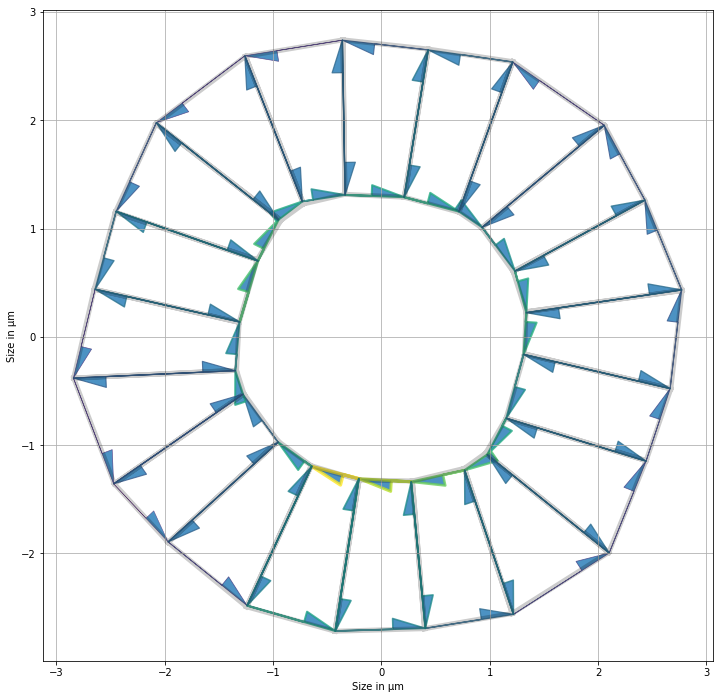

In [13]:
opt_mat_2_cst_organo = to_opt_organo.copy()
opt_mat_2_cst_organo.edge_df.line_tension = prepare_tensions(opt_mat_2_cst_organo, res_2_cst_areas.x[:organo3.Nf*3])
opt_mat_2_cst_organo.face_df.prefered_area = opt_mat_2_cst_organo.face_df.area.copy() + res_2_cst_areas.x[3*organo3.Nf:4*organo3.Nf]
opt_mat_2_cst_organo.settings['prefered_lumen_vol'] = opt_mat_2_cst_organo.settings['lumen_volume'] + res_2_cst_areas.x[-1]
Solver.find_energy_min(opt_mat_2_cst_organo, geom, model)
print_tensions(opt_mat_2_cst_organo, organo3)
print('Distance from th organo to exp organo : ' +
      str(np.sum(np.linalg.norm(_distance(organo3, opt_mat_2_cst_organo), axis=1))))
print('Distance from th tensions to exp tensions : ' +
      str(np.sum(np.linalg.norm(organo3.edge_df.line_tension[:3*organo3.Nf] -
                                opt_mat_2_cst_organo.edge_df.line_tension[:3*organo3.Nf]))))

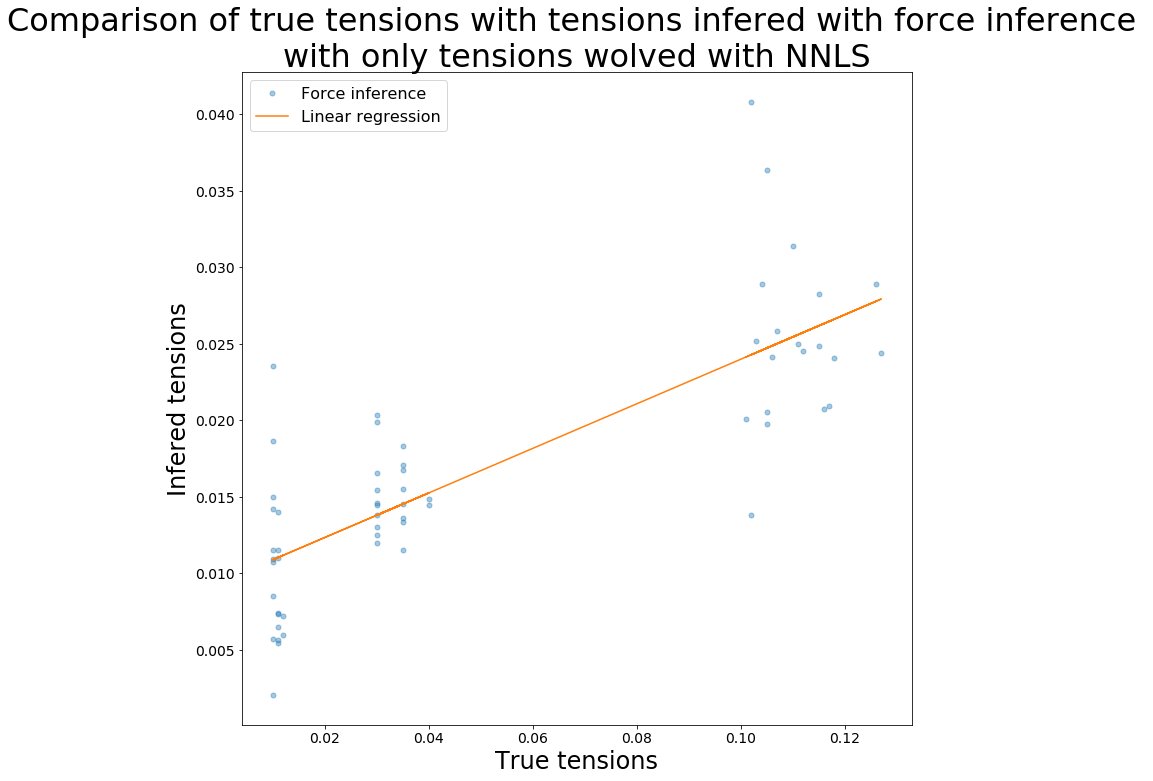

R value : 0.7944556118136724 
Standard error : 0.004148779867892044


In [14]:
rendering_results(organo3, organo3.edge_df.line_tension[:3*organo3.Nf],
                  res_2_cst_areas.x[:3*organo3.Nf],
                  'Comparison of true tensions with tensions infered with force inference \n' +
                  'with only tensions wolved with NNLS',
                  'True tensions', 'Infered tensions', ('Force inference', 'Linear regression'))

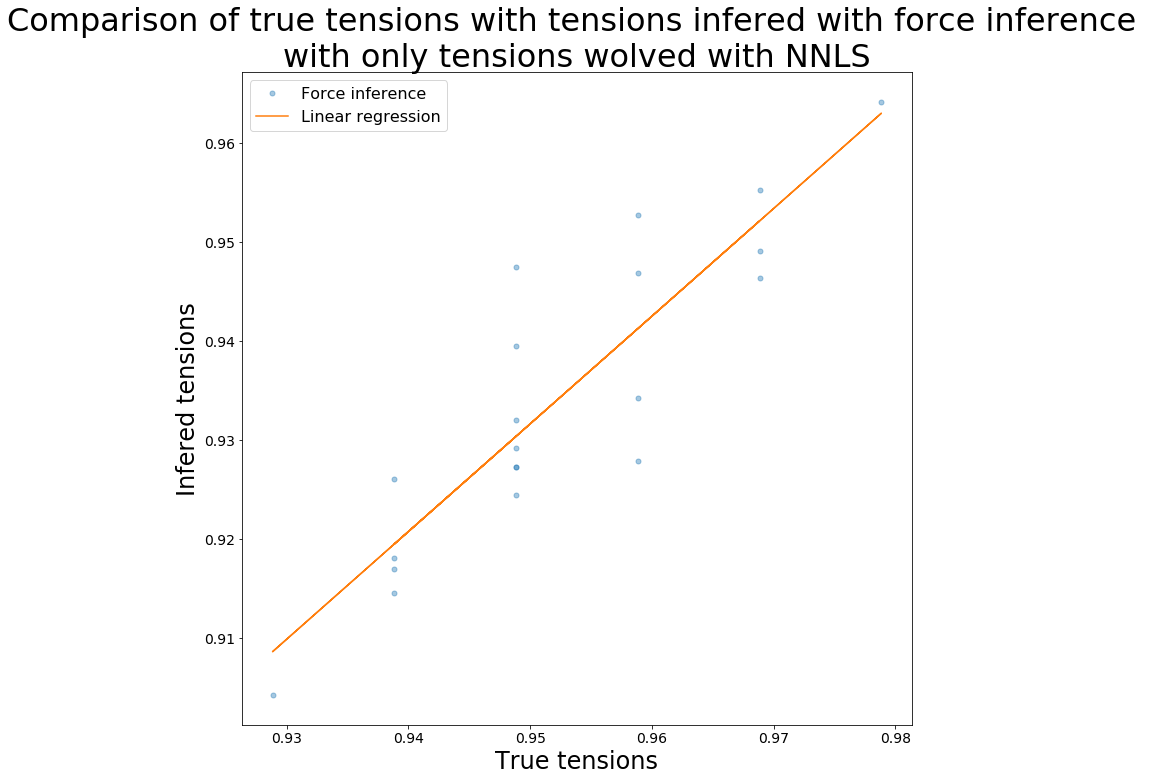

R value : 0.8878206709684273 
Standard error : 0.0034801544318503173


In [16]:
rendering_results(organo3, organo3.face_df.eval('prefered_area'),
                  res_2_cst_areas.x[4*organo3.Nf:-1],
                  'Comparison of true tensions with tensions infered with force inference \n' +
                  'with only tensions wolved with NNLS',
                  'True tensions', 'Infered tensions', ('Force inference', 'Linear regression'))